# Dragonfly registration
While other tasks used standard emlddmm, this setup has a different geometry which requires a more involved setup.

Brain is cut into adjacent slabs.  Each slab deforms and shrinks/shifts/translates.  

We will use a version of projection LDDMM for this.




In version 00, we just do one forward pass, and one reconstruction of the slices

nothing nonlinear.  Everything looks nice so far and we have a reasonable initialization.

note that I may need a smaller voxel size, so we can really see the end of the slices


in v01 I will start optimizing

Next I will add nonlinaer

Some notes.
I think I will need to pad J so that there is some contrast at the ends

In version 2 I add a fixed translation to each slice, just like a fixed trapezoid sampling

in version 4 I add deformation to each slab, less smooth

In [1]:
# note, I'm pretty sure that 07 is also backwards

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import os
from glob import glob
from os.path import join
import time

import imp
import donglab_workflows as dw
imp.reload(dw)

import torch
import time
from os import makedirs

In [3]:
# for now add emlddmm library for registration
import sys
sys.path.append('/home/dtward/data/csh_data/emlddmm')
import emlddmm
imp.reload(emlddmm)

<module 'emlddmm' from '/home/dtward/data/csh_data/emlddmm/emlddmm.py'>

In [4]:
# where should outputs go?
output_prefix = 'dragonfly_atlas_outputs_v04/'

In [5]:
# we will start by loading the data

In [6]:
# load atlas images
atlas_names = [
    '/home/dtward/data/AllenInstitute/allen_vtk/ara_nissl_50.vtk',
    '/home/dtward/data/AllenInstitute/allen_vtk/average_template_50.vtk',
]
seg_name = '/home/dtward/data/AllenInstitute/allen_vtk/annotation_50.vtk'

In [7]:
target_dir = '/home/dtward/bmaphome/data/dong/dragonfly_03_2022/'

target_pattern = '*10x*channel_1_*.npz'
target_pattern = '*10x*channel_0_*.npz'

In [8]:
I = []
for atlas_name in atlas_names:
    xI,I_,title,names = emlddmm.read_data(atlas_name)
    I_ = I_.astype(np.float32)
    I_ /= np.mean(np.abs(I_))
    I.append(I_)
    
I = np.concatenate(I)   
I[0] = I[0]**0.25
I[0] /= np.mean(np.abs(I_[0]))
dI = np.array([x[1] - x[0] for x in xI])
XI = np.stack(np.meshgrid(*xI,indexing='ij'),-1)

<IPython.core.display.Javascript object>


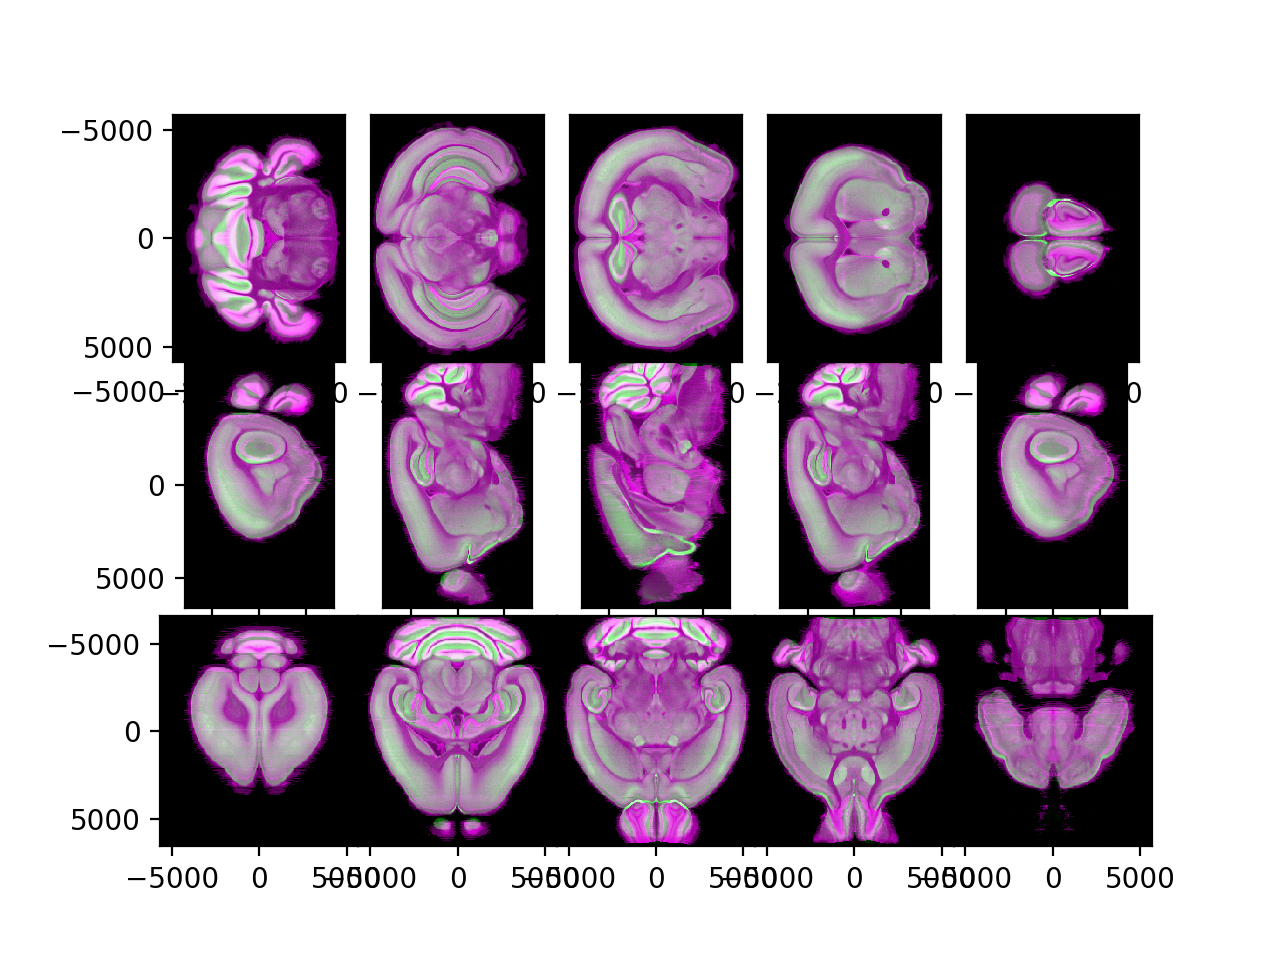

In [9]:
fig,ax = emlddmm.draw(I,xI,vmin=0)
fig.canvas.draw()

In [10]:
target_files = glob(join(target_dir,target_pattern))
target_files.sort()

In [11]:
# one of the slab is weirdly separated
target_files = target_files[1:]

In [12]:
# load the data
Js = []
xJs = []
Ws = []
dJs = []
DJs = []
for fname in target_files:
    data = np.load(fname,allow_pickle=True)
    Js.append(data['I'][None])    
    xJs.append(data['xI'])
    Ws.append(data['W'])
    
    
    # we need to normalize to [0,1]
    mymin = np.quantile(Js[-1][Ws[-1][None]>0.99],0.01)
    mymax = np.quantile(Js[-1][Ws[-1][None]>0.99],0.99)
    Js[-1] = (Js[-1] - mymin)/(mymax - mymin)
    
    # I'd like to squash the bright signal
    Js[-1][Js[-1]>=0] = Js[-1][Js[-1]>=0]**0.25
    Js[-1][Js[-1]<0] = -np.abs(Js[-1][Js[-1]<0])**0.25
    
    # we need to normalize to [0,1] again!
    mymin = np.quantile(Js[-1][Ws[-1][None]>0.99],0.01)
    mymax = np.quantile(Js[-1][Ws[-1][None]>0.99],0.99)
    Js[-1] = (Js[-1] - mymin)/(mymax - mymin)
    
    dJs.append([x[1]-x[0] for x in xJs[-1]])
    DJs.append(np.prod(dJs[-1]) )
    

<IPython.core.display.Javascript object>


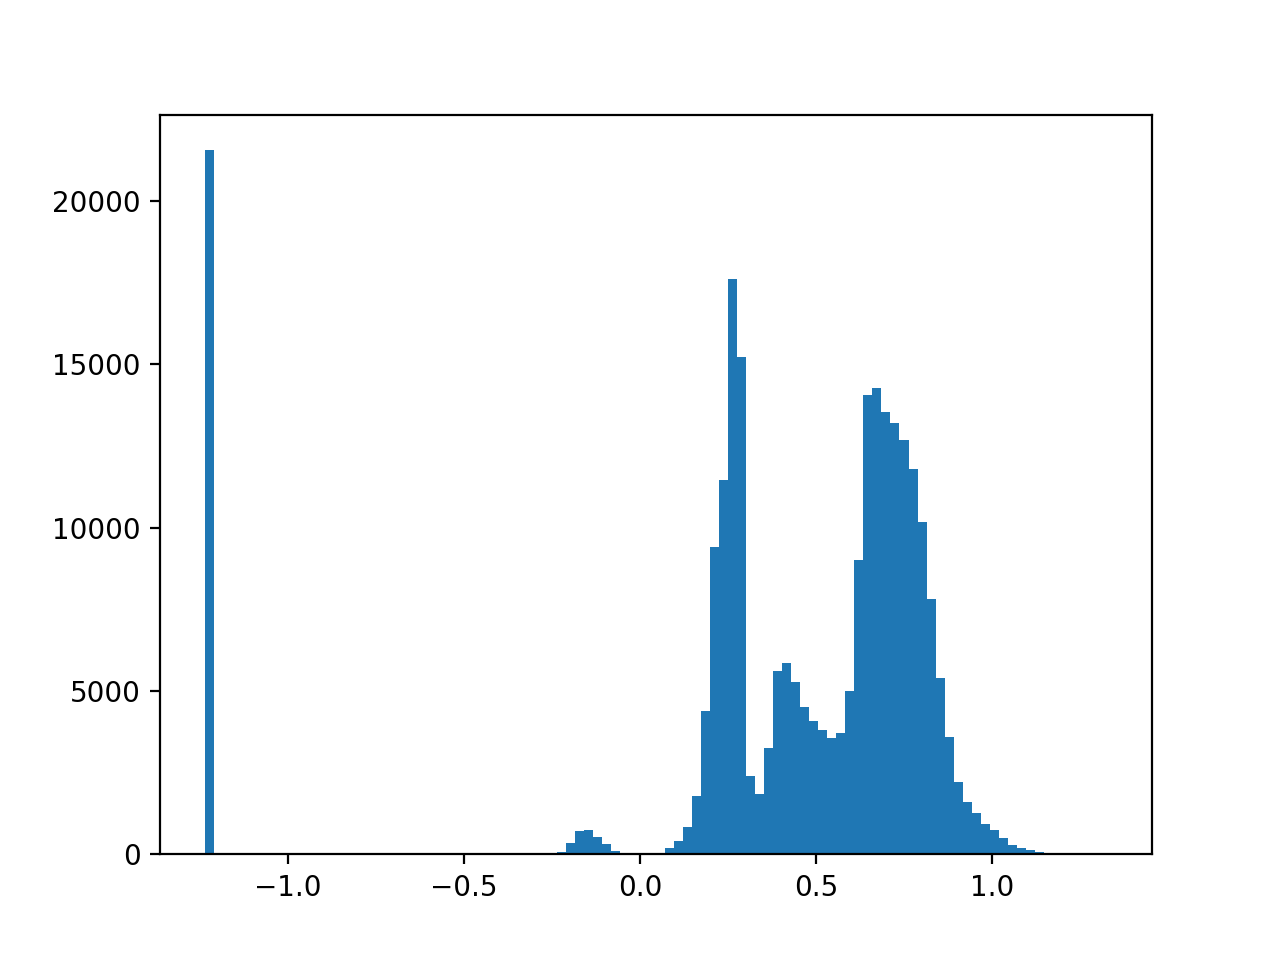

(array([2.1536e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+01, 5.9000e+01,
        3.3600e+02, 7.0400e+02, 7.5200e+02, 5.3900e+02, 3.1600e+02,
        1.1800e+02, 3.7000e+01, 4.0000e+00, 1.0000e+00, 1.0000e+01,
        5.3000e+01, 1.9300e+02, 3.9500e+02, 8.4700e+02, 1.7730e+03,
        4.3740e+03, 9.3990e+03, 1.1454e+04, 1.7596e+04, 1.5222e+04,
        2.4070e+03, 1.8430e+03, 3.2580e+03, 5.6110e+03, 5.8620e+03,
        5.2840e+03, 4.5220e+03, 4.0800e+03, 3.7940e+03, 3.5600e+03,
        3.7070e+03, 5.0010e+03, 9.0210e+03, 1.40

In [13]:
f,ax = plt.subplots()
ax.hist(Js[-1].ravel(),100)

In [14]:
# I want to pad everything 
for i in range(len(Js)):
    Ji = Js[i]
    Wi = Ws[i]
    xJi = xJs[i]
    dJi = dJs[i]
    
    # find the 1% quantile
    val = np.quantile(Ji[Wi[None]>=0.99],0.05)
    npad = 2
    Ji = np.pad(Ji,((0,0),(npad,npad),(0,0),(0,0)), constant_values=val)
    Wi = np.pad(Wi,((npad,npad),(0,0),(0,0)), constant_values=1.0)
    for j in range(npad):
        xJi[0] = np.concatenate((xJi[0][0][None]-dJi[0], xJi[0], xJi[0][-1][None]+dJi[0]))
    
    Js[i] = Ji
    Ws[i] = Wi
    xJs[i] = xJi
    

<IPython.core.display.Javascript object>


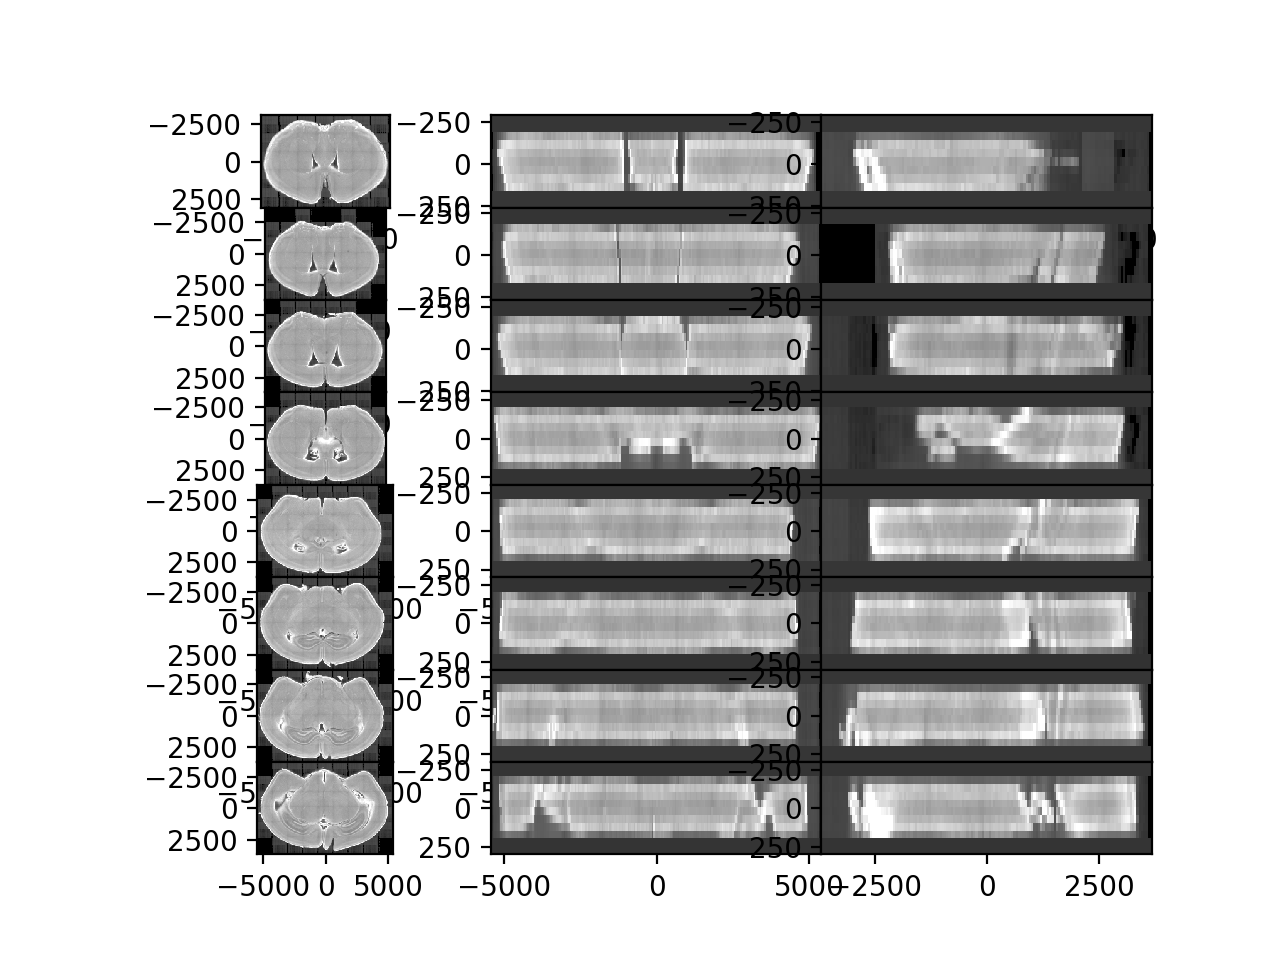

<IPython.core.display.Javascript object>


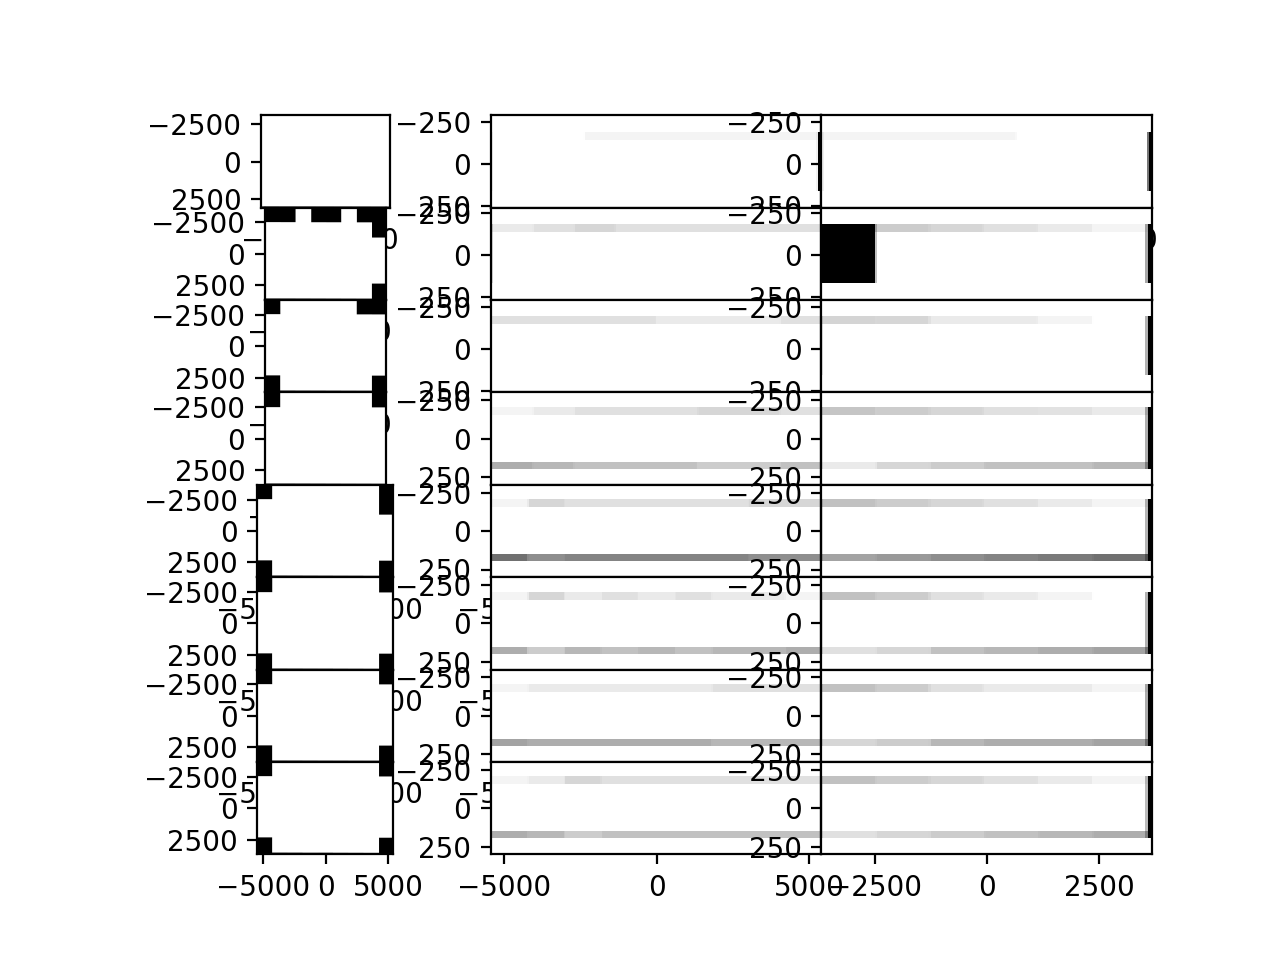

In [15]:
def clip(I):
    I = np.copy(I)
    I[I<0] = 0
    I[I>1] = 1
    return I
def draw_stack(Js,xJs,fig=None,**kwargs):
    '''
    stack is on the first axis
    note there is an issue with sharex and removing the axis labels
    also an issue cause the images are different number of slices
    Not using now
    TODO: make sure this will work with numpy or torch
    avoid copying too much

    '''
    #print(kwargs)
    if 'vmin' in kwargs:
        vmin = kwargs.pop('vmin')
    else:
        vmin = np.min([np.min(np.array(J)) for J in Js])
    if 'vmax' in kwargs:
        vmax = kwargs.pop('vmax')
    else:
        vmax = np.min([np.max(np.array(J)) for J in Js])    
    
    
    
    n = len(Js)
    if fig is None:
        figsize = (5,10)
        figsize = None
        fig = plt.figure(figsize=figsize)
    else:
        fig.clf()
    
    
    for i in range(n):
        if i == 0:
            ax0 = fig.add_subplot(n,3,3*i+1)
            ax = ax0
        else:
            ax0 = None
            ax = fig.add_subplot(n,3,3*i+1,sharex=ax0,sharey=ax0)
            
        toshow = np.array(Js[i][:,Js[i].shape[1]//2]).transpose(1,2,0)
        if toshow.shape[-1] == 1:
            toshow = np.concatenate((toshow,toshow,toshow),-1)
        elif toshow.shape[-1] == 2:
            toshow = np.stack((toshow[...,0],toshow[...,1],toshow[...,0]),-1)
        else:
            toshow = toshow[...,:3]
        toshow -= vmin
        toshow /= vmax-vmin
        xJ = xJs[i]
        dJ = [x[1]-x[0] for x in xJ]
        extent = (xJ[-1][0]-dJ[-1]*0.5,xJ[-1][-1]+dJ[-1]*0.5,
                 xJ[-2][-1]+dJ[-2]*0.5,xJ[-2][0]-dJ[-2]*0.5)
        ax.imshow(clip(toshow),extent=extent,**kwargs)
        #if i < n-1:
        #    ax.set_xticks([])
        
        
        
        if i == 0:
            ax1 = fig.add_subplot(n,3,3*i+2)
            ax = ax1
        else:
            ax1 = None
            ax = fig.add_subplot(n,3,3*i+2,sharex=ax1,sharey=ax1)
        toshow = np.array(Js[i][:,:,Js[i].shape[2]//2]).transpose(1,2,0)
        if toshow.shape[-1] == 1:
            toshow = np.concatenate((toshow,toshow,toshow),-1)
        elif toshow.shape[-1] == 2:
            toshow = np.stack((toshow[...,0],toshow[...,1],toshow[...,0]),-1)
        else:
            toshow = toshow[...,:3]
        toshow -= vmin
        toshow /= vmax-vmin
        
        
        extent = (xJ[-1][0]-dJ[-1]*0.5,xJ[-1][-1]+dJ[-1]*0.5,
                 xJ[-3][-1]+dJ[-3]*0.5,xJ[-3][0]-dJ[-3]*0.5)        
        ax.imshow(clip(toshow),extent=extent,**kwargs)
        ax.set_aspect('auto')
        #if i < n-1:
        #    ax.set_xticks([])
        
        
        if i == 0:
            ax2 = fig.add_subplot(n,3,3*i+3)
            ax = ax2
        else:
            ax2 = None
            ax = fig.add_subplot(n,3,3*i+3,sharex=ax2,sharey=ax2)
        toshow = np.array(Js[i][:,:,:,Js[i].shape[3]//2]).transpose(1,2,0)
        if toshow.shape[-1] == 1:
            toshow = np.concatenate((toshow,toshow,toshow),-1)
        elif toshow.shape[-1] == 2:
            toshow = np.stack((toshow[...,0],toshow[...,1],toshow[...,0]),-1)            
        else:
            toshow = toshow[...,:3]
        toshow -= vmin
        toshow /= vmax-vmin
        extent = (xJ[-2][0]-dJ[-2]*0.5,xJ[-2][-1]+dJ[-2]*0.5,
                 xJ[-3][-1]+dJ[-3]*0.5,xJ[-3][0]-dJ[-3]*0.5)
        ax.imshow(clip(toshow),extent=extent,**kwargs)
        ax.set_aspect('auto')
        #if i < n-1:
        #    ax.set_xticks([])
        plt.subplots_adjust(wspace=0,hspace=0)
        
    return fig,None # later I will return ax
        
vminJ = 100.0
vmaxJ = 115.0
vmaxJ = 130 # for channel 0
vminJ = 0.0
vmaxJ = 1.0

fig,ax = draw_stack(Js,xJs,vmin=vminJ,vmax=vmaxJ)
fig.canvas.draw()
fig,ax = draw_stack([w[None] for w in Ws],xJs,vmin=0,vmax=1)
    
    

In [16]:
# now we have to firm up the model
# as usual, I will start with just linear
# then I'll add the projection step


In [17]:
# lets convert to torch

In [18]:
Inp = np.copy(I)
xInp = [np.copy(x) for x in xI]
Jnp = [np.copy(Ji) for Ji in Js]
xJnp = [[np.copy(x) for x in xJ] for xJ in xJs]
Wnp = [np.copy(Wi) for Wi in Ws]

In [19]:
device = 'cpu'
device = 'cuda:1'
dtype = torch.float64
I = torch.tensor(Inp,device=device,dtype=dtype)
xI = [torch.tensor(x,device=device,dtype=dtype) for x in xInp]
J = [torch.tensor(Ji,device=device,dtype=dtype) for Ji in Jnp]
W = [torch.tensor(Wi,device=device,dtype=dtype) for Wi in Wnp]
xJ = [[torch.tensor(x,device=device,dtype=dtype) for x in xJi] for xJi in xJnp]
XJ = [ torch.stack(torch.meshgrid(x[0],x[1],x[2],indexing='ij'),-1) for x in xJ]
# note I'm stacking at the end
# I think I may have to stack at the start
XI = torch.stack(torch.meshgrid(*xI,indexing='ij'),-1)

<IPython.core.display.Javascript object>


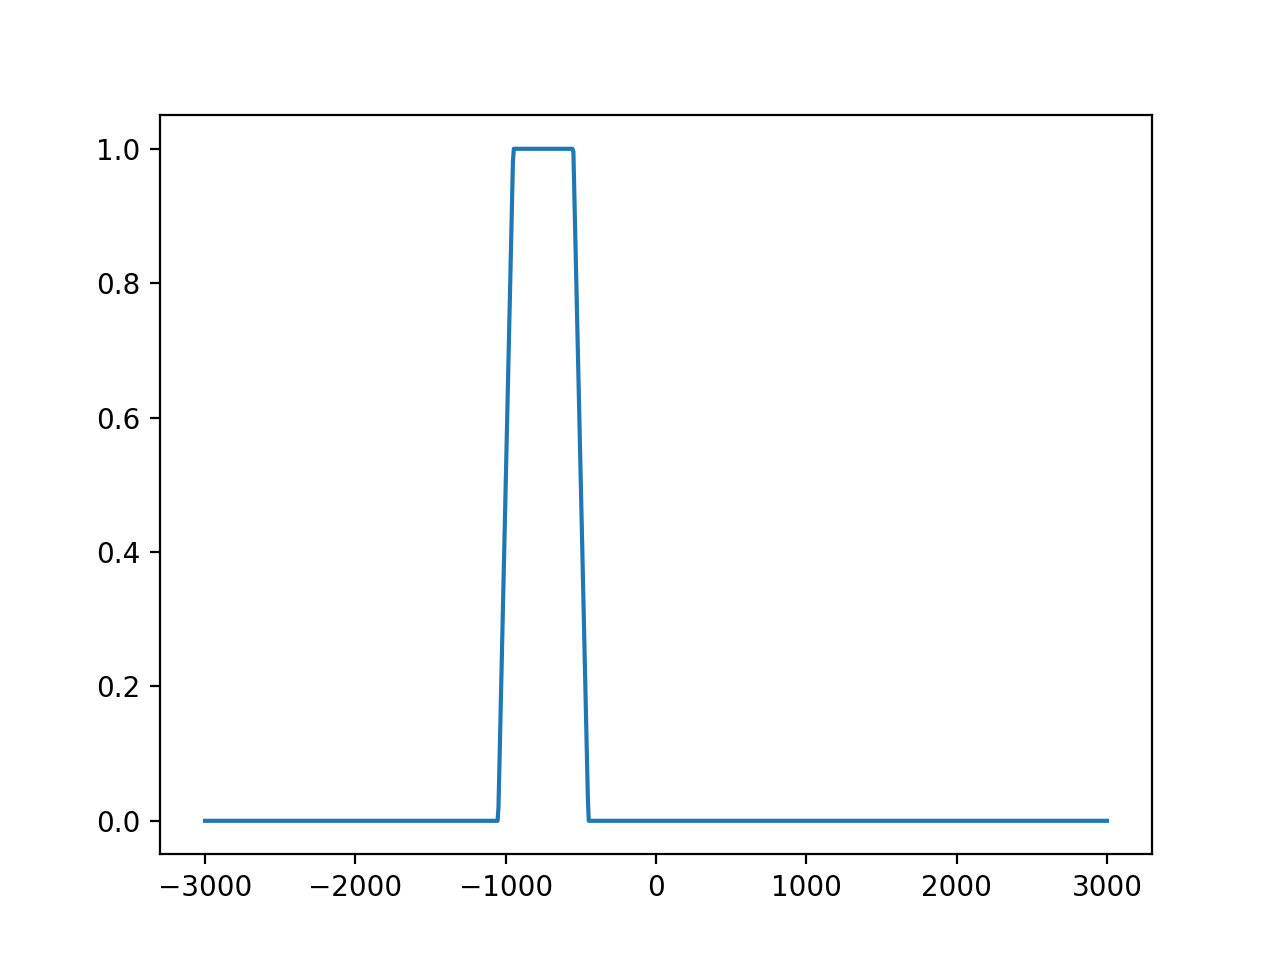

In [20]:
# lets build a trapezoid function
dslice = 500.0 # 500 micron slices
def trapezoid(x,i):
    # if it is in the middle
    d = torch.abs(x - (i - (len(J)-1)/2.0)*dslice)
    out = (d < dslice/2.0)*1.0 + (d >= dslice/2.0)*(d < dslice/2.0+dI[0])*(1.0 - (d-dslice/2.0)/dI[0])    
    return out
def trapezoid(x,i):
    # if it is in the middle
    d = torch.abs(x - (i - (len(J)-1)/2.0)*dslice)
    out = (d < dslice/2.0 - dI[0])*1.0 + (d >= dslice/2.0 - dI[0])*(d < dslice/2.0+dI[0])*(1.0 - (d-dslice/2.0)/dI[0])*0.5
    return out
# I want the edge to be at 0.5, and take one voxel to go up or down
t = torch.linspace(-3000,3000,1000)
f,ax = plt.subplots()
ax.plot(t,trapezoid(t,2))

In [21]:
DI = torch.prod(torch.tensor(dI,device=device,dtype=dtype))

<IPython.core.display.Javascript object>


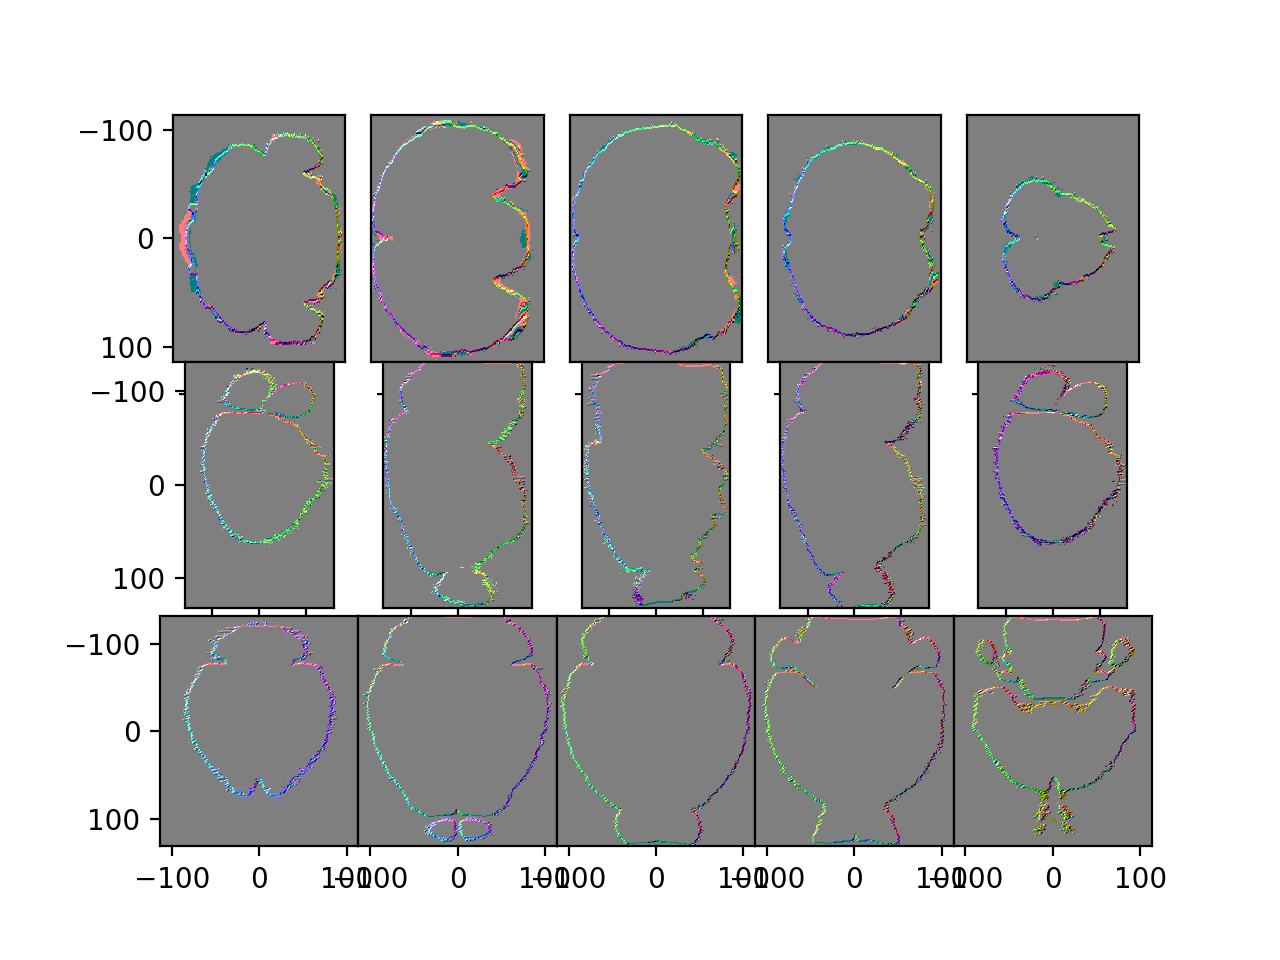

(<Figure size 640x480 with 15 Axes>,
 [[<matplotlib.axes._subplots.AxesSubplot at 0x7fdc89e1d450>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7fdc90bcf910>]])

In [22]:
W_ = (I[0] > 0).to(dtype)
DW = torch.stack(torch.gradient(W_,spacing=dI.tolist(),dim=(0,1,2)),-1)
emlddmm.draw(DW.permute(-1,0,1,2))

In [23]:
gid = torch.zeros(12,12,device=device,dtype=dtype)

count0 = 0
for i0 in range(3):
    for j0 in range(4):
        E0 = ((torch.arange(4,device=device,dtype=dtype)==i0)[:,None]*(torch.arange(4,device=device,dtype=dtype)==j0)[None,:]).to(dtype)
        if j0 == 3:
            tosum0 = DW[...,i0]
        else:
            tosum0 = DW[...,i0]*XI[...,j0]
            
        count1 = 0
        for i1 in range(3):
            for j1 in range(4):
                if count0 > count1:
                    count1 += 1
                    continue                                
                E1 = ((torch.arange(4,device=device,dtype=dtype)==i1)[:,None]*(torch.arange(4,device=device,dtype=dtype)==j1)[None,:]).to(dtype)                
                if j1 == 3:
                    tosum1 = DW[...,i1]
                else:
                    tosum1 = DW[...,i1]*XI[...,j1]
                                                            
                gid[count0,count1] = torch.sum(tosum0*tosum1)*DI
                gid[count1,count0] = gid[count0,count1]                                
                
                count1 += 1
        count0 += 1

In [24]:
def small_to_big(a):
    '''
    Convert A to a big linear map that acts on a vectorized matrix
    We compute it through its action on basis vectors
    '''
    
    A = torch.zeros(12,12,dtype=a.dtype,device=a.device)
    device = a.device
    dtype = a.dtype
    count0 = 0
    for i0 in range(3):
        for j0 in range(4):
            E0 = ((torch.arange(4,device=device,dtype=dtype)==i0)[:,None]*(torch.arange(4,device=device,dtype=dtype)==j0)[None,:]).to(dtype)
            
            A[:,count0] = (a@E0)[:3,:4].ravel()
            count0 += 1
    return A


In [25]:
def gA_from_gid(gid,A):
    # we need to convert A to a 12x12 map
    A_ = small_to_big(torch.linalg.inv(A))
    gA = A_.T@gid@A_
    return gA
    

<IPython.core.display.Javascript object>


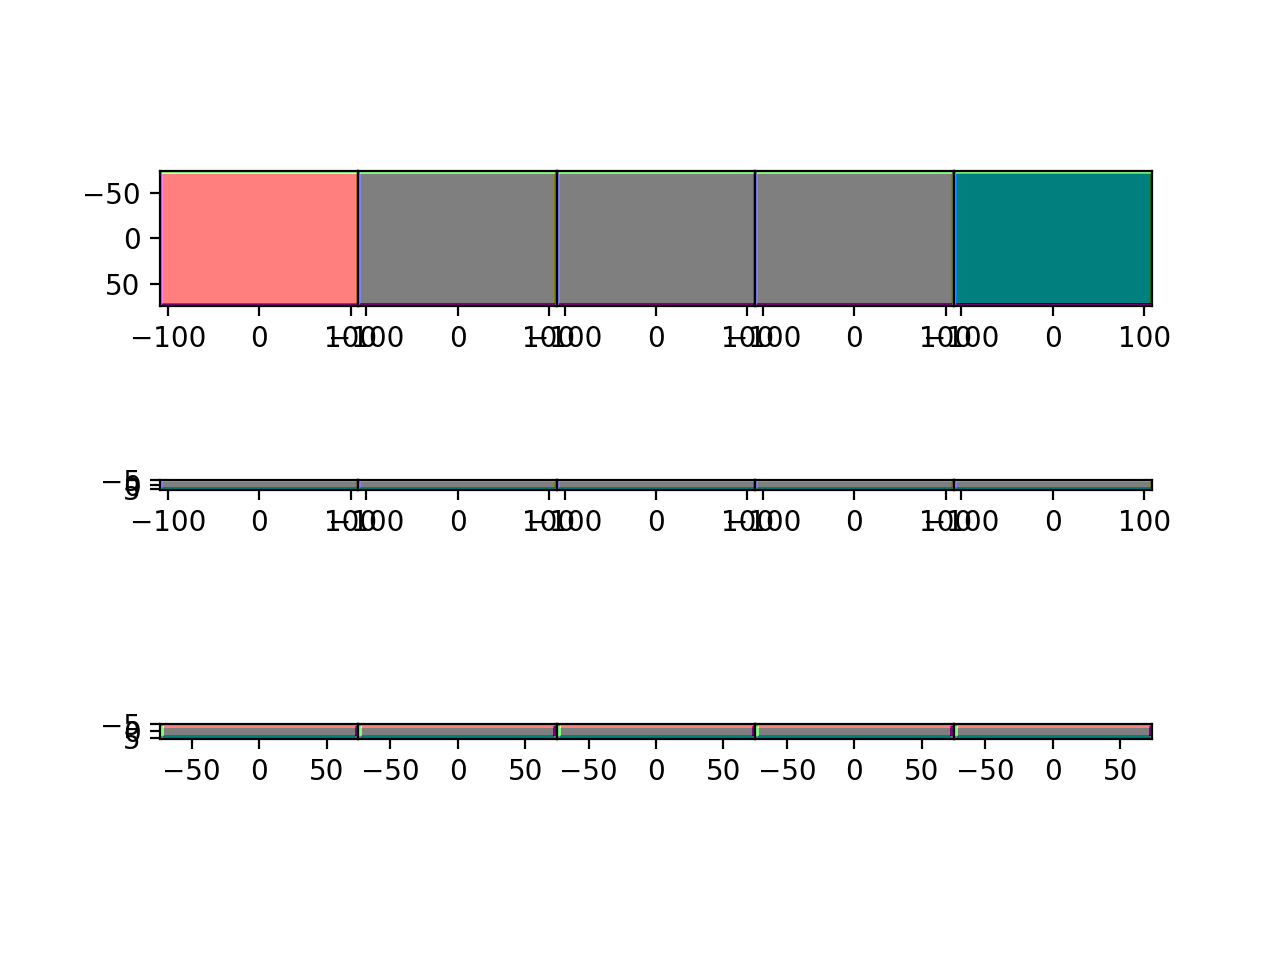

(<Figure size 640x480 with 15 Axes>,
 [[<matplotlib.axes._subplots.AxesSubplot at 0x7fdc90b4c250>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7fdc90807d50>]])

In [26]:
# now we need to do the same for gJ
# but these will change
# so instead we'll just do this
Jind = len(XJ)//2
W_ = torch.ones_like(XJ[Jind][...,0])
border = 2
W_[:border] = 0.0
W_[-border:] = 0.0
W_[:,:border] = 0.0
W_[:,-border:] = 0.0
W_[:,:,:border] = 0.0
W_[:,:,-border:] = 0.0


DW = torch.stack(torch.gradient(W_,spacing=dI.tolist(),dim=(0,1,2)),-1)
emlddmm.draw(DW.permute(-1,0,1,2))

In [27]:
gJid = torch.zeros(12,12,device=device,dtype=dtype)

count0 = 0
for i0 in range(3):
    for j0 in range(4):
        E0 = ((torch.arange(4,device=device,dtype=dtype)==i0)[:,None]*(torch.arange(4,device=device,dtype=dtype)==j0)[None,:]).to(dtype)
        if j0 == 3:
            tosum0 = DW[...,i0]
        else:
            tosum0 = DW[...,i0]*XJ[Jind][...,j0]
            
        count1 = 0
        for i1 in range(3):
            for j1 in range(4):
                if count0 > count1:
                    count1 += 1
                    continue                                
                E1 = ((torch.arange(4,device=device,dtype=dtype)==i1)[:,None]*(torch.arange(4,device=device,dtype=dtype)==j1)[None,:]).to(dtype)                
                if j1 == 3:
                    tosum1 = DW[...,i1]
                else:
                    tosum1 = DW[...,i1]*XJ[Jind][...,j1]
                                                            
                gJid[count0,count1] = torch.sum(tosum0*tosum1)*DJs[Jind]
                gJid[count1,count0] = gJid[count0,count1]                                
                
                count1 += 1
        count0 += 1

<IPython.core.display.Javascript object>


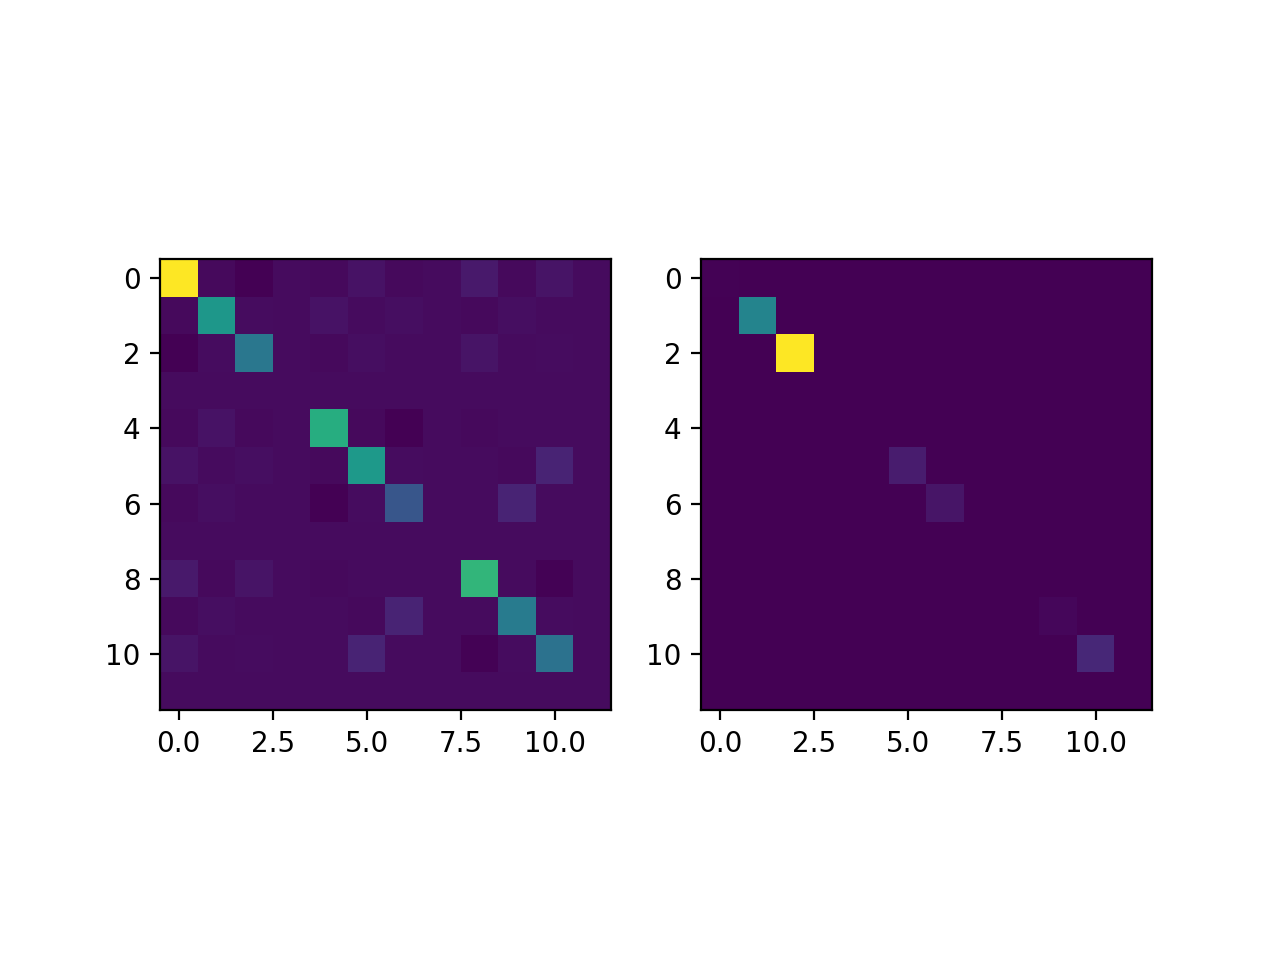

In [28]:
f,ax = plt.subplots(1,2)
ax[0].imshow(gid.cpu())
ax[1].imshow(gJid.cpu())

In [29]:
# set up kernels
dv = torch.tensor([1.0,1.0,1.0],device=device,dtype=dtype)*500.0
DV = torch.prod(dv)
dI = torch.tensor(dI,device=device,dtype=dtype)
v_expand_factor = 0.1
a = 500.0
p = 2.0
aprefactor = 0.25
nt = 5

print(f'a scale is {a}')
x0v = [x[0] - (x[-1]-x[0])*v_expand_factor for x in xI]
x1v = [x[-1] + (x[-1]-x[0])*v_expand_factor for x in xI]
xv = [torch.arange(x0,x1,d,device=device,dtype=dtype) for x0,x1,d in zip(x0v,x1v,dv)]
nv = torch.tensor([len(x) for x in xv],device=device,dtype=dtype)
XV = torch.stack(torch.meshgrid(xv),-1)

# build energy operator for velocity
fv = [torch.arange(n,device=device,dtype=dtype)/d/n for n,d in zip(nv,dv)]
FV = torch.stack(torch.meshgrid(fv))

LL = (1.0 - 2.0*a**2 * 
          ( (torch.cos(2.0*np.pi*FV[0]*dv[0]) - 1)/dv[0]**2  
        + (torch.cos(2.0*np.pi*FV[1]*dv[1]) - 1)/dv[1]**2  
        + (torch.cos(2.0*np.pi*FV[2]*dv[2]) - 1)/dv[2]**2   ) )**(p*2)
K = 1.0/LL

LLpre = (1.0 - 2.0*(aprefactor*torch.max(dI))**2 * 
         ( (torch.cos(2.0*np.pi*FV[0]*dv[0]) - 1)/dv[0]**2  
         + (torch.cos(2.0*np.pi*FV[1]*dv[1]) - 1)/dv[1]**2  
         + (torch.cos(2.0*np.pi*FV[2]*dv[2]) - 1)/dv[2]**2   ) )**(p*2)
Kpre = 1.0/LLpre
KK = K*Kpre



a scale is 500.0


/home/dtward/.local/intelpython3/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [30]:
# set up kernels for blocks
dvJ = torch.tensor([1.0,1.0,1.0],device=device,dtype=dtype)*100.0
DVJ = torch.prod(dvJ)
v_expand_factor = 0.1
aJ = 50.0
pJ = 2.0
aprefactorJ = 0.25
ntJ = 3

print(f'aJ scale is {aJ}')
LLJ = []
KJ = []
KJpre = []
XVJ = []
xvJ = []
for i in range(len(J)):
    x0vJ = [x[0] - (x[-1]-x[0])*v_expand_factor for x in xJs[i]]
    x1vJ = [x[-1] + (x[-1]-x[0])*v_expand_factor for x in xJs[i]]    
    xvJi = [torch.arange(x0,x1,d,device=device,dtype=dtype) for x0,x1,d in zip(x0vJ,x1vJ,dvJ)]
    nvJi = torch.tensor([len(x) for x in xvJi],device=device,dtype=dtype)
    XVJi = torch.stack(torch.meshgrid(xvJi),-1)

    
    
    # build energy operator for velocity
    fvJi = [torch.arange(n,device=device,dtype=dtype)/d/n for n,d in zip(nvJi,dvJ)]
    FVJi = torch.stack(torch.meshgrid(fvJi))

    LLJi = (1.0 - 2.0*aJ**2 * 
            ( (torch.cos(2.0*np.pi*FVJi[0]*dvJ[0]) - 1)/dvJ[0]**2  
            + (torch.cos(2.0*np.pi*FVJi[1]*dvJ[1]) - 1)/dvJ[1]**2  
            + (torch.cos(2.0*np.pi*FVJi[2]*dvJ[2]) - 1)/dvJ[2]**2   ) )**(pJ*2)
    KJi = 1.0/LLJi

    LLpreJi = (1.0 - 2.0*(aprefactorJ*torch.max(dI))**2 * 
             ( (torch.cos(2.0*np.pi*FVJi[0]*dvJ[0]) - 1)/dvJ[0]**2  
             + (torch.cos(2.0*np.pi*FVJi[1]*dvJ[1]) - 1)/dvJ[1]**2  
             + (torch.cos(2.0*np.pi*FVJi[2]*dvJ[2]) - 1)/dvJ[2]**2   ) )**(pJ*2)
    KpreJi = 1.0/LLpreJi
    KKJi = KJi*KpreJi

    LLJ.append(LLJi)
    KJ.append(KJi)
    KJpre.append(KpreJi)
    XVJ.append(XVJi)
    xvJ.append(xvJi)

aJ scale is 50.0


In [31]:
# initialize params
# 3D
A = torch.eye(4,device=device,dtype=dtype) # no
A = torch.tensor([[0.0,1.0,0.0,0.0],
                 [1.0,0.0,0.0,0.0],
                 [0.0,0.0,1.0,0.0],
                 [0.0,0.0,0.0,1.0]],device=device,dtype=dtype) # no
A = torch.tensor([[-1.0,0.0,0.0,2000.0],
                 [0.0,0.0,-1.0,0.0],
                 [0.0,1.0,0.0,0.0],
                 [0.0,0.0,0.0,1.0]],device=device,dtype=dtype) # good

A = torch.tensor([[-1.0,0.0,0.0,1000.0],
                 [0.0,0.0,-1.0,0.0],
                 [0.0,1.0,0.0,0.0],
                 [0.0,0.0,0.0,1.0]],device=device,dtype=dtype) # for ventricles
# this one seems to match ventricles well
# final energy after 20k iter: 2.3158e+10

# a test
A = torch.tensor([[-1.0,0.0,0.0,500.0],
                 [0.0,0.0,-1.0,0.0],
                 [0.0,1.0,0.0,0.0],
                 [0.0,0.0,0.0,1.0]],device=device,dtype=dtype) 
# this one (above) seemed to match dentate well
# got to E 2.3647e+10 after 20K iterations, this is definitely higher than the above
'''
A = torch.tensor([[-1.0,0.0,0.0,0.0],
                 [0.0,0.0,-1.0,0.0],
                 [0.0,1.0,0.0,0.0],
                 [0.0,0.0,0.0,1.0]],device=device,dtype=dtype) 
'''
# ok it does climb up toward 1000, but it is very slow, initialization is still important

# per slice, note translations 
# these take the slices and move them to be zero centered
TJ = [torch.tensor([[1.0,0.0,0.0,-(i - (len(J)-1)/2.0)*dslice],
                   [0.0,1.0,0.0,0.0],
                   [0.0,0.0,1.0,0.0],
                   [0.0,0.0,0.0,1.0]],device=device,dtype=dtype) for i in range(len(J))]
AJi = [torch.tensor([[1.0,0.0,0.0,0.0],
                   [0.0,1.0,0.0,0.0],
                   [0.0,0.0,1.0,0.0],
                   [0.0,0.0,0.0,1.0]],device=device,dtype=dtype) for i in range(len(J))]

AJi = torch.stack(AJi)
#AJi[1:6][0,0] = AJi[1:6][0,0]*(-1)
#AJi[1:6][1,1] = AJi[1:6][1,1]*(-1)

if len(J) == 8:
    for i in range(0,5): # after I cut off the first
        AJi[i][0,0] = AJi[i][0,0]*(-1)
        AJi[i][2,2] = AJi[i][2,2]*(-1) # left right
elif len(J) == 9:
    for i in range(1,6):
        print(i)
        print(target_files[i])
        AJi[i][0,0] = AJi[i][0,0]*(-1)
        AJi[i][2,2] = AJi[i][2,2]*(-1) # left right
else:
    raise Exeption(f'No initialization when len(J) is {len(J)}')
#print(AJi)
AJ = torch.linalg.inv(AJi)

v = torch.zeros((nt,XV.shape[0],XV.shape[1],XV.shape[2],XV.shape[3]),device=device,dtype=dtype,requires_grad=True)
vJ = [torch.zeros((ntJ,KJ[i].shape[0],KJ[i].shape[1],KJ[i].shape[2],3),device=device,dtype=dtype,requires_grad=True) for i in range(len(J))]

<IPython.core.display.Javascript object>


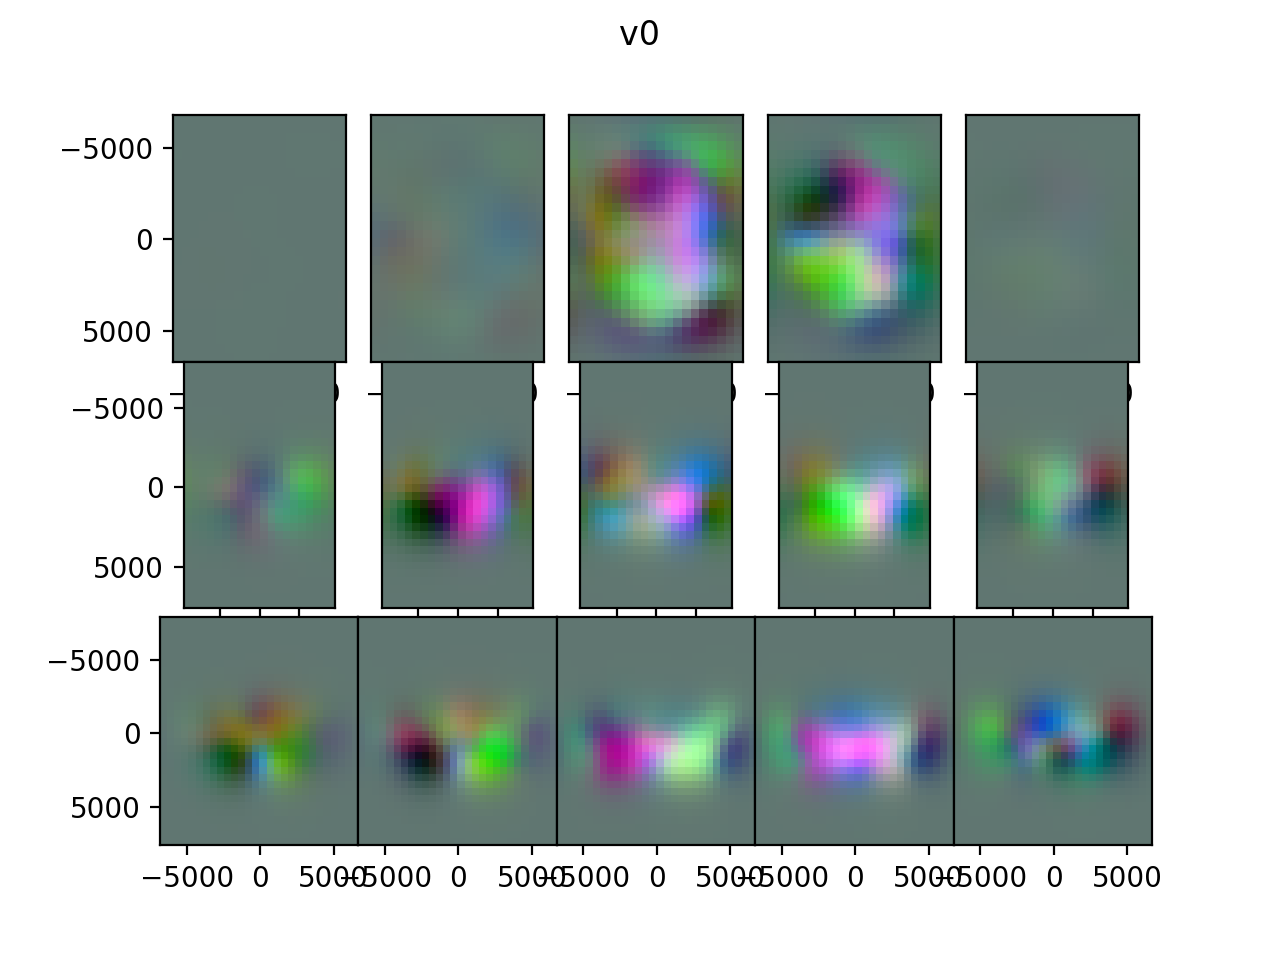

<IPython.core.display.Javascript object>


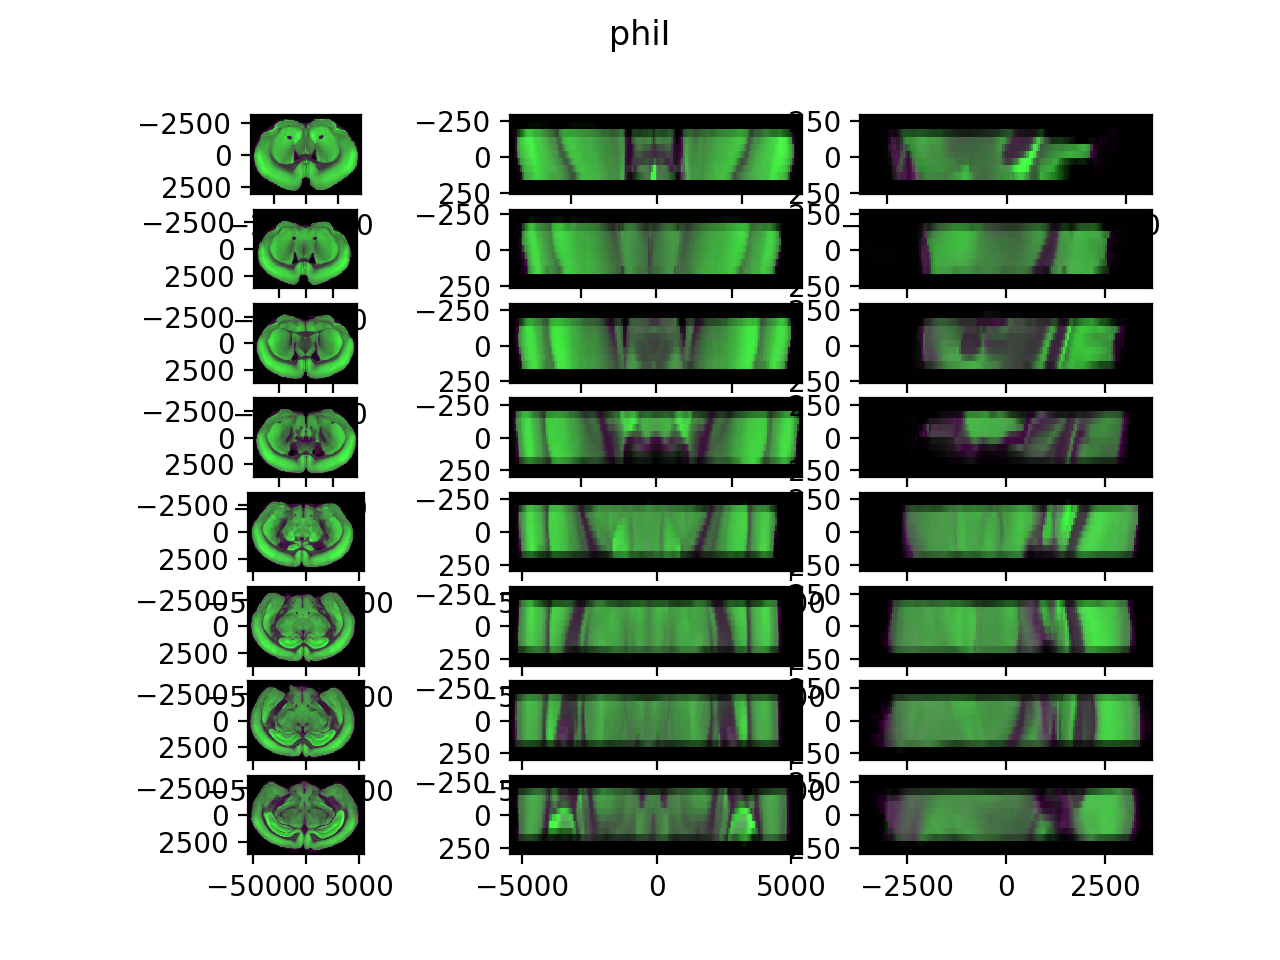

<IPython.core.display.Javascript object>


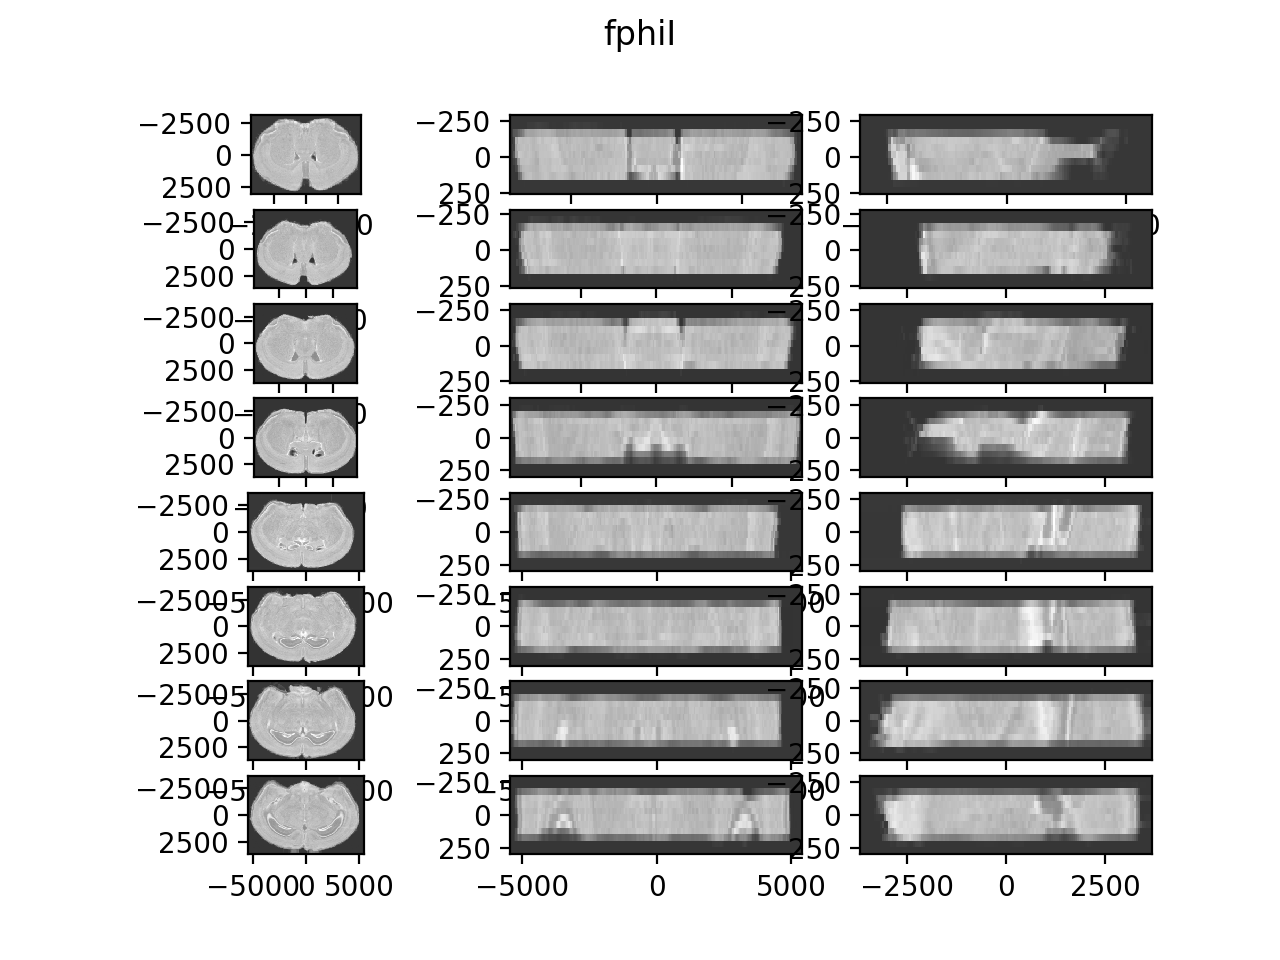

<IPython.core.display.Javascript object>


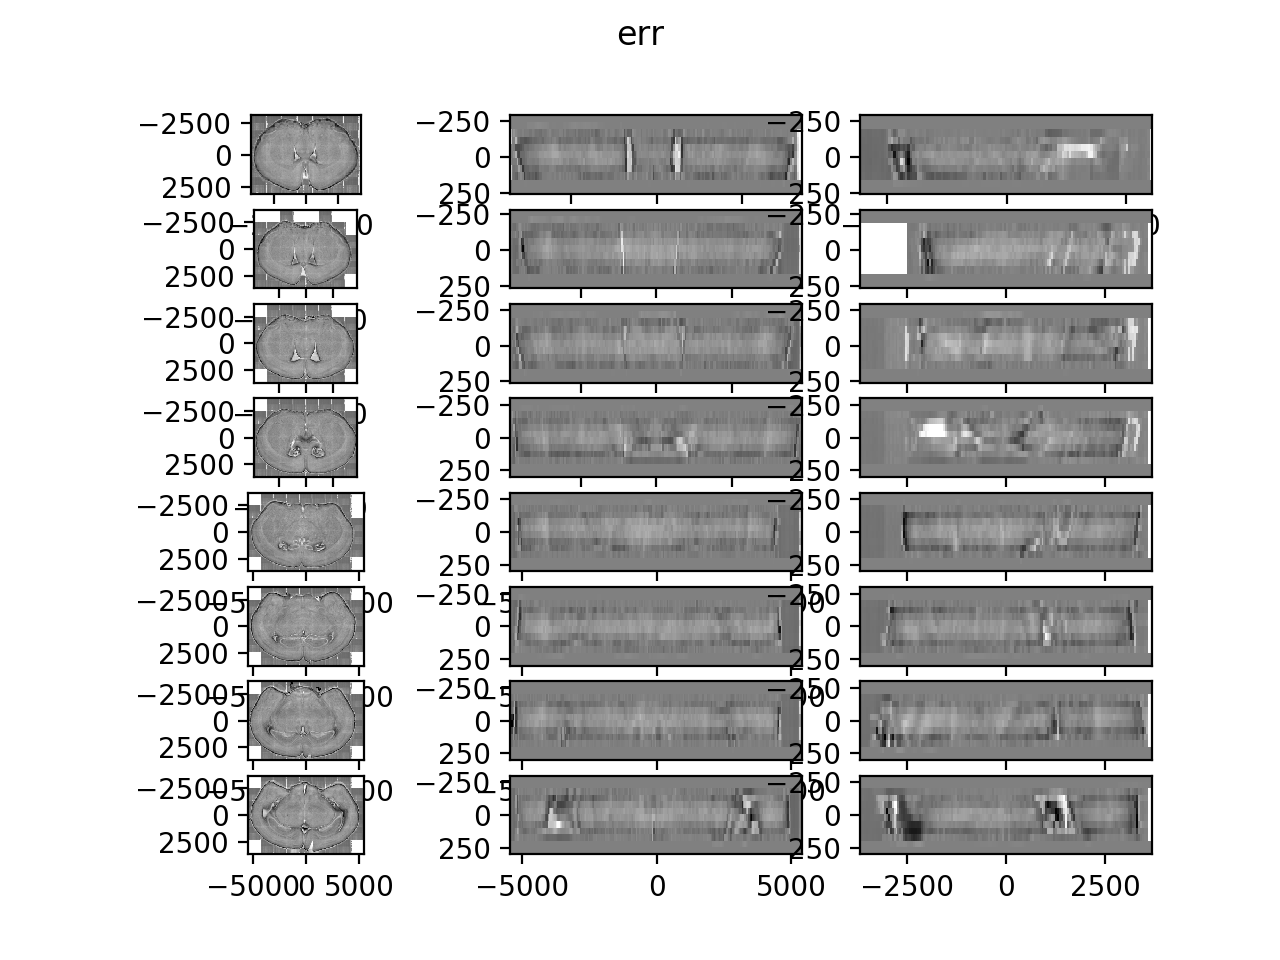

<IPython.core.display.Javascript object>


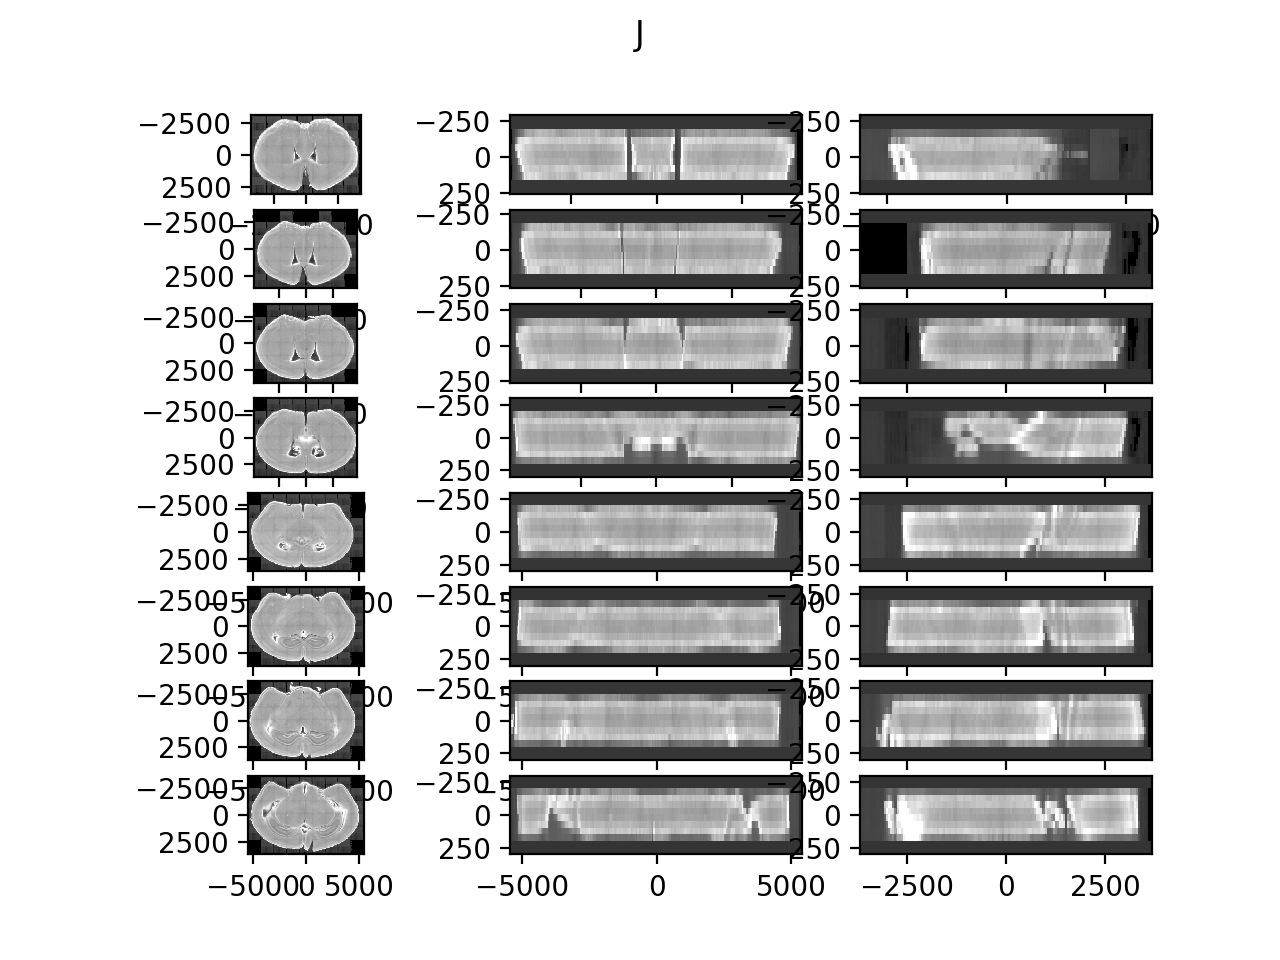

<IPython.core.display.Javascript object>


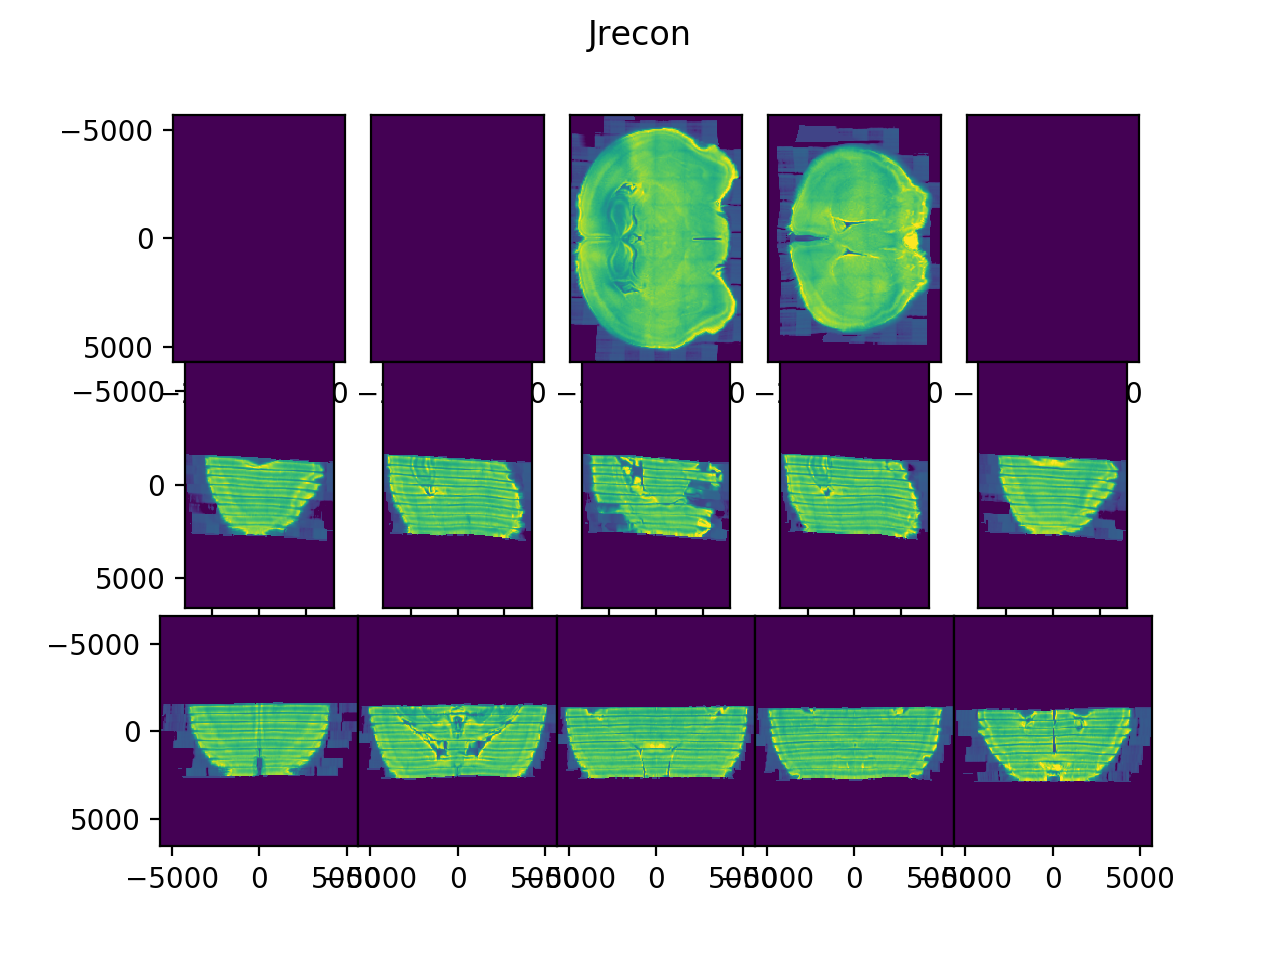

<IPython.core.display.Javascript object>


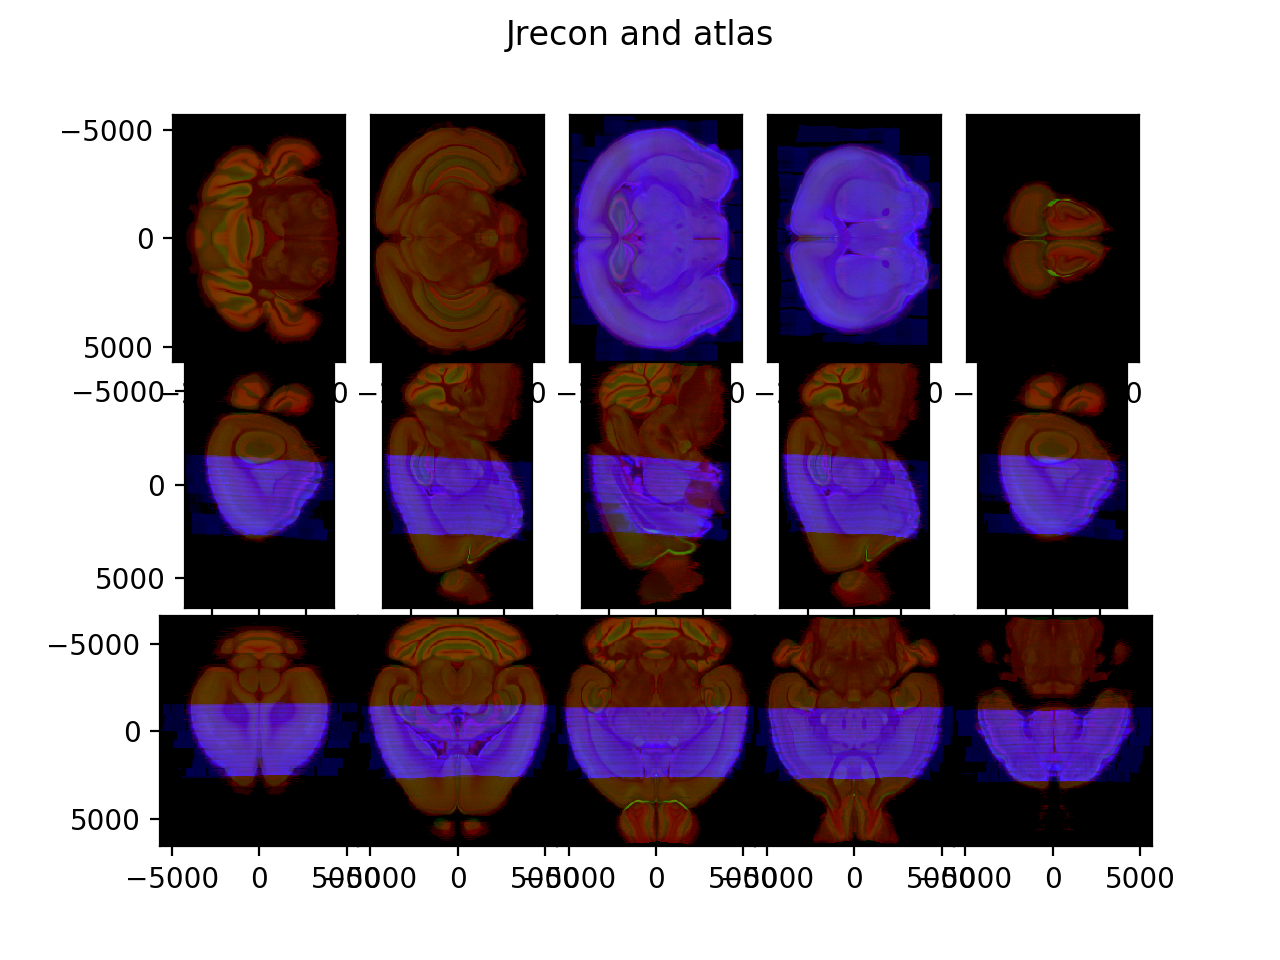

<IPython.core.display.Javascript object>


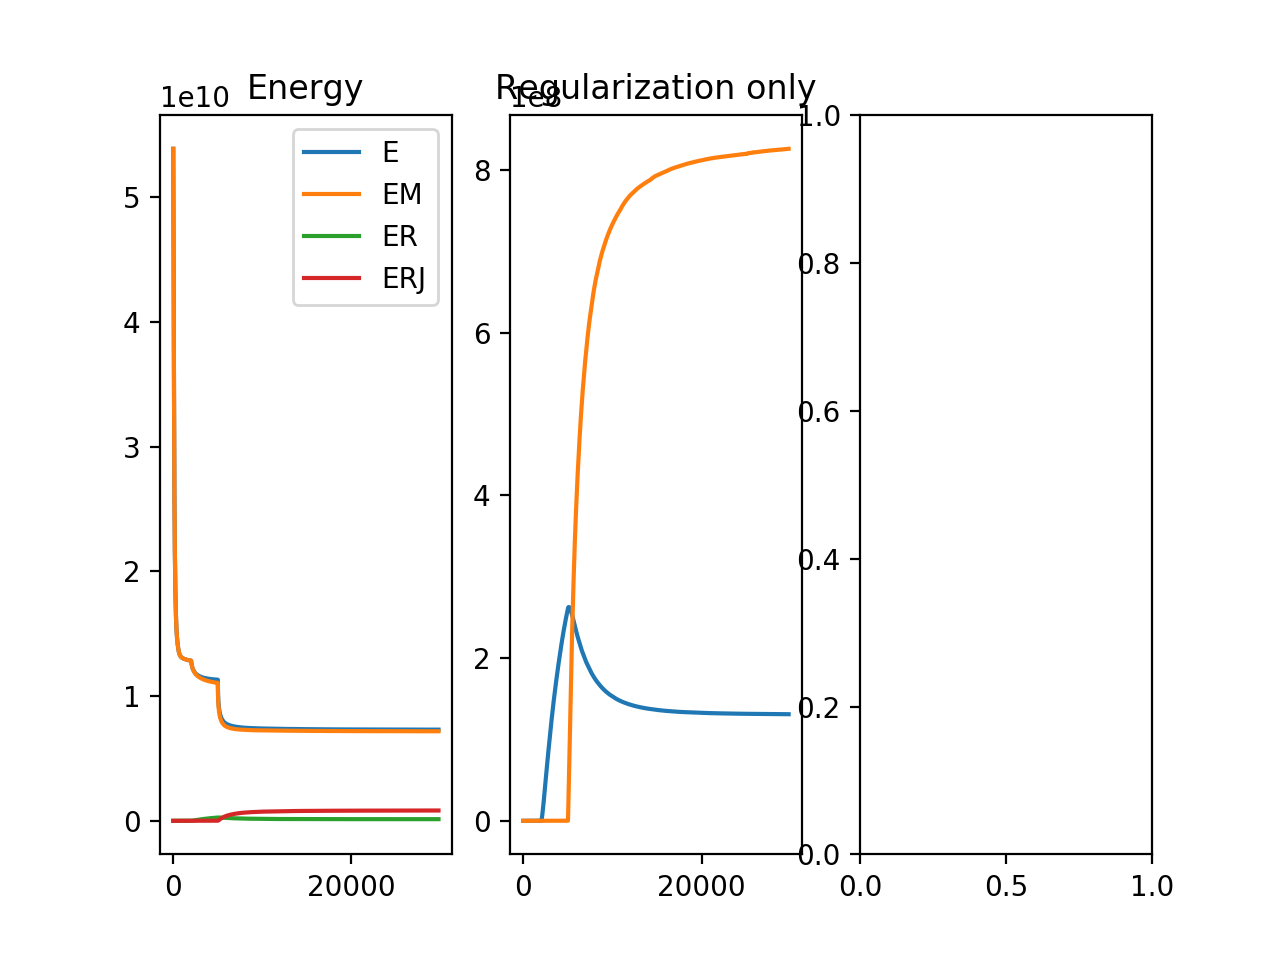

<IPython.core.display.Javascript object>


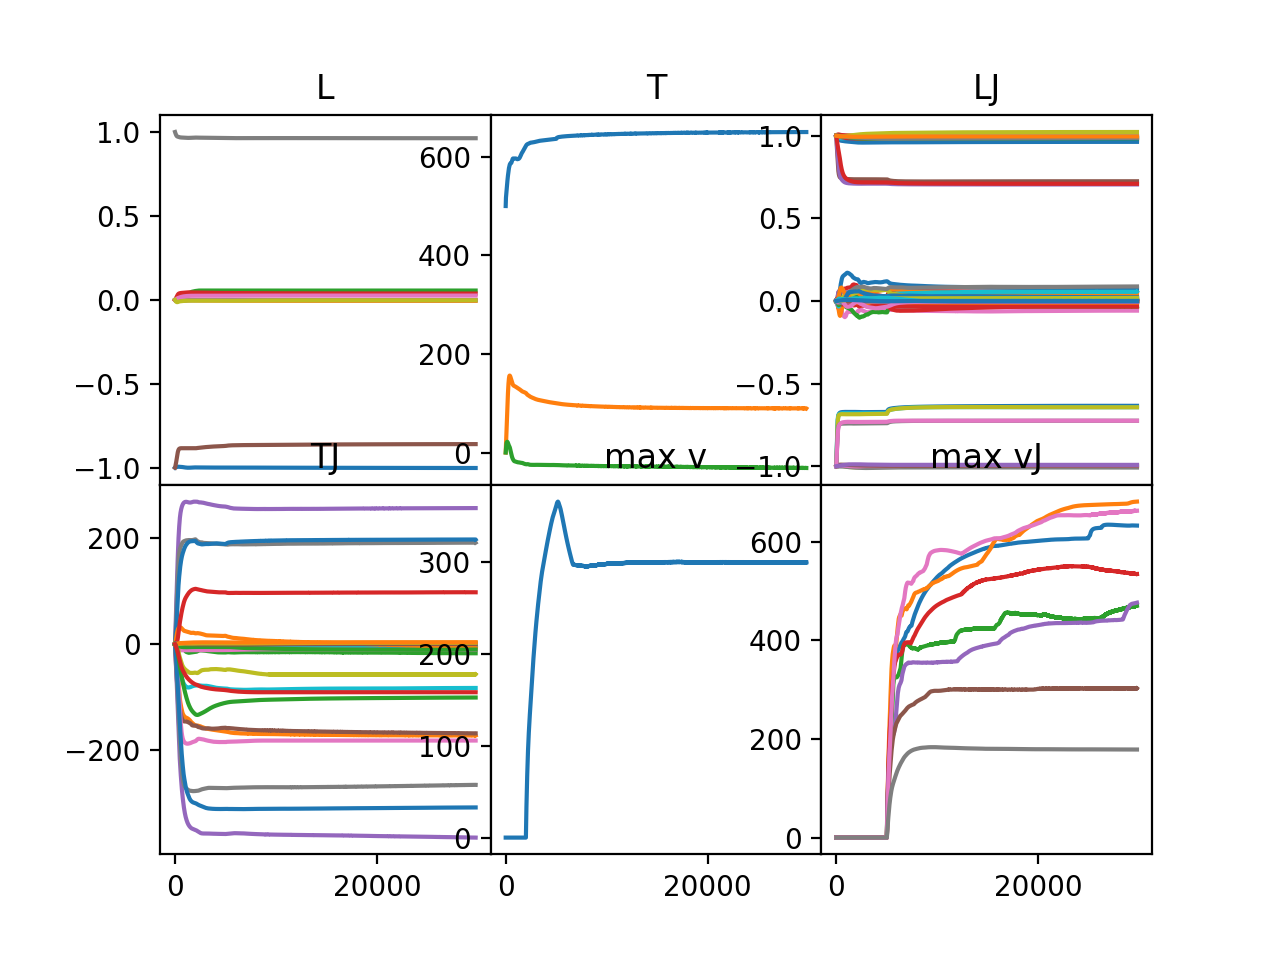

[W Copy.cpp:244] Warning: Casting complex values to real discards the imaginary part (function operator())
/home/dtward/data/csh_data/emlddmm/emlddmm.py:96: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


4294967296 4294967296
4294967296 4294967296
drawing took 6.070309400558472 s
Finished it 0 (7.252446174621582 s), E: 53902658000.45101
4294967296 4294967296
4294967296 4294967296
drawing took 8.010086059570312 s
Finished it 1 (9.085649490356445 s), E: 53588102314.20694
Finished it 2 (0.2381589412689209 s), E: 53281675670.23351
Finished it 3 (0.230452299118042 s), E: 52983721197.60759
Finished it 4 (0.21520185470581055 s), E: 52693777397.83432
Finished it 5 (0.23598861694335938 s), E: 52410940936.71863
Finished it 6 (0.22675609588623047 s), E: 52134410838.03258
4294967296 4294967296
4294967296 4294967296
drawing took 8.43097472190857 s
Finished it 7 (9.506318807601929 s), E: 51863871996.07728
Finished it 8 (0.23486995697021484 s), E: 51599400082.77016
Finished it 9 (0.20639753341674805 s), E: 51340471217.96566
Finished it 10 (0.20955944061279297 s), E: 51085651670.91672
Finished it 11 (0.2131941318511963 s), E: 50834363701.53543
Finished it 12 (0.23615193367004395 s), E: 50586563587.024

Finished it 125 (0.22054266929626465 s), E: 26760129246.620758
Finished it 126 (0.23879647254943848 s), E: 26622084122.787247
4294967296 4294967296
4294967296 4294967296
drawing took 8.494616746902466 s
Finished it 127 (9.619130611419678 s), E: 26485417256.752426
Finished it 128 (0.2604329586029053 s), E: 26350268565.22448
Finished it 129 (0.23332691192626953 s), E: 26216849549.104774
Finished it 130 (0.2679460048675537 s), E: 26085628036.008804
Finished it 131 (0.21801161766052246 s), E: 25956190081.66479
Finished it 132 (0.23261332511901855 s), E: 25828546954.18771
Finished it 133 (0.2361900806427002 s), E: 25704384220.545563
Finished it 134 (0.23883271217346191 s), E: 25583211114.795853
Finished it 135 (0.21894240379333496 s), E: 25465261348.467606
Finished it 136 (0.2250986099243164 s), E: 25349944718.651558
Finished it 137 (0.23880791664123535 s), E: 25236754717.08042
Finished it 138 (0.23589253425598145 s), E: 25125435158.31019
Finished it 139 (0.2188127040863037 s), E: 250161647

Finished it 252 (0.21830153465270996 s), E: 17928708569.104527
Finished it 253 (0.23031115531921387 s), E: 17891649999.681236
Finished it 254 (0.21847820281982422 s), E: 17855000150.005257
Finished it 255 (0.22428631782531738 s), E: 17818840220.48459
Finished it 256 (0.22301745414733887 s), E: 17782827694.411728
Finished it 257 (0.22206950187683105 s), E: 17747040757.784313
Finished it 258 (0.22499918937683105 s), E: 17711720382.930573
Finished it 259 (0.21242856979370117 s), E: 17676594180.873913
Finished it 260 (0.21758770942687988 s), E: 17641729765.40902
Finished it 261 (0.23147106170654297 s), E: 17607189701.131363
Finished it 262 (0.2202744483947754 s), E: 17573056600.386063
Finished it 263 (0.22996902465820312 s), E: 17539197945.229248
Finished it 264 (0.2235257625579834 s), E: 17505708579.21653
Finished it 265 (0.2139143943786621 s), E: 17472736048.749973
Finished it 266 (0.21904373168945312 s), E: 17440278455.08523
Finished it 267 (0.2518324851989746 s), E: 17408125612.534386


Finished it 381 (0.2221217155456543 s), E: 15093861065.66394
Finished it 382 (0.22433090209960938 s), E: 15082210638.86313
Finished it 383 (0.22724604606628418 s), E: 15070695306.697344
Finished it 384 (0.2253255844116211 s), E: 15059262617.476236
Finished it 385 (0.2324528694152832 s), E: 15047866810.89864
Finished it 386 (0.23816847801208496 s), E: 15036529269.327896
Finished it 387 (0.24494075775146484 s), E: 15025313128.824753
Finished it 388 (0.2218341827392578 s), E: 15014237790.368336
Finished it 389 (0.2350618839263916 s), E: 15003270512.814692
Finished it 390 (0.24479246139526367 s), E: 14992400347.08847
4294967296 4294967296
4294967296 4294967296
drawing took 8.711289405822754 s
Finished it 391 (9.880751609802246 s), E: 14981570884.574064
Finished it 392 (0.26511263847351074 s), E: 14970813960.490288
Finished it 393 (0.22180581092834473 s), E: 14960160820.93234
Finished it 394 (0.2143397331237793 s), E: 14949639071.85145
Finished it 395 (0.2277204990386963 s), E: 14939205815.

Finished it 510 (0.22726798057556152 s), E: 14068831006.492834
4294967296 4294967296
4294967296 4294967296
drawing took 8.802931070327759 s
Finished it 511 (9.963436603546143 s), E: 14063263528.972282
Finished it 512 (0.24694538116455078 s), E: 14057703335.661366
Finished it 513 (0.2177410125732422 s), E: 14052159573.215502
Finished it 514 (0.23059701919555664 s), E: 14046624657.087797
Finished it 515 (0.21386194229125977 s), E: 14041113592.209888
Finished it 516 (0.21595120429992676 s), E: 14035628797.88533
Finished it 517 (0.22971320152282715 s), E: 14030165001.695293
Finished it 518 (0.21934080123901367 s), E: 14024724533.709549
Finished it 519 (0.22211360931396484 s), E: 14019307768.1185
Finished it 520 (0.22643399238586426 s), E: 14013924712.1357
Finished it 521 (0.21463227272033691 s), E: 14008567493.285103
Finished it 522 (0.2346973419189453 s), E: 14003237225.869583
Finished it 523 (0.25783753395080566 s), E: 13997939651.47273
Finished it 524 (0.2285785675048828 s), E: 13992669

Finished it 639 (0.23570036888122559 s), E: 13512277924.03703
Finished it 640 (0.23044562339782715 s), E: 13509132118.863228
Finished it 641 (0.24349188804626465 s), E: 13506014361.23677
Finished it 642 (0.21076440811157227 s), E: 13502926142.978325
Finished it 643 (0.23675084114074707 s), E: 13499869639.639307
Finished it 644 (0.23276782035827637 s), E: 13496823318.900124
Finished it 645 (0.2330336570739746 s), E: 13493795242.402882
Finished it 646 (0.2375624179840088 s), E: 13490781760.528776
4294967296 4294967296
4294967296 4294967296
drawing took 6.829767942428589 s
Finished it 647 (7.977951526641846 s), E: 13487785017.18699
Finished it 648 (0.25217747688293457 s), E: 13484806164.812422
Finished it 649 (0.21059656143188477 s), E: 13481851557.695423
Finished it 650 (0.24112534523010254 s), E: 13478925534.336195
Finished it 651 (0.2189188003540039 s), E: 13476025568.762169
Finished it 652 (0.2215101718902588 s), E: 13473144167.732107
Finished it 653 (0.21031999588012695 s), E: 134702

Finished it 768 (0.2164897918701172 s), E: 13249845112.924635
Finished it 769 (0.2309708595275879 s), E: 13248507590.815174
Finished it 770 (0.251262903213501 s), E: 13247177696.520538
Finished it 771 (0.24009418487548828 s), E: 13245856708.458126
Finished it 772 (0.2195415496826172 s), E: 13244545928.679138
Finished it 773 (0.22969603538513184 s), E: 13243244805.743942
Finished it 774 (0.2224414348602295 s), E: 13241948271.54354
Finished it 775 (0.23644328117370605 s), E: 13240660446.855553
Finished it 776 (0.21835660934448242 s), E: 13239378980.801235
Finished it 777 (0.21476125717163086 s), E: 13238108154.27998
Finished it 778 (0.24182605743408203 s), E: 13236844275.247662
Finished it 779 (0.2602827548980713 s), E: 13235585906.639368
Finished it 780 (0.2481224536895752 s), E: 13234331582.528864
Finished it 781 (0.21779656410217285 s), E: 13233086979.354797
Finished it 782 (0.24940729141235352 s), E: 13231853405.000587
Finished it 783 (0.24043846130371094 s), E: 13230630510.498798
Fi

Finished it 897 (0.22646307945251465 s), E: 13127439747.219051
Finished it 898 (0.21916747093200684 s), E: 13126778190.23094
Finished it 899 (0.20824146270751953 s), E: 13126120700.969528
Finished it 900 (0.22136807441711426 s), E: 13125467133.968784
Finished it 901 (0.21123623847961426 s), E: 13124818231.69366
Finished it 902 (0.24251818656921387 s), E: 13124171126.413681
Finished it 903 (0.22529053688049316 s), E: 13123526829.472067
Finished it 904 (0.20938801765441895 s), E: 13122884842.080763
Finished it 905 (0.20920872688293457 s), E: 13122245381.27953
Finished it 906 (0.2067122459411621 s), E: 13121607440.902407
Finished it 907 (0.22858643531799316 s), E: 13120970718.779694
Finished it 908 (0.21920037269592285 s), E: 13120333638.22805
Finished it 909 (0.21426773071289062 s), E: 13119698415.23923
Finished it 910 (0.20870184898376465 s), E: 13119064452.54787
Finished it 911 (0.21321654319763184 s), E: 13118434901.177341
Finished it 912 (0.2405996322631836 s), E: 13117808595.679691


Finished it 1027 (0.2406294345855713 s), E: 13054685868.451927
Finished it 1028 (0.2508077621459961 s), E: 13054236867.870676
Finished it 1029 (0.2332308292388916 s), E: 13053789718.95325
Finished it 1030 (0.23694109916687012 s), E: 13053345139.063046
Finished it 1031 (0.24896955490112305 s), E: 13052902067.330406
Finished it 1032 (0.23476147651672363 s), E: 13052460313.932941
Finished it 1033 (0.23032641410827637 s), E: 13052020967.033865
Finished it 1034 (0.24161291122436523 s), E: 13051582903.690292
Finished it 1035 (0.2149801254272461 s), E: 13051146176.974508
Finished it 1036 (0.21913909912109375 s), E: 13050710830.671503
Finished it 1037 (0.24605464935302734 s), E: 13050275835.938393
Finished it 1038 (0.24396109580993652 s), E: 13049842421.51211
Finished it 1039 (0.21513915061950684 s), E: 13049409060.753887
Finished it 1040 (0.2116091251373291 s), E: 13048975979.462479
Finished it 1041 (0.21135616302490234 s), E: 13048545587.523455
Finished it 1042 (0.21621274948120117 s), E: 13

Finished it 1154 (0.2196063995361328 s), E: 13008906830.933228
Finished it 1155 (0.21499085426330566 s), E: 13008615073.99718
Finished it 1156 (0.21934103965759277 s), E: 13008324694.130905
Finished it 1157 (0.22094058990478516 s), E: 13008034463.383707
Finished it 1158 (0.24848556518554688 s), E: 13007745251.011051
Finished it 1159 (0.23888921737670898 s), E: 13007458261.406584
Finished it 1160 (0.24048233032226562 s), E: 13007172030.977926
Finished it 1161 (0.2104346752166748 s), E: 13006886671.27198
Finished it 1162 (0.22603416442871094 s), E: 13006601383.692492
Finished it 1163 (0.2338697910308838 s), E: 13006316469.310665
Finished it 1164 (0.2409369945526123 s), E: 13006031854.670664
Finished it 1165 (0.2066328525543213 s), E: 13005746629.582764
Finished it 1166 (0.20781683921813965 s), E: 13005459103.156206
Finished it 1167 (0.2054893970489502 s), E: 13005171191.873182
Finished it 1168 (0.20595741271972656 s), E: 13004882551.882713
Finished it 1169 (0.2143094539642334 s), E: 1300

Finished it 1282 (0.22117137908935547 s), E: 12975434812.520542
Finished it 1283 (0.21406078338623047 s), E: 12975215413.336721
Finished it 1284 (0.21435832977294922 s), E: 12974997569.167091
Finished it 1285 (0.21567893028259277 s), E: 12974780904.804615
Finished it 1286 (0.23631978034973145 s), E: 12974565022.925848
Finished it 1287 (0.2501518726348877 s), E: 12974349800.120045
Finished it 1288 (0.23572516441345215 s), E: 12974135850.285673
Finished it 1289 (0.22979998588562012 s), E: 12973922124.02436
Finished it 1290 (0.2173621654510498 s), E: 12973708013.616795
Finished it 1291 (0.21826457977294922 s), E: 12973495189.084557
Finished it 1292 (0.23824000358581543 s), E: 12973282622.701782
Finished it 1293 (0.2426609992980957 s), E: 12973070889.021088
Finished it 1294 (0.23016142845153809 s), E: 12972859586.019669
Finished it 1295 (0.2202768325805664 s), E: 12972648470.017141
Finished it 1296 (0.23122048377990723 s), E: 12972438239.884445
Finished it 1297 (0.22061586380004883 s), E: 

Finished it 1410 (0.2130875587463379 s), E: 12946994585.051783
Finished it 1411 (0.21014404296875 s), E: 12946747478.731571
Finished it 1412 (0.22393035888671875 s), E: 12946496977.109386
Finished it 1413 (0.2330927848815918 s), E: 12946243647.292692
Finished it 1414 (0.23929643630981445 s), E: 12945990526.334885
Finished it 1415 (0.23480963706970215 s), E: 12945740510.72746
Finished it 1416 (0.23836708068847656 s), E: 12945489313.869495
Finished it 1417 (0.23658084869384766 s), E: 12945237629.909485
Finished it 1418 (0.23612403869628906 s), E: 12944988203.499859
Finished it 1419 (0.25165629386901855 s), E: 12944740091.281168
Finished it 1420 (0.25656843185424805 s), E: 12944490187.303822
Finished it 1421 (0.2094268798828125 s), E: 12944235876.509098
Finished it 1422 (0.23067235946655273 s), E: 12943974502.747335
Finished it 1423 (0.2291409969329834 s), E: 12943708667.072346
Finished it 1424 (0.2187345027923584 s), E: 12943437924.395267
Finished it 1425 (0.22712087631225586 s), E: 1294

Finished it 1538 (0.23027324676513672 s), E: 12909593626.416
Finished it 1539 (0.22826361656188965 s), E: 12909320366.744503
Finished it 1540 (0.21361613273620605 s), E: 12909052876.121529
Finished it 1541 (0.21992254257202148 s), E: 12908788308.850035
Finished it 1542 (0.24282193183898926 s), E: 12908521016.063168
Finished it 1543 (0.23311567306518555 s), E: 12908247447.22063
Finished it 1544 (0.21693921089172363 s), E: 12907971729.949081
Finished it 1545 (0.23152613639831543 s), E: 12907705539.959171
Finished it 1546 (0.24057340621948242 s), E: 12907451706.130293
Finished it 1547 (0.24277472496032715 s), E: 12907207318.76166
Finished it 1548 (0.22707295417785645 s), E: 12906965149.554216
Finished it 1549 (0.21863961219787598 s), E: 12906724522.624552
Finished it 1550 (0.21863722801208496 s), E: 12906484410.345379
Finished it 1551 (0.23628497123718262 s), E: 12906247074.632483
Finished it 1552 (0.21387338638305664 s), E: 12906010731.39621
Finished it 1553 (0.23795056343078613 s), E: 1

Finished it 1666 (0.23788094520568848 s), E: 12888472456.219198
Finished it 1667 (0.2443983554840088 s), E: 12888343976.95223
Finished it 1668 (0.23983383178710938 s), E: 12888215349.020123
Finished it 1669 (0.22475385665893555 s), E: 12888083875.642445
Finished it 1670 (0.23110270500183105 s), E: 12887948812.883764
Finished it 1671 (0.23281645774841309 s), E: 12887811356.20387
Finished it 1672 (0.21960663795471191 s), E: 12887673182.565514
Finished it 1673 (0.23186779022216797 s), E: 12887532053.44341
Finished it 1674 (0.21919488906860352 s), E: 12887389247.89551
Finished it 1675 (0.23949861526489258 s), E: 12887243135.383411
Finished it 1676 (0.21807312965393066 s), E: 12887096362.38436
Finished it 1677 (0.21275115013122559 s), E: 12886952899.872593
Finished it 1678 (0.22332167625427246 s), E: 12886811977.155052
Finished it 1679 (0.2316761016845703 s), E: 12886672925.999853
Finished it 1680 (0.2361466884613037 s), E: 12886532175.23263
4294967296 4294967296
4294967296 4294967296
drawi

Finished it 1794 (0.21924066543579102 s), E: 12873143158.666222
Finished it 1795 (0.21350550651550293 s), E: 12873045623.787569
Finished it 1796 (0.21639204025268555 s), E: 12872948697.009007
Finished it 1797 (0.23991084098815918 s), E: 12872852009.020996
Finished it 1798 (0.2185366153717041 s), E: 12872756165.260893
4294967296 4294967296
4294967296 4294967296
drawing took 7.238163232803345 s
Finished it 1799 (8.449323177337646 s), E: 12872661081.279526
Finished it 1800 (0.2449486255645752 s), E: 12872565629.394184
Finished it 1801 (0.21383166313171387 s), E: 12872472330.821579
Finished it 1802 (0.20728182792663574 s), E: 12872378326.198997
Finished it 1803 (0.21211528778076172 s), E: 12872284686.18319
Finished it 1804 (0.22050070762634277 s), E: 12872191018.249542
Finished it 1805 (0.20412707328796387 s), E: 12872095647.664343
Finished it 1806 (0.21203970909118652 s), E: 12872000795.838446
Finished it 1807 (0.2207660675048828 s), E: 12871904297.279945
Finished it 1808 (0.2108407020568

Finished it 1922 (0.23927593231201172 s), E: 12860247643.04327
Finished it 1923 (0.20474863052368164 s), E: 12860132543.178856
Finished it 1924 (0.21625661849975586 s), E: 12860018160.253256
Finished it 1925 (0.20516180992126465 s), E: 12859904595.480745
Finished it 1926 (0.20592069625854492 s), E: 12859791399.293291
Finished it 1927 (0.2054593563079834 s), E: 12859676398.160568
Finished it 1928 (0.20596814155578613 s), E: 12859560380.63636
Finished it 1929 (0.2054424285888672 s), E: 12859446597.137384
Finished it 1930 (0.20445847511291504 s), E: 12859336759.360744
Finished it 1931 (0.2059330940246582 s), E: 12859228279.526602
Finished it 1932 (0.20670652389526367 s), E: 12859119048.946362
Finished it 1933 (0.21955275535583496 s), E: 12859010262.940771
Finished it 1934 (0.20702910423278809 s), E: 12858902543.238907
Finished it 1935 (0.21504473686218262 s), E: 12858796385.283216
Finished it 1936 (0.2067859172821045 s), E: 12858691811.95147
Finished it 1937 (0.2055981159210205 s), E: 128

Finished it 2050 (0.21463489532470703 s), E: 12590458787.688843
Finished it 2051 (0.23200702667236328 s), E: 12586134153.993282
Finished it 2052 (0.21913409233093262 s), E: 12581824107.974012
Finished it 2053 (0.21444129943847656 s), E: 12577549433.294064
Finished it 2054 (0.21676278114318848 s), E: 12573320358.33668
Finished it 2055 (0.21506619453430176 s), E: 12569126622.78204
Finished it 2056 (0.22413229942321777 s), E: 12564952474.892593
Finished it 2057 (0.22284460067749023 s), E: 12560805180.792639
Finished it 2058 (0.2156386375427246 s), E: 12556682138.993065
Finished it 2059 (0.21547555923461914 s), E: 12552594867.96907
Finished it 2060 (0.21636056900024414 s), E: 12548545143.649244
Finished it 2061 (0.2052767276763916 s), E: 12544509369.255516
Finished it 2062 (0.21652936935424805 s), E: 12540471811.271381
Finished it 2063 (0.2159106731414795 s), E: 12536460154.688366
Finished it 2064 (0.20328879356384277 s), E: 12532474838.353867
Finished it 2065 (0.22612857818603516 s), E: 1

Finished it 2178 (0.25242018699645996 s), E: 12217737300.575548
Finished it 2179 (0.21539521217346191 s), E: 12215865906.490608
Finished it 2180 (0.21563482284545898 s), E: 12213999628.322037
Finished it 2181 (0.22960662841796875 s), E: 12212142443.44638
Finished it 2182 (0.21884369850158691 s), E: 12210286532.20963
Finished it 2183 (0.21593403816223145 s), E: 12208434524.72256
Finished it 2184 (0.2172706127166748 s), E: 12206586922.17847
Finished it 2185 (0.21470904350280762 s), E: 12204744462.101263
Finished it 2186 (0.21309232711791992 s), E: 12202906490.502758
Finished it 2187 (0.21671748161315918 s), E: 12201079763.208092
Finished it 2188 (0.21445679664611816 s), E: 12199263533.194193
Finished it 2189 (0.21566271781921387 s), E: 12197451682.40292
Finished it 2190 (0.21512985229492188 s), E: 12195648443.948145
Finished it 2191 (0.21425819396972656 s), E: 12193853219.05576
Finished it 2192 (0.21677708625793457 s), E: 12192064269.195665
Finished it 2193 (0.2223033905029297 s), E: 121

Finished it 2308 (0.21786761283874512 s), E: 12020813947.16804
Finished it 2309 (0.21838688850402832 s), E: 12019520567.720217
Finished it 2310 (0.2203211784362793 s), E: 12018229170.04433
4294967296 4294967296
4294967296 4294967296
drawing took 6.393702030181885 s
Finished it 2311 (7.494204759597778 s), E: 12016943543.097916
Finished it 2312 (0.24365663528442383 s), E: 12015661911.33136
Finished it 2313 (0.21410202980041504 s), E: 12014384360.70988
Finished it 2314 (0.22842073440551758 s), E: 12013109496.707302
Finished it 2315 (0.21432209014892578 s), E: 12011837105.839241
Finished it 2316 (0.20839405059814453 s), E: 12010570476.050148
Finished it 2317 (0.21960735321044922 s), E: 12009306122.439213
Finished it 2318 (0.21564078330993652 s), E: 12008047373.822414
Finished it 2319 (0.21883344650268555 s), E: 12006791978.103275
Finished it 2320 (0.2192533016204834 s), E: 12005537303.56451
Finished it 2321 (0.20608162879943848 s), E: 12004286519.693436
Finished it 2322 (0.2165122032165527

Finished it 2436 (0.22094035148620605 s), E: 11878920392.06374
Finished it 2437 (0.20368504524230957 s), E: 11877978984.856634
Finished it 2438 (0.2230992317199707 s), E: 11877040713.97447
Finished it 2439 (0.22981047630310059 s), E: 11876105057.902351
Finished it 2440 (0.2261970043182373 s), E: 11875172243.792347
Finished it 2441 (0.22397303581237793 s), E: 11874245957.594582
Finished it 2442 (0.21535634994506836 s), E: 11873322072.25809
Finished it 2443 (0.21935319900512695 s), E: 11872400981.653118
Finished it 2444 (0.21503520011901855 s), E: 11871485251.390882
Finished it 2445 (0.2081904411315918 s), E: 11870573980.232586
Finished it 2446 (0.20518088340759277 s), E: 11869665822.306376
Finished it 2447 (0.20754790306091309 s), E: 11868761280.090906
Finished it 2448 (0.2216942310333252 s), E: 11867859013.988386
4294967296 4294967296
4294967296 4294967296
drawing took 6.046411991119385 s
Finished it 2449 (7.148668527603149 s), E: 11866958757.595978
Finished it 2450 (0.2395362854003906

Finished it 2565 (0.21874165534973145 s), E: 11777217956.186142
Finished it 2566 (0.21955323219299316 s), E: 11776543433.608759
Finished it 2567 (0.22522616386413574 s), E: 11775871206.051247
Finished it 2568 (0.2304062843322754 s), E: 11775200126.342083
Finished it 2569 (0.22322607040405273 s), E: 11774529560.830318
Finished it 2570 (0.21785879135131836 s), E: 11773858550.33659
Finished it 2571 (0.21321892738342285 s), E: 11773187335.190662
Finished it 2572 (0.23588848114013672 s), E: 11772518670.728775
Finished it 2573 (0.22603416442871094 s), E: 11771850357.996498
Finished it 2574 (0.23117876052856445 s), E: 11771183140.62425
Finished it 2575 (0.21950793266296387 s), E: 11770517901.988058
Finished it 2576 (0.22429180145263672 s), E: 11769852911.895512
Finished it 2577 (0.2273874282836914 s), E: 11769190579.946379
Finished it 2578 (0.2308046817779541 s), E: 11768529427.561926
Finished it 2579 (0.22598552703857422 s), E: 11767869529.073002
Finished it 2580 (0.22946548461914062 s), E: 

Finished it 2693 (0.2302415370941162 s), E: 11703594238.42274
Finished it 2694 (0.21653127670288086 s), E: 11703099118.229395
Finished it 2695 (0.21804594993591309 s), E: 11702604282.830076
Finished it 2696 (0.21205806732177734 s), E: 11702109751.805103
Finished it 2697 (0.20996451377868652 s), E: 11701616374.999344
Finished it 2698 (0.20548796653747559 s), E: 11701124117.026047
Finished it 2699 (0.209092378616333 s), E: 11700632779.13178
Finished it 2700 (0.23523855209350586 s), E: 11700143524.510479
Finished it 2701 (0.21657514572143555 s), E: 11699654763.835566
Finished it 2702 (0.2250666618347168 s), E: 11699166350.523949
Finished it 2703 (0.21469879150390625 s), E: 11698677721.118784
Finished it 2704 (0.20850539207458496 s), E: 11698189461.494143
Finished it 2705 (0.21305513381958008 s), E: 11697702562.439404
Finished it 2706 (0.20541596412658691 s), E: 11697216695.209467
Finished it 2707 (0.21958184242248535 s), E: 11696731849.325308
Finished it 2708 (0.22766351699829102 s), E: 1

Finished it 2821 (0.23211407661437988 s), E: 11646323725.799473
Finished it 2822 (0.22370028495788574 s), E: 11645919005.987257
Finished it 2823 (0.22083735466003418 s), E: 11645514535.54908
Finished it 2824 (0.22998046875 s), E: 11645111296.262142
Finished it 2825 (0.21814393997192383 s), E: 11644708117.66738
Finished it 2826 (0.2172694206237793 s), E: 11644305197.313662
Finished it 2827 (0.22426867485046387 s), E: 11643902813.539848
Finished it 2828 (0.22682452201843262 s), E: 11643500837.5324
Finished it 2829 (0.22889471054077148 s), E: 11643099031.10485
Finished it 2830 (0.2188563346862793 s), E: 11642697635.77285
Finished it 2831 (0.2253410816192627 s), E: 11642297107.022902
Finished it 2832 (0.22852611541748047 s), E: 11641896766.858032
Finished it 2833 (0.22478079795837402 s), E: 11641495544.683975
Finished it 2834 (0.22119617462158203 s), E: 11641095544.974384
Finished it 2835 (0.22981691360473633 s), E: 11640697044.453236
Finished it 2836 (0.21913719177246094 s), E: 1164029955

Finished it 2949 (0.22062110900878906 s), E: 11597494622.530973
Finished it 2950 (0.2168738842010498 s), E: 11597136040.333326
Finished it 2951 (0.22296762466430664 s), E: 11596777685.92075
Finished it 2952 (0.23355650901794434 s), E: 11596420167.869658
Finished it 2953 (0.21768498420715332 s), E: 11596064043.280014
Finished it 2954 (0.21573805809020996 s), E: 11595709384.713947
Finished it 2955 (0.21967077255249023 s), E: 11595355846.745056
Finished it 2956 (0.2215416431427002 s), E: 11595002352.91499
Finished it 2957 (0.22087407112121582 s), E: 11594649327.314705
Finished it 2958 (0.21840238571166992 s), E: 11594296123.846684
Finished it 2959 (0.21659159660339355 s), E: 11593942595.037964
Finished it 2960 (0.21998310089111328 s), E: 11593589013.401905
Finished it 2961 (0.21908235549926758 s), E: 11593234732.865612
Finished it 2962 (0.2173633575439453 s), E: 11592880524.657705
Finished it 2963 (0.22468066215515137 s), E: 11592525619.595306
Finished it 2964 (0.22124338150024414 s), E: 

Finished it 3077 (0.22022199630737305 s), E: 11555884290.092594
Finished it 3078 (0.21652674674987793 s), E: 11555590939.402054
Finished it 3079 (0.21648597717285156 s), E: 11555298000.217896
Finished it 3080 (0.21758103370666504 s), E: 11555005558.655895
Finished it 3081 (0.21545624732971191 s), E: 11554713077.970951
Finished it 3082 (0.2189936637878418 s), E: 11554421491.507215
Finished it 3083 (0.2175889015197754 s), E: 11554129873.70737
Finished it 3084 (0.2075061798095703 s), E: 11553839229.782839
Finished it 3085 (0.20621562004089355 s), E: 11553549197.646639
Finished it 3086 (0.2258298397064209 s), E: 11553259650.331238
Finished it 3087 (0.21913456916809082 s), E: 11552969933.603445
Finished it 3088 (0.21823859214782715 s), E: 11552681263.082653
Finished it 3089 (0.2285306453704834 s), E: 11552393642.45261
Finished it 3090 (0.21746587753295898 s), E: 11552106445.636904
Finished it 3091 (0.22035646438598633 s), E: 11551819992.847187
Finished it 3092 (0.21844768524169922 s), E: 11

Finished it 3205 (0.21953248977661133 s), E: 11521178459.391409
Finished it 3206 (0.2176663875579834 s), E: 11520929972.686312
Finished it 3207 (0.2144474983215332 s), E: 11520681744.052341
Finished it 3208 (0.21531319618225098 s), E: 11520433607.56336
Finished it 3209 (0.21486663818359375 s), E: 11520185565.1184
Finished it 3210 (0.21778345108032227 s), E: 11519937818.840658
Finished it 3211 (0.21478676795959473 s), E: 11519690257.999237
Finished it 3212 (0.21537089347839355 s), E: 11519442895.223667
Finished it 3213 (0.21535301208496094 s), E: 11519195779.649197
Finished it 3214 (0.21416687965393066 s), E: 11518948557.55892
Finished it 3215 (0.21667909622192383 s), E: 11518702271.284649
Finished it 3216 (0.21383428573608398 s), E: 11518457174.151466
Finished it 3217 (0.2157573699951172 s), E: 11518212702.432339
Finished it 3218 (0.22062230110168457 s), E: 11517968836.169338
Finished it 3219 (0.21685147285461426 s), E: 11517725264.220036
Finished it 3220 (0.21601057052612305 s), E: 11

Finished it 3334 (0.2300417423248291 s), E: 11491822015.83367
Finished it 3335 (0.21558380126953125 s), E: 11491611391.655922
Finished it 3336 (0.2161092758178711 s), E: 11491401253.171848
Finished it 3337 (0.222428560256958 s), E: 11491192037.002216
Finished it 3338 (0.22968649864196777 s), E: 11490982243.042854
Finished it 3339 (0.2221057415008545 s), E: 11490772301.005116
Finished it 3340 (0.21918058395385742 s), E: 11490561660.567371
Finished it 3341 (0.22272753715515137 s), E: 11490350953.966293
Finished it 3342 (0.22169828414916992 s), E: 11490140640.322712
Finished it 3343 (0.22972965240478516 s), E: 11489930961.330278
Finished it 3344 (0.21851420402526855 s), E: 11489721559.3325
Finished it 3345 (0.22124218940734863 s), E: 11489511945.116198
Finished it 3346 (0.22467303276062012 s), E: 11489302311.272682
Finished it 3347 (0.22207283973693848 s), E: 11489092596.79464
Finished it 3348 (0.2294018268585205 s), E: 11488883058.842388
Finished it 3349 (0.22196245193481445 s), E: 11488

Finished it 3462 (0.2166309356689453 s), E: 11466513241.048002
Finished it 3463 (0.22029542922973633 s), E: 11466330202.163136
Finished it 3464 (0.22278547286987305 s), E: 11466147250.199165
Finished it 3465 (0.2188434600830078 s), E: 11465964296.7869
Finished it 3466 (0.2201988697052002 s), E: 11465781705.56914
Finished it 3467 (0.2234029769897461 s), E: 11465599508.655272
Finished it 3468 (0.22377920150756836 s), E: 11465417175.816286
Finished it 3469 (0.2163684368133545 s), E: 11465235224.676126
Finished it 3470 (0.24702906608581543 s), E: 11465052826.868263
Finished it 3471 (0.23659706115722656 s), E: 11464870538.660599
Finished it 3472 (0.21626019477844238 s), E: 11464688766.146164
Finished it 3473 (0.21249032020568848 s), E: 11464507462.853716
Finished it 3474 (0.21498632431030273 s), E: 11464326851.462679
Finished it 3475 (0.2300243377685547 s), E: 11464146710.844893
Finished it 3476 (0.21161770820617676 s), E: 11463966636.244041
Finished it 3477 (0.22359347343444824 s), E: 1146

Finished it 3590 (0.2151777744293213 s), E: 11444585466.835344
Finished it 3591 (0.22017574310302734 s), E: 11444426145.268145
Finished it 3592 (0.2172846794128418 s), E: 11444267206.60524
Finished it 3593 (0.2252645492553711 s), E: 11444108556.731855
Finished it 3594 (0.2179577350616455 s), E: 11443950053.19743
Finished it 3595 (0.2183690071105957 s), E: 11443791440.413391
Finished it 3596 (0.21706175804138184 s), E: 11443632392.547039
Finished it 3597 (0.2195875644683838 s), E: 11443473706.509823
Finished it 3598 (0.22066116333007812 s), E: 11443315304.677273
Finished it 3599 (0.2177579402923584 s), E: 11443157280.40157
Finished it 3600 (0.2212066650390625 s), E: 11442999716.790688
Finished it 3601 (0.22192120552062988 s), E: 11442842185.508831
Finished it 3602 (0.21886539459228516 s), E: 11442684586.264713
Finished it 3603 (0.21673345565795898 s), E: 11442527136.489548
Finished it 3604 (0.21912145614624023 s), E: 11442370155.37108
Finished it 3605 (0.22704458236694336 s), E: 1144221

Finished it 3718 (0.22950458526611328 s), E: 11425462866.849012
Finished it 3719 (0.21992731094360352 s), E: 11425323323.800682
Finished it 3720 (0.21835708618164062 s), E: 11425184166.925758
Finished it 3721 (0.21529722213745117 s), E: 11425045215.695877
Finished it 3722 (0.21563720703125 s), E: 11424905968.660267
Finished it 3723 (0.21596050262451172 s), E: 11424766710.223999
Finished it 3724 (0.21757864952087402 s), E: 11424627705.151642
Finished it 3725 (0.2057056427001953 s), E: 11424489260.222855
Finished it 3726 (0.20362114906311035 s), E: 11424351161.21039
Finished it 3727 (0.21573781967163086 s), E: 11424213391.538818
Finished it 3728 (0.2177600860595703 s), E: 11424075518.002659
Finished it 3729 (0.2160937786102295 s), E: 11423937936.298344
Finished it 3730 (0.21636176109313965 s), E: 11423800716.087065
Finished it 3731 (0.2159712314605713 s), E: 11423663369.582142
Finished it 3732 (0.21992945671081543 s), E: 11423526256.38356
Finished it 3733 (0.21880388259887695 s), E: 1142

Finished it 3848 (0.22327375411987305 s), E: 11408727286.348034
Finished it 3849 (0.2185654640197754 s), E: 11408607884.410557
Finished it 3850 (0.23137235641479492 s), E: 11408488611.426075
Finished it 3851 (0.22286438941955566 s), E: 11408369664.26644
Finished it 3852 (0.22932982444763184 s), E: 11408250989.358824
Finished it 3853 (0.21654200553894043 s), E: 11408132738.939503
Finished it 3854 (0.2182941436767578 s), E: 11408014635.393509
Finished it 3855 (0.2236006259918213 s), E: 11407896584.133566
Finished it 3856 (0.22181415557861328 s), E: 11407778596.05714
Finished it 3857 (0.21639060974121094 s), E: 11407660727.948982
Finished it 3858 (0.20995330810546875 s), E: 11407542954.507442
Finished it 3859 (0.20753169059753418 s), E: 11407425183.594429
Finished it 3860 (0.21913909912109375 s), E: 11407307899.566988
Finished it 3861 (0.2186591625213623 s), E: 11407190877.557453
Finished it 3862 (0.21966242790222168 s), E: 11407073832.787718
Finished it 3863 (0.2203211784362793 s), E: 11

Finished it 3977 (0.21104693412780762 s), E: 11394029424.188004
Finished it 3978 (0.21757054328918457 s), E: 11393921332.393208
Finished it 3979 (0.2294328212738037 s), E: 11393813271.408361
Finished it 3980 (0.21566367149353027 s), E: 11393705284.036152
Finished it 3981 (0.22005677223205566 s), E: 11393597408.732395
Finished it 3982 (0.2230052947998047 s), E: 11393489659.591156
Finished it 3983 (0.22343182563781738 s), E: 11393381878.16314
Finished it 3984 (0.21700167655944824 s), E: 11393274157.205284
Finished it 3985 (0.22124600410461426 s), E: 11393166694.774647
Finished it 3986 (0.2204115390777588 s), E: 11393059231.910803
Finished it 3987 (0.23004722595214844 s), E: 11392951543.777668
Finished it 3988 (0.22170066833496094 s), E: 11392844021.656681
Finished it 3989 (0.2241973876953125 s), E: 11392736798.107756
Finished it 3990 (0.23259520530700684 s), E: 11392629557.61879
Finished it 3991 (0.23688936233520508 s), E: 11392522296.32664
Finished it 3992 (0.22577357292175293 s), E: 11

Finished it 4105 (0.21701717376708984 s), E: 11380825727.694828
Finished it 4106 (0.2228107452392578 s), E: 11380726635.43644
Finished it 4107 (0.22350406646728516 s), E: 11380627685.420162
Finished it 4108 (0.22712230682373047 s), E: 11380528879.154453
Finished it 4109 (0.2213575839996338 s), E: 11380430112.53009
Finished it 4110 (0.21987223625183105 s), E: 11380330910.253685
Finished it 4111 (0.2233448028564453 s), E: 11380231861.78033
Finished it 4112 (0.22493267059326172 s), E: 11380132954.053265
Finished it 4113 (0.2252974510192871 s), E: 11380034181.9558
Finished it 4114 (0.21778130531311035 s), E: 11379935657.711948
Finished it 4115 (0.22645235061645508 s), E: 11379837123.764458
Finished it 4116 (0.22752618789672852 s), E: 11379738437.065746
Finished it 4117 (0.21752238273620605 s), E: 11379639874.957296
Finished it 4118 (0.21910738945007324 s), E: 11379541491.739708
Finished it 4119 (0.21885037422180176 s), E: 11379443305.648617
Finished it 4120 (0.21735644340515137 s), E: 1137

Finished it 4233 (0.2210536003112793 s), E: 11368764349.583214
Finished it 4234 (0.21405601501464844 s), E: 11368675505.540154
Finished it 4235 (0.2071819305419922 s), E: 11368586768.68981
Finished it 4236 (0.21489810943603516 s), E: 11368498037.250116
Finished it 4237 (0.20679974555969238 s), E: 11368409287.79227
Finished it 4238 (0.20418596267700195 s), E: 11368320390.869377
Finished it 4239 (0.20382475852966309 s), E: 11368231675.310963
Finished it 4240 (0.20540976524353027 s), E: 11368142859.296751
Finished it 4241 (0.2039031982421875 s), E: 11368054162.386469
Finished it 4242 (0.20427465438842773 s), E: 11367965637.958187
Finished it 4243 (0.2034471035003662 s), E: 11367877268.589369
Finished it 4244 (0.21904563903808594 s), E: 11367788901.534561
Finished it 4245 (0.22003483772277832 s), E: 11367700543.261272
Finished it 4246 (0.21220111846923828 s), E: 11367612747.352242
Finished it 4247 (0.21017980575561523 s), E: 11367524967.838566
Finished it 4248 (0.21451187133789062 s), E: 1

Finished it 4362 (0.22213983535766602 s), E: 11357928835.071392
Finished it 4363 (0.2209029197692871 s), E: 11357850424.230488
Finished it 4364 (0.22302675247192383 s), E: 11357772144.903698
Finished it 4365 (0.21792340278625488 s), E: 11357693827.636124
Finished it 4366 (0.22702598571777344 s), E: 11357615383.77062
Finished it 4367 (0.22659778594970703 s), E: 11357537094.473034
Finished it 4368 (0.21686315536499023 s), E: 11357458759.598633
Finished it 4369 (0.21815848350524902 s), E: 11357380571.446363
Finished it 4370 (0.2220311164855957 s), E: 11357302688.51096
Finished it 4371 (0.22522664070129395 s), E: 11357225080.701523
Finished it 4372 (0.22148442268371582 s), E: 11357147461.186169
Finished it 4373 (0.2237391471862793 s), E: 11357069698.616898
Finished it 4374 (0.22166204452514648 s), E: 11356992035.064522
Finished it 4375 (0.22059297561645508 s), E: 11356914475.30269
Finished it 4376 (0.22954058647155762 s), E: 11356837041.217009
Finished it 4377 (0.2371354103088379 s), E: 11

Finished it 4490 (0.22306251525878906 s), E: 11348589067.058357
Finished it 4491 (0.22171640396118164 s), E: 11348520480.56431
Finished it 4492 (0.2304670810699463 s), E: 11348451937.86766
Finished it 4493 (0.21900701522827148 s), E: 11348383413.355747
Finished it 4494 (0.2224433422088623 s), E: 11348315034.381191
Finished it 4495 (0.22142910957336426 s), E: 11348246712.542007
Finished it 4496 (0.22081351280212402 s), E: 11348178334.294714
Finished it 4497 (0.22071242332458496 s), E: 11348109908.600447
Finished it 4498 (0.22175908088684082 s), E: 11348041431.753523
Finished it 4499 (0.2237088680267334 s), E: 11347973002.653984
Finished it 4500 (0.21817660331726074 s), E: 11347904437.178314
Finished it 4501 (0.22142934799194336 s), E: 11347835815.91625
Finished it 4502 (0.23053956031799316 s), E: 11347767261.358017
Finished it 4503 (0.21834564208984375 s), E: 11347698920.462078
Finished it 4504 (0.22346925735473633 s), E: 11347630783.716206
Finished it 4505 (0.2254335880279541 s), E: 11

Finished it 4618 (0.225114107131958 s), E: 11340279161.561386
Finished it 4619 (0.22421932220458984 s), E: 11340218396.50467
Finished it 4620 (0.2169802188873291 s), E: 11340157733.17933
Finished it 4621 (0.20727992057800293 s), E: 11340097083.386482
Finished it 4622 (0.20546889305114746 s), E: 11340036402.93552
Finished it 4623 (0.22051429748535156 s), E: 11339975775.735422
Finished it 4624 (0.21738100051879883 s), E: 11339915216.536444
Finished it 4625 (0.21660065650939941 s), E: 11339854654.54197
Finished it 4626 (0.22089934349060059 s), E: 11339794143.715263
Finished it 4627 (0.22815155982971191 s), E: 11339733694.688154
Finished it 4628 (0.22446823120117188 s), E: 11339673253.740664
Finished it 4629 (0.22903943061828613 s), E: 11339612882.714802
Finished it 4630 (0.22021842002868652 s), E: 11339552492.254564
Finished it 4631 (0.21700501441955566 s), E: 11339492035.082857
Finished it 4632 (0.21802210807800293 s), E: 11339431546.365091
Finished it 4633 (0.22157859802246094 s), E: 11

Finished it 4748 (0.2277841567993164 s), E: 11332673367.366411
Finished it 4749 (0.22850871086120605 s), E: 11332617278.101152
Finished it 4750 (0.217301607131958 s), E: 11332561160.414799
Finished it 4751 (0.22273802757263184 s), E: 11332505072.710096
Finished it 4752 (0.2238304615020752 s), E: 11332449022.943571
Finished it 4753 (0.2265026569366455 s), E: 11332392948.77525
Finished it 4754 (0.22046780586242676 s), E: 11332336785.67463
Finished it 4755 (0.23217391967773438 s), E: 11332280646.241531
Finished it 4756 (0.22901701927185059 s), E: 11332224536.908379
Finished it 4757 (0.22249174118041992 s), E: 11332168463.92981
Finished it 4758 (0.22686100006103516 s), E: 11332112472.66022
Finished it 4759 (0.23431992530822754 s), E: 11332056489.980463
Finished it 4760 (0.22188568115234375 s), E: 11332000629.534763
Finished it 4761 (0.22264575958251953 s), E: 11331944834.956644
Finished it 4762 (0.22872662544250488 s), E: 11331889184.589336
Finished it 4763 (0.22691583633422852 s), E: 1133

Finished it 4876 (0.2262256145477295 s), E: 11325682475.714535
Finished it 4877 (0.21915364265441895 s), E: 11325629434.584913
Finished it 4878 (0.2101747989654541 s), E: 11325576380.106474
Finished it 4879 (0.20564794540405273 s), E: 11325523343.50182
Finished it 4880 (0.2177734375 s), E: 11325470591.78848
Finished it 4881 (0.2068331241607666 s), E: 11325417913.245075
Finished it 4882 (0.21832895278930664 s), E: 11325365276.116362
Finished it 4883 (0.2067418098449707 s), E: 11325312694.193121
Finished it 4884 (0.21488714218139648 s), E: 11325260263.754263
Finished it 4885 (0.21907544136047363 s), E: 11325207968.847935
Finished it 4886 (0.2230544090270996 s), E: 11325155792.690605
Finished it 4887 (0.22259998321533203 s), E: 11325103727.926983
Finished it 4888 (0.21926450729370117 s), E: 11325051739.661577
Finished it 4889 (0.22144198417663574 s), E: 11324999974.074451
Finished it 4890 (0.22244882583618164 s), E: 11324948206.77656
Finished it 4891 (0.22068572044372559 s), E: 1132489632

Finished it 5005 (0.20792746543884277 s), E: 10969183738.679144
Finished it 5006 (0.20528125762939453 s), E: 10912001340.946472
Finished it 5007 (0.20551204681396484 s), E: 10858232246.067415
Finished it 5008 (0.22064805030822754 s), E: 10807599036.602453
Finished it 5009 (0.21616315841674805 s), E: 10759751470.337547
Finished it 5010 (0.213853120803833 s), E: 10714450003.128897
Finished it 5011 (0.20387053489685059 s), E: 10671460771.456892
Finished it 5012 (0.21783876419067383 s), E: 10630538212.807514
Finished it 5013 (0.21499848365783691 s), E: 10591440570.529419
Finished it 5014 (0.2147202491760254 s), E: 10554005992.557932
Finished it 5015 (0.2159266471862793 s), E: 10518139225.437176
Finished it 5016 (0.22923517227172852 s), E: 10483712772.208641
Finished it 5017 (0.21796274185180664 s), E: 10450612388.334578
Finished it 5018 (0.2176496982574463 s), E: 10418745137.53743
Finished it 5019 (0.22578144073486328 s), E: 10388013143.204943
Finished it 5020 (0.22143268585205078 s), E: 1

Finished it 5136 (0.21995067596435547 s), E: 9027019438.0521
Finished it 5137 (0.23500609397888184 s), E: 9021720883.764881
Finished it 5138 (0.21678423881530762 s), E: 9016358951.082056
Finished it 5139 (0.22327947616577148 s), E: 9011073483.142128
Finished it 5140 (0.22417712211608887 s), E: 9005833380.669851
Finished it 5141 (0.22317957878112793 s), E: 9000670420.112131
Finished it 5142 (0.22196578979492188 s), E: 8995479356.69167
Finished it 5143 (0.23371529579162598 s), E: 8990354664.085464
Finished it 5144 (0.234205961227417 s), E: 8985225029.771149
Finished it 5145 (0.21807861328125 s), E: 8980171342.52131
Finished it 5146 (0.22006940841674805 s), E: 8975106643.9929
Finished it 5147 (0.2236945629119873 s), E: 8970084854.027966
Finished it 5148 (0.2228713035583496 s), E: 8965085285.862263
Finished it 5149 (0.2302100658416748 s), E: 8960063509.741402
Finished it 5150 (0.22430706024169922 s), E: 8955111053.781
Finished it 5151 (0.2230541706085205 s), E: 8950156110.280676
Finished i

Finished it 5267 (0.24680638313293457 s), E: 8521932675.64864
Finished it 5268 (0.2194654941558838 s), E: 8519327935.325585
Finished it 5269 (0.22400760650634766 s), E: 8516743138.116507
Finished it 5270 (0.22507548332214355 s), E: 8514170342.371136
Finished it 5271 (0.22264599800109863 s), E: 8511607149.812175
Finished it 5272 (0.2313978672027588 s), E: 8509054751.3378315
Finished it 5273 (0.23620295524597168 s), E: 8506525661.234016
Finished it 5274 (0.2173759937286377 s), E: 8504014380.505037
Finished it 5275 (0.21991205215454102 s), E: 8501511124.937918
Finished it 5276 (0.22395801544189453 s), E: 8499020183.427028
Finished it 5277 (0.23597383499145508 s), E: 8496555084.455257
Finished it 5278 (0.22098255157470703 s), E: 8494101373.37238
Finished it 5279 (0.22150444984436035 s), E: 8491659558.511762
Finished it 5280 (0.2298874855041504 s), E: 8489236233.220782
Finished it 5281 (0.21747541427612305 s), E: 8486804118.259921
Finished it 5282 (0.22416257858276367 s), E: 8484388197.6995

Finished it 5398 (0.22478413581848145 s), E: 8250358310.438681
Finished it 5399 (0.2200794219970703 s), E: 8248686467.34926
Finished it 5400 (0.21251821517944336 s), E: 8247021689.243111
Finished it 5401 (0.23497772216796875 s), E: 8245351814.968034
Finished it 5402 (0.21976518630981445 s), E: 8243697762.94545
Finished it 5403 (0.21649479866027832 s), E: 8242040929.851267
Finished it 5404 (0.21171236038208008 s), E: 8240398681.153353
Finished it 5405 (0.21245408058166504 s), E: 8238756199.309305
Finished it 5406 (0.20929598808288574 s), E: 8237127278.848059
4294967296 4294967296
4294967296 4294967296
drawing took 6.1649298667907715 s
Finished it 5407 (7.251855850219727 s), E: 8235513707.46443
Finished it 5408 (0.24996709823608398 s), E: 8233903427.985121
Finished it 5409 (0.21775102615356445 s), E: 8232307646.990616
Finished it 5410 (0.23231840133666992 s), E: 8230707025.412947
Finished it 5411 (0.21665406227111816 s), E: 8229121016.303296
Finished it 5412 (0.21920228004455566 s), E: 8

Finished it 5528 (0.216355562210083 s), E: 8078060941.70296
Finished it 5529 (0.21985340118408203 s), E: 8076975915.125774
Finished it 5530 (0.2227799892425537 s), E: 8075886963.474592
Finished it 5531 (0.2228527069091797 s), E: 8074801284.714897
Finished it 5532 (0.2194514274597168 s), E: 8073709380.503586
Finished it 5533 (0.2196357250213623 s), E: 8072630923.597441
Finished it 5534 (0.22226238250732422 s), E: 8071538181.344374
Finished it 5535 (0.21968746185302734 s), E: 8070455851.587414
Finished it 5536 (0.23194265365600586 s), E: 8069366671.696328
Finished it 5537 (0.21866130828857422 s), E: 8068281899.412929
Finished it 5538 (0.22066688537597656 s), E: 8067196998.386098
Finished it 5539 (0.22031021118164062 s), E: 8066114103.571827
Finished it 5540 (0.222947359085083 s), E: 8065025554.617056
Finished it 5541 (0.21978402137756348 s), E: 8063949886.4128065
Finished it 5542 (0.22073984146118164 s), E: 8062858873.657945
Finished it 5543 (0.22409892082214355 s), E: 8061776200.54611
F

Finished it 5658 (0.2053976058959961 s), E: 7952241619.854938
Finished it 5659 (0.22252464294433594 s), E: 7951428969.565817
Finished it 5660 (0.2199690341949463 s), E: 7950610371.394313
Finished it 5661 (0.2155752182006836 s), E: 7949809759.147348
Finished it 5662 (0.21991395950317383 s), E: 7949002451.00215
Finished it 5663 (0.21644163131713867 s), E: 7948200854.321132
Finished it 5664 (0.20745086669921875 s), E: 7947404790.53477
Finished it 5665 (0.20763921737670898 s), E: 7946622522.669476
Finished it 5666 (0.217210054397583 s), E: 7945808954.043336
Finished it 5667 (0.2214970588684082 s), E: 7945012540.537002
Finished it 5668 (0.22419214248657227 s), E: 7944212459.791279
Finished it 5669 (0.21271491050720215 s), E: 7943434455.800558
Finished it 5670 (0.2233119010925293 s), E: 7942641686.017345
Finished it 5671 (0.20707392692565918 s), E: 7941860268.312117
Finished it 5672 (0.2068791389465332 s), E: 7941073962.379049
Finished it 5673 (0.22360610961914062 s), E: 7940291214.307433
Fi

Finished it 5789 (0.22333121299743652 s), E: 7862839610.620831
Finished it 5790 (0.22145962715148926 s), E: 7862264492.692604
Finished it 5791 (0.2283182144165039 s), E: 7861704404.870628
Finished it 5792 (0.22014689445495605 s), E: 7861129732.594938
Finished it 5793 (0.22100281715393066 s), E: 7860556087.513948
Finished it 5794 (0.22544169425964355 s), E: 7859981121.435001
Finished it 5795 (0.2370438575744629 s), E: 7859421894.7008
Finished it 5796 (0.21524739265441895 s), E: 7858845404.400848
Finished it 5797 (0.22761845588684082 s), E: 7858283914.074746
Finished it 5798 (0.22687649726867676 s), E: 7857717366.815232
Finished it 5799 (0.21598005294799805 s), E: 7857161097.954613
Finished it 5800 (0.21943998336791992 s), E: 7856600565.517345
Finished it 5801 (0.22227025032043457 s), E: 7856048880.363188
Finished it 5802 (0.21866416931152344 s), E: 7855480454.822466
Finished it 5803 (0.20930027961730957 s), E: 7854930750.309664
Finished it 5804 (0.23218369483947754 s), E: 7854370038.624

Finished it 5919 (0.20699381828308105 s), E: 7796496921.906523
Finished it 5920 (0.21154046058654785 s), E: 7796047074.078844
Finished it 5921 (0.22688055038452148 s), E: 7795619480.716421
Finished it 5922 (0.23057770729064941 s), E: 7795168627.579149
Finished it 5923 (0.22419166564941406 s), E: 7794727605.759963
Finished it 5924 (0.22238826751708984 s), E: 7794277652.898005
Finished it 5925 (0.2241349220275879 s), E: 7793848430.631203
Finished it 5926 (0.22558045387268066 s), E: 7793401579.477341
Finished it 5927 (0.21991443634033203 s), E: 7792970275.330061
Finished it 5928 (0.22524142265319824 s), E: 7792521003.373684
Finished it 5929 (0.2271406650543213 s), E: 7792087419.407406
Finished it 5930 (0.2252037525177002 s), E: 7791647342.84897
Finished it 5931 (0.21090459823608398 s), E: 7791215677.2742195
Finished it 5932 (0.21214842796325684 s), E: 7790783038.602933
Finished it 5933 (0.20892953872680664 s), E: 7790352985.056457
Finished it 5934 (0.22169208526611328 s), E: 7789914936.91

Finished it 6050 (0.23549842834472656 s), E: 7744859298.726913
Finished it 6051 (0.21360993385314941 s), E: 7744520137.925404
Finished it 6052 (0.22344732284545898 s), E: 7744168143.984053
Finished it 6053 (0.21745777130126953 s), E: 7743830331.498728
Finished it 6054 (0.21991968154907227 s), E: 7743478792.638374
Finished it 6055 (0.21860337257385254 s), E: 7743141764.580186
Finished it 6056 (0.2166457176208496 s), E: 7742788558.302924
Finished it 6057 (0.21648287773132324 s), E: 7742454960.800123
Finished it 6058 (0.21869516372680664 s), E: 7742114166.028087
Finished it 6059 (0.2055661678314209 s), E: 7741777532.909113
Finished it 6060 (0.22132229804992676 s), E: 7741432636.1813545
Finished it 6061 (0.21566057205200195 s), E: 7741100411.022177
Finished it 6062 (0.21735930442810059 s), E: 7740750862.427349
Finished it 6063 (0.21578145027160645 s), E: 7740414836.501481
Finished it 6064 (0.20394182205200195 s), E: 7740065987.782928
Finished it 6065 (0.21988749504089355 s), E: 7739737709.

Finished it 6181 (0.21222925186157227 s), E: 7704409169.48406
Finished it 6182 (0.22641730308532715 s), E: 7704125684.659714
Finished it 6183 (0.22263669967651367 s), E: 7703853693.528759
Finished it 6184 (0.22592687606811523 s), E: 7703567290.095059
Finished it 6185 (0.22527241706848145 s), E: 7703297768.138184
Finished it 6186 (0.22003698348999023 s), E: 7703020052.534106
Finished it 6187 (0.21749353408813477 s), E: 7702748894.714693
Finished it 6188 (0.22224044799804688 s), E: 7702470024.129381
Finished it 6189 (0.21694087982177734 s), E: 7702199071.490992
Finished it 6190 (0.2161257266998291 s), E: 7701917794.953772
Finished it 6191 (0.21779990196228027 s), E: 7701635756.572846
Finished it 6192 (0.22603416442871094 s), E: 7701350570.3475
Finished it 6193 (0.22188544273376465 s), E: 7701071672.306341
Finished it 6194 (0.2219851016998291 s), E: 7700784885.471058
Finished it 6195 (0.22133469581604004 s), E: 7700519932.434762
Finished it 6196 (0.21856117248535156 s), E: 7700237687.1255

Finished it 6311 (0.22777462005615234 s), E: 7668996199.956575
Finished it 6312 (0.21691250801086426 s), E: 7668712383.586033
Finished it 6313 (0.2300586700439453 s), E: 7668448920.405701
Finished it 6314 (0.2173459529876709 s), E: 7668177667.7689
Finished it 6315 (0.21848392486572266 s), E: 7667901542.219791
Finished it 6316 (0.21757125854492188 s), E: 7667612300.405953
Finished it 6317 (0.21766448020935059 s), E: 7667325428.272865
Finished it 6318 (0.22813010215759277 s), E: 7667035704.181001
Finished it 6319 (0.21757745742797852 s), E: 7666753172.713907
Finished it 6320 (0.21834015846252441 s), E: 7666469104.789898
Finished it 6321 (0.2156221866607666 s), E: 7666204472.911529
Finished it 6322 (0.2203524112701416 s), E: 7665932631.450007
Finished it 6323 (0.20467710494995117 s), E: 7665667985.135782
Finished it 6324 (0.21913671493530273 s), E: 7665404895.216201
Finished it 6325 (0.20511174201965332 s), E: 7665127115.33852
Finished it 6326 (0.20618033409118652 s), E: 7664851717.739296

Finished it 6442 (0.22331786155700684 s), E: 7636682688.424754
Finished it 6443 (0.22417259216308594 s), E: 7636470012.556705
Finished it 6444 (0.22893285751342773 s), E: 7636248827.524124
Finished it 6445 (0.22566890716552734 s), E: 7636040337.951368
Finished it 6446 (0.22127676010131836 s), E: 7635822782.608305
Finished it 6447 (0.2218952178955078 s), E: 7635625788.61938
Finished it 6448 (0.23636198043823242 s), E: 7635414635.790744
Finished it 6449 (0.22968745231628418 s), E: 7635215655.721506
Finished it 6450 (0.22253632545471191 s), E: 7635009314.217136
Finished it 6451 (0.23271465301513672 s), E: 7634806885.7134075
Finished it 6452 (0.23030805587768555 s), E: 7634593473.385065
Finished it 6453 (0.22229290008544922 s), E: 7634389255.685922
Finished it 6454 (0.22829246520996094 s), E: 7634179065.639234
Finished it 6455 (0.2224597930908203 s), E: 7633970673.556576
Finished it 6456 (0.22330451011657715 s), E: 7633746204.867633
Finished it 6457 (0.22895455360412598 s), E: 7633535558.4

Finished it 6572 (0.22687911987304688 s), E: 7611404661.336166
Finished it 6573 (0.2216172218322754 s), E: 7611222265.78815
Finished it 6574 (0.22298169136047363 s), E: 7611040557.493524
Finished it 6575 (0.2225492000579834 s), E: 7610866810.583058
Finished it 6576 (0.20621943473815918 s), E: 7610691568.720102
Finished it 6577 (0.20998311042785645 s), E: 7610523628.00304
Finished it 6578 (0.22754406929016113 s), E: 7610348601.032226
Finished it 6579 (0.2301480770111084 s), E: 7610180801.584686
Finished it 6580 (0.22227144241333008 s), E: 7609995337.483776
Finished it 6581 (0.21565818786621094 s), E: 7609817964.8370285
Finished it 6582 (0.20862579345703125 s), E: 7609641107.828427
Finished it 6583 (0.23158955574035645 s), E: 7609456386.122284
Finished it 6584 (0.22460389137268066 s), E: 7609280045.622545
Finished it 6585 (0.20828938484191895 s), E: 7609110353.607083
Finished it 6586 (0.21029353141784668 s), E: 7608934614.094434
Finished it 6587 (0.21525812149047852 s), E: 7608768726.322

Finished it 6703 (0.22409439086914062 s), E: 7589071521.017602
Finished it 6704 (0.2240922451019287 s), E: 7588914052.401161
Finished it 6705 (0.22476410865783691 s), E: 7588767657.22469
Finished it 6706 (0.22136545181274414 s), E: 7588605060.157333
Finished it 6707 (0.22377490997314453 s), E: 7588444818.527367
Finished it 6708 (0.22369027137756348 s), E: 7588277171.370518
Finished it 6709 (0.22203779220581055 s), E: 7588114771.68722
Finished it 6710 (0.22326302528381348 s), E: 7587949989.186573
Finished it 6711 (0.22438931465148926 s), E: 7587800450.159376
Finished it 6712 (0.2192070484161377 s), E: 7587644413.895475
Finished it 6713 (0.22453713417053223 s), E: 7587497900.001954
Finished it 6714 (0.2168264389038086 s), E: 7587347845.320052
Finished it 6715 (0.2109370231628418 s), E: 7587205324.793041
Finished it 6716 (0.22260451316833496 s), E: 7587047262.874538
Finished it 6717 (0.22229576110839844 s), E: 7586883977.122547
Finished it 6718 (0.2089526653289795 s), E: 7586723220.013548

Finished it 6833 (0.2304370403289795 s), E: 7569849313.616265
Finished it 6834 (0.2238011360168457 s), E: 7569694365.253137
Finished it 6835 (0.22233915328979492 s), E: 7569544964.589069
Finished it 6836 (0.22342324256896973 s), E: 7569392231.334192
Finished it 6837 (0.20761370658874512 s), E: 7569257307.022252
Finished it 6838 (0.2272937297821045 s), E: 7569110688.751303
Finished it 6839 (0.22733259201049805 s), E: 7568987125.04858
Finished it 6840 (0.2263200283050537 s), E: 7568857598.9969425
Finished it 6841 (0.21968579292297363 s), E: 7568731366.266455
Finished it 6842 (0.2234950065612793 s), E: 7568594729.110733
Finished it 6843 (0.22232270240783691 s), E: 7568451279.361219
Finished it 6844 (0.22254705429077148 s), E: 7568296925.012484
Finished it 6845 (0.2174370288848877 s), E: 7568146900.492907
Finished it 6846 (0.21908926963806152 s), E: 7567991683.381623
Finished it 6847 (0.22400569915771484 s), E: 7567861873.775366
Finished it 6848 (0.22643756866455078 s), E: 7567709247.62516

Finished it 6963 (0.21560287475585938 s), E: 7552623552.56566
Finished it 6964 (0.23002886772155762 s), E: 7552478496.148079
Finished it 6965 (0.21545648574829102 s), E: 7552347883.842808
Finished it 6966 (0.20620179176330566 s), E: 7552214605.686265
Finished it 6967 (0.21926045417785645 s), E: 7552089193.060465
Finished it 6968 (0.2177262306213379 s), E: 7551954161.362738
Finished it 6969 (0.21886491775512695 s), E: 7551847601.581996
Finished it 6970 (0.2153463363647461 s), E: 7551724984.702611
Finished it 6971 (0.2186143398284912 s), E: 7551606055.185791
Finished it 6972 (0.21142983436584473 s), E: 7551480008.289824
Finished it 6973 (0.20613861083984375 s), E: 7551350588.966835
Finished it 6974 (0.20459961891174316 s), E: 7551222170.215033
Finished it 6975 (0.2219865322113037 s), E: 7551091477.91946
Finished it 6976 (0.22102856636047363 s), E: 7550950681.521697
Finished it 6977 (0.21872663497924805 s), E: 7550825210.096178
Finished it 6978 (0.21464920043945312 s), E: 7550690868.64199

Finished it 7094 (0.21807265281677246 s), E: 7537099803.343509
Finished it 7095 (0.21901178359985352 s), E: 7536986500.023123
Finished it 7096 (0.22121715545654297 s), E: 7536863434.42448
Finished it 7097 (0.23330330848693848 s), E: 7536754442.378001
Finished it 7098 (0.21616601943969727 s), E: 7536637557.923031
Finished it 7099 (0.22025108337402344 s), E: 7536532715.1940365
Finished it 7100 (0.2226569652557373 s), E: 7536419171.351671
Finished it 7101 (0.22523713111877441 s), E: 7536312381.5353365
Finished it 7102 (0.22257041931152344 s), E: 7536205825.859537
Finished it 7103 (0.22151660919189453 s), E: 7536121070.953288
Finished it 7104 (0.22658157348632812 s), E: 7536013922.895052
Finished it 7105 (0.21740388870239258 s), E: 7535900827.085403
Finished it 7106 (0.21863007545471191 s), E: 7535785024.422996
Finished it 7107 (0.22263145446777344 s), E: 7535675762.884834
Finished it 7108 (0.22489166259765625 s), E: 7535553890.9071
Finished it 7109 (0.22176504135131836 s), E: 7535448222.2

Finished it 7224 (0.2047121524810791 s), E: 7523664738.119116
Finished it 7225 (0.21627116203308105 s), E: 7523568059.199188
Finished it 7226 (0.21901869773864746 s), E: 7523453800.278099
Finished it 7227 (0.21894383430480957 s), E: 7523351885.762983
Finished it 7228 (0.22092723846435547 s), E: 7523255204.416237
Finished it 7229 (0.21492981910705566 s), E: 7523188025.518137
Finished it 7230 (0.22557997703552246 s), E: 7523107314.21629
Finished it 7231 (0.20712852478027344 s), E: 7523025737.98527
Finished it 7232 (0.2065410614013672 s), E: 7522922691.183364
Finished it 7233 (0.2165241241455078 s), E: 7522824815.907402
Finished it 7234 (0.21850061416625977 s), E: 7522709951.27318
Finished it 7235 (0.21558904647827148 s), E: 7522602354.982982
Finished it 7236 (0.2183380126953125 s), E: 7522492751.11736
Finished it 7237 (0.21717476844787598 s), E: 7522396612.257666
Finished it 7238 (0.20632004737854004 s), E: 7522294169.0993
Finished it 7239 (0.21219944953918457 s), E: 7522218665.124367
Fi

Finished it 7355 (0.20965194702148438 s), E: 7511572333.805301
Finished it 7356 (0.2148292064666748 s), E: 7511480549.204003
Finished it 7357 (0.21146702766418457 s), E: 7511418602.08616
Finished it 7358 (0.22264361381530762 s), E: 7511356466.932853
Finished it 7359 (0.2233719825744629 s), E: 7511299176.261089
Finished it 7360 (0.22783207893371582 s), E: 7511215756.864068
Finished it 7361 (0.2179856300354004 s), E: 7511121899.930621
Finished it 7362 (0.22273969650268555 s), E: 7511015484.680987
Finished it 7363 (0.22373151779174805 s), E: 7510905891.018571
Finished it 7364 (0.22159409523010254 s), E: 7510796754.56586
Finished it 7365 (0.22038531303405762 s), E: 7510711962.205347
Finished it 7366 (0.22042036056518555 s), E: 7510605047.087463
Finished it 7367 (0.22037911415100098 s), E: 7510521748.183582
Finished it 7368 (0.22295451164245605 s), E: 7510437515.393972
Finished it 7369 (0.21578645706176758 s), E: 7510383669.803167
Finished it 7370 (0.22180461883544922 s), E: 7510324107.9063

Finished it 7485 (0.22835636138916016 s), E: 7500687067.534464
Finished it 7486 (0.2296895980834961 s), E: 7500595154.648491
Finished it 7487 (0.22045660018920898 s), E: 7500516085.539922
Finished it 7488 (0.2207479476928711 s), E: 7500429466.253181
Finished it 7489 (0.22626519203186035 s), E: 7500349967.64019
Finished it 7490 (0.22316217422485352 s), E: 7500266619.736128
Finished it 7491 (0.22228407859802246 s), E: 7500205195.233018
Finished it 7492 (0.22469425201416016 s), E: 7500140517.558803
Finished it 7493 (0.22696828842163086 s), E: 7500069382.433493
Finished it 7494 (0.2280879020690918 s), E: 7499986915.484833
Finished it 7495 (0.21935439109802246 s), E: 7499905676.404173
Finished it 7496 (0.2197108268737793 s), E: 7499809386.233364
Finished it 7497 (0.22300124168395996 s), E: 7499729149.753347
Finished it 7498 (0.22368311882019043 s), E: 7499635823.507916
Finished it 7499 (0.22135210037231445 s), E: 7499563440.179405
Finished it 7500 (0.2210373878479004 s), E: 7499473647.16057

Finished it 7616 (0.21776890754699707 s), E: 7490776223.94445
Finished it 7617 (0.21902251243591309 s), E: 7490715823.869666
Finished it 7618 (0.21022605895996094 s), E: 7490634428.093769
Finished it 7619 (0.2326345443725586 s), E: 7490551638.037004
Finished it 7620 (0.22053790092468262 s), E: 7490458641.27549
Finished it 7621 (0.21987485885620117 s), E: 7490378222.912816
Finished it 7622 (0.2204446792602539 s), E: 7490294829.114384
Finished it 7623 (0.22153973579406738 s), E: 7490225438.485097
Finished it 7624 (0.22340750694274902 s), E: 7490152884.872997
Finished it 7625 (0.22262787818908691 s), E: 7490095688.417538
Finished it 7626 (0.21214652061462402 s), E: 7490033597.58258
Finished it 7627 (0.21980571746826172 s), E: 7490004614.451149
Finished it 7628 (0.20501494407653809 s), E: 7489939408.963111
Finished it 7629 (0.21050357818603516 s), E: 7489864359.928389
Finished it 7630 (0.2160184383392334 s), E: 7489780587.532829
Finished it 7631 (0.227677583694458 s), E: 7489697149.533251


Finished it 7746 (0.2208247184753418 s), E: 7481769152.987047
Finished it 7747 (0.2259814739227295 s), E: 7481704271.011288
Finished it 7748 (0.22016191482543945 s), E: 7481635160.169408
Finished it 7749 (0.22239255905151367 s), E: 7481584409.677592
Finished it 7750 (0.22169780731201172 s), E: 7481516556.626474
Finished it 7751 (0.23465299606323242 s), E: 7481467863.418986
Finished it 7752 (0.21747708320617676 s), E: 7481403124.175062
Finished it 7753 (0.22311949729919434 s), E: 7481339204.005159
Finished it 7754 (0.2307300567626953 s), E: 7481284715.4503145
Finished it 7755 (0.21557378768920898 s), E: 7481223329.883394
Finished it 7756 (0.22622156143188477 s), E: 7481158756.77767
Finished it 7757 (0.2197113037109375 s), E: 7481089113.3429785
Finished it 7758 (0.22351789474487305 s), E: 7481008155.078844
Finished it 7759 (0.2244572639465332 s), E: 7480943394.802973
Finished it 7760 (0.2213001251220703 s), E: 7480878723.808136
Finished it 7761 (0.21866393089294434 s), E: 7480833954.6036

Finished it 7877 (0.22472620010375977 s), E: 7473704103.429523
Finished it 7878 (0.21851158142089844 s), E: 7473649810.814573
Finished it 7879 (0.2114546298980713 s), E: 7473630350.305758
Finished it 7880 (0.2220630645751953 s), E: 7473593159.472691
Finished it 7881 (0.2258610725402832 s), E: 7473546343.81119
Finished it 7882 (0.23304033279418945 s), E: 7473492283.786152
Finished it 7883 (0.2185804843902588 s), E: 7473418200.747952
Finished it 7884 (0.21925711631774902 s), E: 7473338211.576886
Finished it 7885 (0.22703909873962402 s), E: 7473262574.254372
Finished it 7886 (0.2386949062347412 s), E: 7473182614.584078
Finished it 7887 (0.21144700050354004 s), E: 7473121541.882778
Finished it 7888 (0.21044087409973145 s), E: 7473049109.242085
Finished it 7889 (0.22009539604187012 s), E: 7473004633.76802
Finished it 7890 (0.21773910522460938 s), E: 7472964751.863599
Finished it 7891 (0.2154841423034668 s), E: 7472940896.454645
Finished it 7892 (0.23011374473571777 s), E: 7472903293.620555


Finished it 8007 (0.2231311798095703 s), E: 7466312556.706562
Finished it 8008 (0.2175157070159912 s), E: 7466266068.8553095
Finished it 8009 (0.2338263988494873 s), E: 7466228476.021864
Finished it 8010 (0.21833395957946777 s), E: 7466195545.332983
Finished it 8011 (0.22325730323791504 s), E: 7466147635.73156
Finished it 8012 (0.23637056350708008 s), E: 7466114730.547732
Finished it 8013 (0.22329449653625488 s), E: 7466067226.321273
Finished it 8014 (0.2225039005279541 s), E: 7465988664.425423
Finished it 8015 (0.2318258285522461 s), E: 7465916888.23473
Finished it 8016 (0.23499298095703125 s), E: 7465828691.193224
Finished it 8017 (0.21764469146728516 s), E: 7465768380.391434
Finished it 8018 (0.22889232635498047 s), E: 7465696161.946009
Finished it 8019 (0.22641515731811523 s), E: 7465648574.79992
Finished it 8020 (0.22234225273132324 s), E: 7465600204.690907
Finished it 8021 (0.22298693656921387 s), E: 7465551049.509506
Finished it 8022 (0.23228073120117188 s), E: 7465501764.12708


Finished it 8138 (0.22238397598266602 s), E: 7459341742.874562
Finished it 8139 (0.23205018043518066 s), E: 7459313365.04182
Finished it 8140 (0.21869826316833496 s), E: 7459257356.370507
Finished it 8141 (0.2190544605255127 s), E: 7459216595.108062
Finished it 8142 (0.22333145141601562 s), E: 7459170097.68874
Finished it 8143 (0.2283318042755127 s), E: 7459125071.014063
Finished it 8144 (0.22869610786437988 s), E: 7459075610.677978
Finished it 8145 (0.2211167812347412 s), E: 7459023366.9109955
Finished it 8146 (0.22472715377807617 s), E: 7458963301.535208
Finished it 8147 (0.22157502174377441 s), E: 7458916848.524088
Finished it 8148 (0.21990323066711426 s), E: 7458837878.468709
Finished it 8149 (0.21936535835266113 s), E: 7458783654.09618
Finished it 8150 (0.22368192672729492 s), E: 7458726456.257358
Finished it 8151 (0.20949077606201172 s), E: 7458701837.729643
Finished it 8152 (0.20638585090637207 s), E: 7458667102.18199
Finished it 8153 (0.22244668006896973 s), E: 7458637217.90394

Finished it 8268 (0.22187042236328125 s), E: 7453312835.3000765
Finished it 8269 (0.22573137283325195 s), E: 7453276132.004846
Finished it 8270 (0.22628283500671387 s), E: 7453251889.316315
Finished it 8271 (0.21829891204833984 s), E: 7453232355.924376
Finished it 8272 (0.2344205379486084 s), E: 7453184986.552268
Finished it 8273 (0.22202324867248535 s), E: 7453146115.806546
Finished it 8274 (0.22339725494384766 s), E: 7453108563.644392
Finished it 8275 (0.22686147689819336 s), E: 7453082655.212006
Finished it 8276 (0.2206583023071289 s), E: 7453048599.233056
Finished it 8277 (0.22024059295654297 s), E: 7452992625.496897
Finished it 8278 (0.22589421272277832 s), E: 7452921631.266608
Finished it 8279 (0.2332627773284912 s), E: 7452862818.958833
Finished it 8280 (0.22298765182495117 s), E: 7452796849.5516205
Finished it 8281 (0.22301030158996582 s), E: 7452746476.985721
Finished it 8282 (0.22550129890441895 s), E: 7452696854.21627
Finished it 8283 (0.22206473350524902 s), E: 7452689859.8

Finished it 8399 (0.21816110610961914 s), E: 7447805701.478985
Finished it 8400 (0.22153401374816895 s), E: 7447767867.405872
Finished it 8401 (0.21616268157958984 s), E: 7447709176.925178
Finished it 8402 (0.21898269653320312 s), E: 7447644908.274754
Finished it 8403 (0.22915101051330566 s), E: 7447596411.21097
Finished it 8404 (0.21826720237731934 s), E: 7447524029.636964
Finished it 8405 (0.22323250770568848 s), E: 7447472735.960799
Finished it 8406 (0.2312631607055664 s), E: 7447424232.401067
Finished it 8407 (0.21584343910217285 s), E: 7447402091.684647
Finished it 8408 (0.2227165699005127 s), E: 7447381692.217928
Finished it 8409 (0.22565293312072754 s), E: 7447376149.998859
Finished it 8410 (0.22968506813049316 s), E: 7447365931.994764
Finished it 8411 (0.22237348556518555 s), E: 7447337701.436749
Finished it 8412 (0.22246408462524414 s), E: 7447294036.589951
Finished it 8413 (0.22284722328186035 s), E: 7447229367.346347
Finished it 8414 (0.23406505584716797 s), E: 7447168306.08

Finished it 8529 (0.22072911262512207 s), E: 7442834743.601692
Finished it 8530 (0.2419271469116211 s), E: 7442818213.322348
Finished it 8531 (0.21750950813293457 s), E: 7442818208.429787
Finished it 8532 (0.22193694114685059 s), E: 7442809823.781938
Finished it 8533 (0.22347044944763184 s), E: 7442809023.674413
Finished it 8534 (0.22995376586914062 s), E: 7442769691.831627
Finished it 8535 (0.21448349952697754 s), E: 7442713130.603634
Finished it 8536 (0.22568082809448242 s), E: 7442658122.945326
Finished it 8537 (0.22509264945983887 s), E: 7442585043.1876335
Finished it 8538 (0.21995306015014648 s), E: 7442536292.691473
Finished it 8539 (0.2325279712677002 s), E: 7442476496.36453
Finished it 8540 (0.22909879684448242 s), E: 7442438909.767616
Finished it 8541 (0.22312116622924805 s), E: 7442409312.860243
Finished it 8542 (0.22077560424804688 s), E: 7442391878.330913
Finished it 8543 (0.22235870361328125 s), E: 7442386869.0968075
Finished it 8544 (0.2195284366607666 s), E: 7442367062.0

Finished it 8660 (0.21247434616088867 s), E: 7438308120.42256
Finished it 8661 (0.2337045669555664 s), E: 7438250602.0041275
Finished it 8662 (0.21929550170898438 s), E: 7438238108.233035
Finished it 8663 (0.22590231895446777 s), E: 7438183061.400967
Finished it 8664 (0.21860384941101074 s), E: 7438146266.098985
Finished it 8665 (0.22260260581970215 s), E: 7438089047.691244
Finished it 8666 (0.22610855102539062 s), E: 7438058012.581767
Finished it 8667 (0.22351861000061035 s), E: 7438000693.971373
Finished it 8668 (0.22104454040527344 s), E: 7437978704.719797
Finished it 8669 (0.22382068634033203 s), E: 7437941609.62819
Finished it 8670 (0.2243640422821045 s), E: 7437920970.468585
Finished it 8671 (0.21999716758728027 s), E: 7437882452.153545
Finished it 8672 (0.22477221488952637 s), E: 7437869881.98272
Finished it 8673 (0.22372221946716309 s), E: 7437828421.031073
Finished it 8674 (0.22495341300964355 s), E: 7437809192.267988
Finished it 8675 (0.23015356063842773 s), E: 7437759205.522

Finished it 8790 (0.22405743598937988 s), E: 7433601584.416491
Finished it 8791 (0.2359018325805664 s), E: 7433590656.568575
Finished it 8792 (0.22089743614196777 s), E: 7433613943.1026535
Finished it 8793 (0.22571825981140137 s), E: 7433631171.537744
Finished it 8794 (0.21793103218078613 s), E: 7433603024.8436165
Finished it 8795 (0.2190380096435547 s), E: 7433569462.303528
Finished it 8796 (0.2237405776977539 s), E: 7433490662.355531
Finished it 8797 (0.22485017776489258 s), E: 7433434770.57989
Finished it 8798 (0.22040081024169922 s), E: 7433374775.74433
Finished it 8799 (0.22355175018310547 s), E: 7433311394.200565
Finished it 8800 (0.24052834510803223 s), E: 7433269337.850201
Finished it 8801 (0.206712007522583 s), E: 7433212896.853679
Finished it 8802 (0.20987462997436523 s), E: 7433184578.852507
Finished it 8803 (0.2136232852935791 s), E: 7433154479.995138
Finished it 8804 (0.21596097946166992 s), E: 7433163720.151235
Finished it 8805 (0.21430444717407227 s), E: 7433185895.35943

Finished it 8921 (0.20741844177246094 s), E: 7429315776.382949
Finished it 8922 (0.21205425262451172 s), E: 7429258372.772611
Finished it 8923 (0.21538496017456055 s), E: 7429205047.741528
Finished it 8924 (0.2342839241027832 s), E: 7429172650.487992
Finished it 8925 (0.2316420078277588 s), E: 7429132120.480822
Finished it 8926 (0.22919821739196777 s), E: 7429127463.981685
Finished it 8927 (0.23558831214904785 s), E: 7429139917.299978
Finished it 8928 (0.2220911979675293 s), E: 7429143557.281166
Finished it 8929 (0.22240471839904785 s), E: 7429140815.917589
Finished it 8930 (0.22756457328796387 s), E: 7429114845.422409
Finished it 8931 (0.22310137748718262 s), E: 7429081761.798316
Finished it 8932 (0.238267183303833 s), E: 7429017194.955976
Finished it 8933 (0.23007440567016602 s), E: 7428954533.191683
Finished it 8934 (0.2260141372680664 s), E: 7428904426.051809
Finished it 8935 (0.21995115280151367 s), E: 7428843812.022844
Finished it 8936 (0.219862699508667 s), E: 7428801906.328091


Finished it 9051 (0.22263622283935547 s), E: 7425072381.437798
Finished it 9052 (0.21840643882751465 s), E: 7425023766.785324
Finished it 9053 (0.22534584999084473 s), E: 7424980657.3452835
Finished it 9054 (0.2253892421722412 s), E: 7424958562.944997
Finished it 9055 (0.2210710048675537 s), E: 7424954524.795979
Finished it 9056 (0.22692155838012695 s), E: 7424968180.362173
Finished it 9057 (0.22312450408935547 s), E: 7424962322.98641
Finished it 9058 (0.23310279846191406 s), E: 7424916611.385508
Finished it 9059 (0.22847723960876465 s), E: 7424881991.132262
Finished it 9060 (0.23064589500427246 s), E: 7424845917.617352
Finished it 9061 (0.22420215606689453 s), E: 7424810776.710981
Finished it 9062 (0.22528815269470215 s), E: 7424762679.406937
Finished it 9063 (0.23020410537719727 s), E: 7424719317.339469
Finished it 9064 (0.2236933708190918 s), E: 7424677383.751633
Finished it 9065 (0.22347593307495117 s), E: 7424627724.9366045
Finished it 9066 (0.2304837703704834 s), E: 7424590050.53

Finished it 9182 (0.2284529209136963 s), E: 7421341732.476308
Finished it 9183 (0.21782183647155762 s), E: 7421326212.054332
Finished it 9184 (0.21914243698120117 s), E: 7421318384.852016
Finished it 9185 (0.22197818756103516 s), E: 7421322950.377013
Finished it 9186 (0.21147918701171875 s), E: 7421303876.640078
Finished it 9187 (0.21216917037963867 s), E: 7421269763.24464
Finished it 9188 (0.20809435844421387 s), E: 7421231427.988209
Finished it 9189 (0.20684361457824707 s), E: 7421188285.372648
Finished it 9190 (0.21098875999450684 s), E: 7421133035.621141
Finished it 9191 (0.21731853485107422 s), E: 7421087502.313062
Finished it 9192 (0.21826577186584473 s), E: 7421061363.582129
Finished it 9193 (0.21125292778015137 s), E: 7421026562.097743
Finished it 9194 (0.21330618858337402 s), E: 7421020309.505254
Finished it 9195 (0.2121715545654297 s), E: 7421001701.11614
Finished it 9196 (0.20749950408935547 s), E: 7420977659.325665
Finished it 9197 (0.21076440811157227 s), E: 7420962459.418

Finished it 9312 (0.2207958698272705 s), E: 7418144184.47538
Finished it 9313 (0.22249650955200195 s), E: 7418157752.856512
Finished it 9314 (0.2274494171142578 s), E: 7418135641.292528
Finished it 9315 (0.21892952919006348 s), E: 7418135528.672859
Finished it 9316 (0.22266244888305664 s), E: 7418109847.238421
Finished it 9317 (0.22385025024414062 s), E: 7418075315.529299
Finished it 9318 (0.22267937660217285 s), E: 7418028423.287223
Finished it 9319 (0.2213582992553711 s), E: 7417978949.344467
Finished it 9320 (0.22552061080932617 s), E: 7417933473.6934
Finished it 9321 (0.22318029403686523 s), E: 7417892202.127228
Finished it 9322 (0.23331117630004883 s), E: 7417881171.976978
Finished it 9323 (0.21810626983642578 s), E: 7417853908.632729
Finished it 9324 (0.22158288955688477 s), E: 7417848952.734158
Finished it 9325 (0.22323131561279297 s), E: 7417858436.936737
Finished it 9326 (0.22142767906188965 s), E: 7417852237.841391
Finished it 9327 (0.2221064567565918 s), E: 7417857001.081434

Finished it 9443 (0.2342243194580078 s), E: 7415165711.098085
Finished it 9444 (0.22370147705078125 s), E: 7415148607.680944
Finished it 9445 (0.22440838813781738 s), E: 7415139116.481756
Finished it 9446 (0.23247885704040527 s), E: 7415135258.437489
Finished it 9447 (0.22548341751098633 s), E: 7415121074.321364
Finished it 9448 (0.22316455841064453 s), E: 7415095447.916258
Finished it 9449 (0.2376401424407959 s), E: 7415067004.083071
Finished it 9450 (0.23067188262939453 s), E: 7415024500.465583
Finished it 9451 (0.22078394889831543 s), E: 7414983113.222009
Finished it 9452 (0.22956442832946777 s), E: 7414950633.718594
Finished it 9453 (0.22046327590942383 s), E: 7414919844.3145485
Finished it 9454 (0.22016143798828125 s), E: 7414906792.07065
Finished it 9455 (0.22823786735534668 s), E: 7414900829.959801
Finished it 9456 (0.22568655014038086 s), E: 7414887963.029188
Finished it 9457 (0.22281360626220703 s), E: 7414888160.922496
Finished it 9458 (0.21397829055786133 s), E: 7414867275.6

Finished it 9573 (0.2240009307861328 s), E: 7412316184.976603
Finished it 9574 (0.22301173210144043 s), E: 7412322530.49989
Finished it 9575 (0.22175884246826172 s), E: 7412311293.79428
Finished it 9576 (0.22875428199768066 s), E: 7412293810.916885
Finished it 9577 (0.21951961517333984 s), E: 7412273125.049614
Finished it 9578 (0.2253885269165039 s), E: 7412264559.278813
Finished it 9579 (0.22030043601989746 s), E: 7412262211.616787
Finished it 9580 (0.22287273406982422 s), E: 7412260968.638496
Finished it 9581 (0.22298359870910645 s), E: 7412224287.071363
Finished it 9582 (0.21063685417175293 s), E: 7412205033.691874
Finished it 9583 (0.224412202835083 s), E: 7412149454.939774
Finished it 9584 (0.22562241554260254 s), E: 7412115418.231415
Finished it 9585 (0.22049832344055176 s), E: 7412060562.914951
Finished it 9586 (0.22792601585388184 s), E: 7412049954.679962
Finished it 9587 (0.22104811668395996 s), E: 7412033105.995404
Finished it 9588 (0.22377419471740723 s), E: 7412048752.32857

Finished it 9704 (0.22930288314819336 s), E: 7409679754.398062
Finished it 9705 (0.21933817863464355 s), E: 7409694529.860583
Finished it 9706 (0.2201251983642578 s), E: 7409675169.58341
Finished it 9707 (0.22207140922546387 s), E: 7409642312.074879
Finished it 9708 (0.22250151634216309 s), E: 7409608597.36944
Finished it 9709 (0.21263694763183594 s), E: 7409563020.767172
Finished it 9710 (0.2139263153076172 s), E: 7409513261.824106
Finished it 9711 (0.2167041301727295 s), E: 7409456117.022015
Finished it 9712 (0.2339954376220703 s), E: 7409422865.33107
Finished it 9713 (0.21056294441223145 s), E: 7409377622.155971
Finished it 9714 (0.2144913673400879 s), E: 7409358695.909647
Finished it 9715 (0.21729063987731934 s), E: 7409350375.50223
Finished it 9716 (0.2174701690673828 s), E: 7409366363.403782
Finished it 9717 (0.21487975120544434 s), E: 7409385792.060135
Finished it 9718 (0.21850109100341797 s), E: 7409389395.671705
Finished it 9719 (0.2157301902770996 s), E: 7409384411.802575
Fin

Finished it 9834 (0.20679664611816406 s), E: 7407158020.972709
Finished it 9835 (0.2081003189086914 s), E: 7407126397.607331
Finished it 9836 (0.20970845222473145 s), E: 7407087343.539671
Finished it 9837 (0.22142434120178223 s), E: 7407056017.959787
Finished it 9838 (0.21548986434936523 s), E: 7407038373.774458
Finished it 9839 (0.21249055862426758 s), E: 7407051457.2011385
Finished it 9840 (0.20814871788024902 s), E: 7407029596.406211
Finished it 9841 (0.20910930633544922 s), E: 7407013596.688978
Finished it 9842 (0.21150898933410645 s), E: 7406984221.808091
Finished it 9843 (0.2205195426940918 s), E: 7406980182.60548
Finished it 9844 (0.21651411056518555 s), E: 7406982500.730995
Finished it 9845 (0.20768046379089355 s), E: 7406989018.499404
Finished it 9846 (0.21359038352966309 s), E: 7406976506.028972
Finished it 9847 (0.21404767036437988 s), E: 7406943421.328037
Finished it 9848 (0.21044588088989258 s), E: 7406893875.149049
Finished it 9849 (0.21152353286743164 s), E: 7406856962.0

Finished it 9965 (0.22794795036315918 s), E: 7404914904.71045
Finished it 9966 (0.23142194747924805 s), E: 7404859647.68858
Finished it 9967 (0.2181847095489502 s), E: 7404812486.916418
Finished it 9968 (0.2160954475402832 s), E: 7404755722.523866
Finished it 9969 (0.2137300968170166 s), E: 7404711735.034248
Finished it 9970 (0.21738982200622559 s), E: 7404689245.85308
Finished it 9971 (0.21706843376159668 s), E: 7404663796.380333
Finished it 9972 (0.21175146102905273 s), E: 7404669691.8366585
Finished it 9973 (0.21722817420959473 s), E: 7404663797.163797
Finished it 9974 (0.21884465217590332 s), E: 7404667508.94213
Finished it 9975 (0.21291208267211914 s), E: 7404679083.81113
Finished it 9976 (0.22253108024597168 s), E: 7404704088.890356
Finished it 9977 (0.2194688320159912 s), E: 7404724916.313534
Finished it 9978 (0.2180042266845703 s), E: 7404705968.554152
Finished it 9979 (0.21313214302062988 s), E: 7404681734.714291
Finished it 9980 (0.2114248275756836 s), E: 7404629357.888979
Fi

Finished it 10094 (0.2107229232788086 s), E: 7402703370.653932
Finished it 10095 (0.2075963020324707 s), E: 7402722956.32515
Finished it 10096 (0.2086324691772461 s), E: 7402743204.793957
Finished it 10097 (0.22142601013183594 s), E: 7402779511.964336
Finished it 10098 (0.20869922637939453 s), E: 7402750479.027523
Finished it 10099 (0.21976900100708008 s), E: 7402731121.421424
Finished it 10100 (0.21286487579345703 s), E: 7402685212.616588
Finished it 10101 (0.21858930587768555 s), E: 7402629212.199942
Finished it 10102 (0.20838332176208496 s), E: 7402577196.000616
Finished it 10103 (0.22171926498413086 s), E: 7402527648.236113
Finished it 10104 (0.21079492568969727 s), E: 7402497583.0069895
Finished it 10105 (0.21184802055358887 s), E: 7402472053.283259
Finished it 10106 (0.23002338409423828 s), E: 7402461163.050115
Finished it 10107 (0.21570706367492676 s), E: 7402465515.267012
Finished it 10108 (0.21414995193481445 s), E: 7402481657.438224
Finished it 10109 (0.21338891983032227 s), 

Finished it 10223 (0.2285454273223877 s), E: 7400707835.945782
Finished it 10224 (0.21419024467468262 s), E: 7400687210.349705
Finished it 10225 (0.21115899085998535 s), E: 7400681011.944041
Finished it 10226 (0.22323894500732422 s), E: 7400688969.081679
Finished it 10227 (0.23137688636779785 s), E: 7400708402.976658
Finished it 10228 (0.22787809371948242 s), E: 7400732992.03515
Finished it 10229 (0.21591758728027344 s), E: 7400737967.161592
Finished it 10230 (0.21582341194152832 s), E: 7400745202.61215
Finished it 10231 (0.2100222110748291 s), E: 7400727153.4471855
Finished it 10232 (0.21207714080810547 s), E: 7400675141.737436
Finished it 10233 (0.2165536880493164 s), E: 7400644164.274341
Finished it 10234 (0.22913241386413574 s), E: 7400588362.197345
Finished it 10235 (0.21547150611877441 s), E: 7400542407.229271
Finished it 10236 (0.21225595474243164 s), E: 7400508063.685013
Finished it 10237 (0.23473167419433594 s), E: 7400476827.688366
Finished it 10238 (0.2200775146484375 s), E:

Finished it 10352 (0.2265625 s), E: 7398892061.761065
Finished it 10353 (0.2216506004333496 s), E: 7398908465.420824
Finished it 10354 (0.23013830184936523 s), E: 7398904467.265237
Finished it 10355 (0.2261028289794922 s), E: 7398899151.012625
Finished it 10356 (0.22171831130981445 s), E: 7398838149.996811
Finished it 10357 (0.2232344150543213 s), E: 7398794757.468026
Finished it 10358 (0.23300790786743164 s), E: 7398738912.412006
Finished it 10359 (0.22571396827697754 s), E: 7398697270.804294
Finished it 10360 (0.22239351272583008 s), E: 7398670174.688553
Finished it 10361 (0.22478222846984863 s), E: 7398649632.780247
Finished it 10362 (0.22951483726501465 s), E: 7398663403.287047
Finished it 10363 (0.22452235221862793 s), E: 7398684576.25461
Finished it 10364 (0.21106982231140137 s), E: 7398705200.626937
Finished it 10365 (0.21974825859069824 s), E: 7398730572.174749
Finished it 10366 (0.20505094528198242 s), E: 7398731005.943809
4294967296 4294967296
4294967296 4294967296
drawing to

Finished it 10480 (0.23004865646362305 s), E: 7396995965.838438
Finished it 10481 (0.2105567455291748 s), E: 7396956404.035841
Finished it 10482 (0.20849108695983887 s), E: 7396941921.04946
Finished it 10483 (0.21293115615844727 s), E: 7396926672.74001
Finished it 10484 (0.22190380096435547 s), E: 7396940451.500502
Finished it 10485 (0.21255970001220703 s), E: 7396947086.035614
Finished it 10486 (0.2117304801940918 s), E: 7396958380.236202
Finished it 10487 (0.22350740432739258 s), E: 7396964793.82725
Finished it 10488 (0.22027182579040527 s), E: 7396969218.206026
Finished it 10489 (0.21476483345031738 s), E: 7396984430.205283
Finished it 10490 (0.22157001495361328 s), E: 7396958920.60438
Finished it 10491 (0.22060608863830566 s), E: 7396923581.931144
Finished it 10492 (0.2106783390045166 s), E: 7396865808.334328
Finished it 10493 (0.22281956672668457 s), E: 7396821741.202681
Finished it 10494 (0.2154233455657959 s), E: 7396784560.799136
Finished it 10495 (0.20876216888427734 s), E: 73

Finished it 10609 (0.21173858642578125 s), E: 7395194656.406101
Finished it 10610 (0.23470664024353027 s), E: 7395196571.338188
Finished it 10611 (0.21448230743408203 s), E: 7395199874.995018
Finished it 10612 (0.2172858715057373 s), E: 7395213070.218399
Finished it 10613 (0.21603059768676758 s), E: 7395225145.295913
Finished it 10614 (0.21199536323547363 s), E: 7395193880.172756
Finished it 10615 (0.21536517143249512 s), E: 7395172595.820927
Finished it 10616 (0.21386981010437012 s), E: 7395111114.944954
Finished it 10617 (0.21009111404418945 s), E: 7395064385.138306
Finished it 10618 (0.22671890258789062 s), E: 7395024827.214513
Finished it 10619 (0.21941757202148438 s), E: 7394994368.026483
Finished it 10620 (0.21844482421875 s), E: 7394983456.078439
Finished it 10621 (0.21157193183898926 s), E: 7394974276.632558
Finished it 10622 (0.2111201286315918 s), E: 7394981258.337947
Finished it 10623 (0.2242748737335205 s), E: 7394987984.148041
Finished it 10624 (0.21025824546813965 s), E: 

Finished it 10737 (0.21763277053833008 s), E: 7393480335.243399
Finished it 10738 (0.24084115028381348 s), E: 7393456532.098941
Finished it 10739 (0.2134253978729248 s), E: 7393461450.4517975
Finished it 10740 (0.21889710426330566 s), E: 7393440850.028012
Finished it 10741 (0.22275018692016602 s), E: 7393410678.921882
Finished it 10742 (0.22397279739379883 s), E: 7393384364.903408
Finished it 10743 (0.21549034118652344 s), E: 7393336110.56669
Finished it 10744 (0.2186293601989746 s), E: 7393288301.56966
Finished it 10745 (0.22011184692382812 s), E: 7393260002.432686
Finished it 10746 (0.2252957820892334 s), E: 7393254634.6478405
Finished it 10747 (0.21831655502319336 s), E: 7393250977.411492
Finished it 10748 (0.22427845001220703 s), E: 7393255177.985701
Finished it 10749 (0.23082804679870605 s), E: 7393275712.486185
Finished it 10750 (0.21759676933288574 s), E: 7393271734.374949
Finished it 10751 (0.20984768867492676 s), E: 7393265985.818333
Finished it 10752 (0.2161855697631836 s), E

Finished it 10866 (0.21483945846557617 s), E: 7391626805.973421
Finished it 10867 (0.2160036563873291 s), E: 7391607092.731296
Finished it 10868 (0.2155590057373047 s), E: 7391604036.734903
Finished it 10869 (0.21910524368286133 s), E: 7391610240.14432
Finished it 10870 (0.2123396396636963 s), E: 7391647942.87833
Finished it 10871 (0.2087385654449463 s), E: 7391678858.612753
Finished it 10872 (0.21996617317199707 s), E: 7391716308.059074
Finished it 10873 (0.21814680099487305 s), E: 7391711035.828451
Finished it 10874 (0.22094345092773438 s), E: 7391662513.920645
Finished it 10875 (0.21267485618591309 s), E: 7391638548.543537
Finished it 10876 (0.2102184295654297 s), E: 7391569362.037293
Finished it 10877 (0.21502423286437988 s), E: 7391516817.892305
Finished it 10878 (0.2249772548675537 s), E: 7391468162.422264
Finished it 10879 (0.2208108901977539 s), E: 7391432374.085803
Finished it 10880 (0.22446370124816895 s), E: 7391412769.408557
Finished it 10881 (0.22595953941345215 s), E: 739

Finished it 10994 (0.20990276336669922 s), E: 7388430850.758266
Finished it 10995 (0.2232348918914795 s), E: 7388403340.905931
Finished it 10996 (0.20969295501708984 s), E: 7388398741.944895
Finished it 10997 (0.21120905876159668 s), E: 7388335838.119223
Finished it 10998 (0.22072458267211914 s), E: 7388300469.883169
Finished it 10999 (0.22872495651245117 s), E: 7388238618.451138
Finished it 11000 (0.22628021240234375 s), E: 7388204485.06942
Finished it 11001 (0.21754789352416992 s), E: 7388143501.684784
Finished it 11002 (0.21704459190368652 s), E: 7388126794.336276
Finished it 11003 (0.22970986366271973 s), E: 7388094147.626266
Finished it 11004 (0.21665191650390625 s), E: 7388111024.807911
Finished it 11005 (0.22844219207763672 s), E: 7388121102.126618
Finished it 11006 (0.22011351585388184 s), E: 7388107315.909519
Finished it 11007 (0.21793818473815918 s), E: 7388116273.031761
Finished it 11008 (0.21073651313781738 s), E: 7388059728.824563
Finished it 11009 (0.21264052391052246 s),

Finished it 11123 (0.21123576164245605 s), E: 7385654543.424849
Finished it 11124 (0.2136080265045166 s), E: 7385683991.478689
Finished it 11125 (0.21554994583129883 s), E: 7385703929.911396
Finished it 11126 (0.21715474128723145 s), E: 7385705107.299804
Finished it 11127 (0.2274482250213623 s), E: 7385695074.274392
Finished it 11128 (0.22161293029785156 s), E: 7385647725.662682
Finished it 11129 (0.2170853614807129 s), E: 7385608547.954124
Finished it 11130 (0.21324396133422852 s), E: 7385560636.917343
Finished it 11131 (0.21634864807128906 s), E: 7385498246.331277
Finished it 11132 (0.23164963722229004 s), E: 7385452987.195998
Finished it 11133 (0.21915245056152344 s), E: 7385424787.206539
Finished it 11134 (0.2261502742767334 s), E: 7385403986.292541
Finished it 11135 (0.20756816864013672 s), E: 7385388949.145302
Finished it 11136 (0.21025323867797852 s), E: 7385417650.549643
Finished it 11137 (0.21690154075622559 s), E: 7385451501.641478
Finished it 11138 (0.21677184104919434 s), E

Finished it 11251 (0.23369359970092773 s), E: 7383684315.461653
Finished it 11252 (0.21939563751220703 s), E: 7383628751.115162
Finished it 11253 (0.21915507316589355 s), E: 7383569256.789422
Finished it 11254 (0.2259809970855713 s), E: 7383544413.149956
Finished it 11255 (0.21459627151489258 s), E: 7383523787.240007
Finished it 11256 (0.2072916030883789 s), E: 7383531822.825583
Finished it 11257 (0.22486233711242676 s), E: 7383550224.191484
Finished it 11258 (0.2139122486114502 s), E: 7383555383.452972
Finished it 11259 (0.22468876838684082 s), E: 7383578039.021269
Finished it 11260 (0.22888994216918945 s), E: 7383587788.772665
Finished it 11261 (0.2116410732269287 s), E: 7383613432.989118
Finished it 11262 (0.21021032333374023 s), E: 7383595880.871864
Finished it 11263 (0.2080860137939453 s), E: 7383561175.663385
Finished it 11264 (0.2086930274963379 s), E: 7383523320.996746
Finished it 11265 (0.20956754684448242 s), E: 7383472177.355262
Finished it 11266 (0.22138142585754395 s), E: 

Finished it 11380 (0.21065855026245117 s), E: 7381843035.058035
Finished it 11381 (0.21368408203125 s), E: 7381787685.794186
Finished it 11382 (0.22571754455566406 s), E: 7381738219.034775
Finished it 11383 (0.20962882041931152 s), E: 7381683320.089481
Finished it 11384 (0.21175098419189453 s), E: 7381647612.994223
Finished it 11385 (0.21639728546142578 s), E: 7381622066.588466
Finished it 11386 (0.2324979305267334 s), E: 7381603266.363289
Finished it 11387 (0.22263765335083008 s), E: 7381623542.12319
Finished it 11388 (0.21314716339111328 s), E: 7381636025.8771515
Finished it 11389 (0.21265053749084473 s), E: 7381647563.997399
Finished it 11390 (0.21693706512451172 s), E: 7381677770.858467
Finished it 11391 (0.2280411720275879 s), E: 7381686207.832584
Finished it 11392 (0.20779085159301758 s), E: 7381695891.750141
Finished it 11393 (0.21154236793518066 s), E: 7381669725.981128
Finished it 11394 (0.21564483642578125 s), E: 7381648237.06217
Finished it 11395 (0.2164440155029297 s), E: 7

Finished it 11509 (0.21654510498046875 s), E: 7380004823.8299885
Finished it 11510 (0.21863532066345215 s), E: 7380027038.086014
Finished it 11511 (0.21062588691711426 s), E: 7380043425.14697
Finished it 11512 (0.22764325141906738 s), E: 7380090191.453846
Finished it 11513 (0.2161121368408203 s), E: 7380119168.364573
Finished it 11514 (0.21932435035705566 s), E: 7380138611.529298
Finished it 11515 (0.21644353866577148 s), E: 7380107026.381457
Finished it 11516 (0.2255256175994873 s), E: 7380069512.749196
Finished it 11517 (0.21761512756347656 s), E: 7380010864.375979
Finished it 11518 (0.21325254440307617 s), E: 7379958004.700013
Finished it 11519 (0.2207789421081543 s), E: 7379917157.975285
Finished it 11520 (0.2182445526123047 s), E: 7379880414.031134
Finished it 11521 (0.21870684623718262 s), E: 7379870100.33768
Finished it 11522 (0.21239686012268066 s), E: 7379855927.245949
Finished it 11523 (0.2178175449371338 s), E: 7379858169.2969885
Finished it 11524 (0.2240772247314453 s), E: 

Finished it 11637 (0.2173762321472168 s), E: 7378534710.558013
Finished it 11638 (0.22138023376464844 s), E: 7378476445.029589
Finished it 11639 (0.20924592018127441 s), E: 7378432642.420645
Finished it 11640 (0.22471284866333008 s), E: 7378403700.3576
Finished it 11641 (0.23132920265197754 s), E: 7378379416.193356
Finished it 11642 (0.22301840782165527 s), E: 7378354138.637039
Finished it 11643 (0.20923948287963867 s), E: 7378354359.06793
Finished it 11644 (0.21160078048706055 s), E: 7378384132.395662
Finished it 11645 (0.2323765754699707 s), E: 7378412722.904848
Finished it 11646 (0.23311710357666016 s), E: 7378457635.743214
Finished it 11647 (0.2253580093383789 s), E: 7378469681.672468
Finished it 11648 (0.2220311164855957 s), E: 7378459681.660784
Finished it 11649 (0.2355344295501709 s), E: 7378414585.609398
Finished it 11650 (0.21110296249389648 s), E: 7378390320.566686
Finished it 11651 (0.21266961097717285 s), E: 7378342621.941872
Finished it 11652 (0.21742033958435059 s), E: 73

Finished it 11766 (0.21651148796081543 s), E: 7376923229.060584
Finished it 11767 (0.2179248332977295 s), E: 7376921133.348915
Finished it 11768 (0.22845840454101562 s), E: 7376962333.24061
Finished it 11769 (0.21594762802124023 s), E: 7376946939.904924
Finished it 11770 (0.21255922317504883 s), E: 7376940835.727554
Finished it 11771 (0.21713995933532715 s), E: 7376907180.302084
Finished it 11772 (0.2166895866394043 s), E: 7376886275.235634
Finished it 11773 (0.21300888061523438 s), E: 7376840529.426794
Finished it 11774 (0.2246263027191162 s), E: 7376801528.627242
Finished it 11775 (0.20947837829589844 s), E: 7376761377.855022
Finished it 11776 (0.21296119689941406 s), E: 7376734172.907853
Finished it 11777 (0.21605587005615234 s), E: 7376733801.498251
Finished it 11778 (0.21584534645080566 s), E: 7376728894.658257
Finished it 11779 (0.21088814735412598 s), E: 7376750856.773098
Finished it 11780 (0.21417975425720215 s), E: 7376775580.381809
Finished it 11781 (0.22427797317504883 s), E

Finished it 11894 (0.21209383010864258 s), E: 7375633069.429477
Finished it 11895 (0.21666336059570312 s), E: 7375624276.001822
Finished it 11896 (0.2116389274597168 s), E: 7375609894.069256
Finished it 11897 (0.21845626831054688 s), E: 7375569280.095434
Finished it 11898 (0.21587014198303223 s), E: 7375533065.144367
Finished it 11899 (0.21363449096679688 s), E: 7375484526.894947
Finished it 11900 (0.22531652450561523 s), E: 7375435122.443487
Finished it 11901 (0.21712255477905273 s), E: 7375405082.743252
Finished it 11902 (0.20879793167114258 s), E: 7375381284.730424
Finished it 11903 (0.21989750862121582 s), E: 7375365573.707027
Finished it 11904 (0.21915888786315918 s), E: 7375379410.294033
Finished it 11905 (0.22351670265197754 s), E: 7375414665.816185
Finished it 11906 (0.21467900276184082 s), E: 7375443362.956229
Finished it 11907 (0.22444915771484375 s), E: 7375465635.417994
Finished it 11908 (0.21122479438781738 s), E: 7375508239.5989485
Finished it 11909 (0.20945024490356445 s

Finished it 12023 (0.22449731826782227 s), E: 7374312760.541439
Finished it 12024 (0.21026825904846191 s), E: 7374297543.2304535
Finished it 12025 (0.22833871841430664 s), E: 7374300186.008783
Finished it 12026 (0.23462867736816406 s), E: 7374324873.140495
Finished it 12027 (0.22068047523498535 s), E: 7374360706.047717
Finished it 12028 (0.2274317741394043 s), E: 7374388310.915337
Finished it 12029 (0.21397137641906738 s), E: 7374387888.560035
Finished it 12030 (0.2131185531616211 s), E: 7374388566.957188
Finished it 12031 (0.2309551239013672 s), E: 7374373602.526804
Finished it 12032 (0.22594499588012695 s), E: 7374355924.81068
Finished it 12033 (0.21628260612487793 s), E: 7374292431.031237
Finished it 12034 (0.21850275993347168 s), E: 7374248050.106431
Finished it 12035 (0.21971821784973145 s), E: 7374211944.138535
Finished it 12036 (0.21841025352478027 s), E: 7374169150.994289
Finished it 12037 (0.22408580780029297 s), E: 7374154872.320425
Finished it 12038 (0.22975397109985352 s), 

Finished it 12152 (0.2128448486328125 s), E: 7373294183.009671
Finished it 12153 (0.21542572975158691 s), E: 7373254687.950831
Finished it 12154 (0.21628212928771973 s), E: 7373215802.713403
Finished it 12155 (0.22304320335388184 s), E: 7373175682.909186
Finished it 12156 (0.2079606056213379 s), E: 7373142868.867281
Finished it 12157 (0.2191472053527832 s), E: 7373130147.006101
Finished it 12158 (0.21849775314331055 s), E: 7373114986.643945
Finished it 12159 (0.2233436107635498 s), E: 7373140444.955804
Finished it 12160 (0.2165513038635254 s), E: 7373169800.184917
Finished it 12161 (0.21507740020751953 s), E: 7373188327.113344
Finished it 12162 (0.22660207748413086 s), E: 7373230437.359337
Finished it 12163 (0.21272873878479004 s), E: 7373228251.934342
Finished it 12164 (0.22544646263122559 s), E: 7373217422.425609
Finished it 12165 (0.2404940128326416 s), E: 7373173261.848169
Finished it 12166 (0.23015046119689941 s), E: 7373148693.199818
4294967296 4294967296
4294967296 4294967296
dr

Finished it 12280 (0.2134861946105957 s), E: 7371966060.630403
Finished it 12281 (0.21756672859191895 s), E: 7371987707.2682
Finished it 12282 (0.21541881561279297 s), E: 7372032620.424438
Finished it 12283 (0.21272015571594238 s), E: 7372045166.139449
Finished it 12284 (0.2176220417022705 s), E: 7372074970.130604
Finished it 12285 (0.21888017654418945 s), E: 7372065060.116434
Finished it 12286 (0.21269965171813965 s), E: 7372057809.124338
Finished it 12287 (0.21375226974487305 s), E: 7372028838.166711
Finished it 12288 (0.23560690879821777 s), E: 7371987105.736189
Finished it 12289 (0.22095894813537598 s), E: 7371937384.576882
Finished it 12290 (0.21286845207214355 s), E: 7371901063.085493
Finished it 12291 (0.21823596954345703 s), E: 7371853752.541141
Finished it 12292 (0.2232518196105957 s), E: 7371821360.311506
Finished it 12293 (0.21787643432617188 s), E: 7371820693.698076
Finished it 12294 (0.21254467964172363 s), E: 7371802455.472074
Finished it 12295 (0.21518158912658691 s), E:

Finished it 12409 (0.22781944274902344 s), E: 7370841933.7364235
Finished it 12410 (0.2147819995880127 s), E: 7370787048.503834
Finished it 12411 (0.22593140602111816 s), E: 7370737873.181129
Finished it 12412 (0.2189326286315918 s), E: 7370694811.856738
Finished it 12413 (0.23442769050598145 s), E: 7370651097.73909
Finished it 12414 (0.2153472900390625 s), E: 7370623891.115905
Finished it 12415 (0.2112562656402588 s), E: 7370618848.001171
Finished it 12416 (0.2143561840057373 s), E: 7370622777.840758
Finished it 12417 (0.21464800834655762 s), E: 7370631140.393166
Finished it 12418 (0.22498202323913574 s), E: 7370658645.750881
Finished it 12419 (0.21175909042358398 s), E: 7370699676.331
Finished it 12420 (0.21552014350891113 s), E: 7370737141.471851
Finished it 12421 (0.21429681777954102 s), E: 7370751254.474695
Finished it 12422 (0.22833728790283203 s), E: 7370745433.01577
Finished it 12423 (0.21215605735778809 s), E: 7370697848.994473
Finished it 12424 (0.22308754920959473 s), E: 737

Finished it 12537 (0.21746397018432617 s), E: 7369606321.166775
Finished it 12538 (0.22196745872497559 s), E: 7369603063.387958
Finished it 12539 (0.21822595596313477 s), E: 7369587023.296318
Finished it 12540 (0.2102794647216797 s), E: 7369576402.109249
Finished it 12541 (0.2201089859008789 s), E: 7369544672.78433
Finished it 12542 (0.23382115364074707 s), E: 7369543170.106659
Finished it 12543 (0.23729395866394043 s), E: 7369488994.758982
Finished it 12544 (0.2189037799835205 s), E: 7369462610.58781
Finished it 12545 (0.21402502059936523 s), E: 7369419792.372108
Finished it 12546 (0.21750688552856445 s), E: 7369401684.351195
Finished it 12547 (0.22150158882141113 s), E: 7369395305.561205
Finished it 12548 (0.23237228393554688 s), E: 7369416642.7413845
Finished it 12549 (0.23902368545532227 s), E: 7369436900.019823
Finished it 12550 (0.2138831615447998 s), E: 7369461475.975834
Finished it 12551 (0.2097611427307129 s), E: 7369483340.419393
Finished it 12552 (0.21738743782043457 s), E: 

Finished it 12666 (0.21553373336791992 s), E: 7368338464.507858
Finished it 12667 (0.22324657440185547 s), E: 7368281296.639139
Finished it 12668 (0.20822620391845703 s), E: 7368251470.09153
Finished it 12669 (0.21115398406982422 s), E: 7368230404.795725
Finished it 12670 (0.21701908111572266 s), E: 7368246183.210462
Finished it 12671 (0.21409988403320312 s), E: 7368279312.324354
Finished it 12672 (0.214339017868042 s), E: 7368286907.142709
Finished it 12673 (0.22232985496520996 s), E: 7368327616.770052
Finished it 12674 (0.21327900886535645 s), E: 7368342762.031591
Finished it 12675 (0.21152138710021973 s), E: 7368342789.681822
Finished it 12676 (0.21227431297302246 s), E: 7368333257.310297
Finished it 12677 (0.22684144973754883 s), E: 7368330874.097574
Finished it 12678 (0.23077058792114258 s), E: 7368321740.614804
Finished it 12679 (0.2138659954071045 s), E: 7368281975.184634
Finished it 12680 (0.21447253227233887 s), E: 7368277524.560325
Finished it 12681 (0.22007966041564941 s), E

Finished it 12795 (0.2091362476348877 s), E: 7367333909.467046
Finished it 12796 (0.21189284324645996 s), E: 7367367532.257348
Finished it 12797 (0.21776914596557617 s), E: 7367354507.458656
Finished it 12798 (0.21422624588012695 s), E: 7367335137.578854
4294967296 4294967296
4294967296 4294967296
drawing took 6.703046083450317 s
Finished it 12799 (7.802487134933472 s), E: 7367278243.419551
Finished it 12800 (0.237562894821167 s), E: 7367231246.165021
Finished it 12801 (0.2285001277923584 s), E: 7367165157.211078
Finished it 12802 (0.20784258842468262 s), E: 7367142447.138481
Finished it 12803 (0.21363568305969238 s), E: 7367105913.766435
Finished it 12804 (0.21264982223510742 s), E: 7367091686.731764
Finished it 12805 (0.22342920303344727 s), E: 7367087829.6645355
Finished it 12806 (0.2145068645477295 s), E: 7367119591.94089
Finished it 12807 (0.20796704292297363 s), E: 7367152628.870549
Finished it 12808 (0.20934176445007324 s), E: 7367179015.732509
Finished it 12809 (0.2215855121612

Finished it 12923 (0.23087334632873535 s), E: 7366234331.131262
Finished it 12924 (0.21468758583068848 s), E: 7366206784.680876
Finished it 12925 (0.21135544776916504 s), E: 7366200685.541851
Finished it 12926 (0.21552801132202148 s), E: 7366214464.665266
Finished it 12927 (0.21456599235534668 s), E: 7366259813.0669775
Finished it 12928 (0.22510695457458496 s), E: 7366287423.549437
Finished it 12929 (0.21091580390930176 s), E: 7366311209.695009
Finished it 12930 (0.214951753616333 s), E: 7366335967.072803
Finished it 12931 (0.2245628833770752 s), E: 7366319634.090445
Finished it 12932 (0.21576905250549316 s), E: 7366294929.701017
Finished it 12933 (0.21387004852294922 s), E: 7366245721.554957
Finished it 12934 (0.21678900718688965 s), E: 7366200232.278303
Finished it 12935 (0.2174057960510254 s), E: 7366152222.197918
Finished it 12936 (0.2300891876220703 s), E: 7366116199.502367
Finished it 12937 (0.21003293991088867 s), E: 7366107694.129352
Finished it 12938 (0.224381685256958 s), E: 

Finished it 13052 (0.211411714553833 s), E: 7365283279.493601
Finished it 13053 (0.21956896781921387 s), E: 7365290748.217228
Finished it 13054 (0.22615671157836914 s), E: 7365296482.628648
Finished it 13055 (0.21254205703735352 s), E: 7365336417.540471
Finished it 13056 (0.21401381492614746 s), E: 7365338665.720359
Finished it 13057 (0.21878266334533691 s), E: 7365358548.909037
Finished it 13058 (0.223524808883667 s), E: 7365376640.727669
Finished it 13059 (0.2194817066192627 s), E: 7365358955.09589
Finished it 13060 (0.22814106941223145 s), E: 7365358485.698538
Finished it 13061 (0.21541166305541992 s), E: 7365344367.343277
Finished it 13062 (0.22403955459594727 s), E: 7365328501.48038
Finished it 13063 (0.21138763427734375 s), E: 7365292883.779528
Finished it 13064 (0.2157917022705078 s), E: 7365273250.83296
Finished it 13065 (0.21949458122253418 s), E: 7365241794.874608
Finished it 13066 (0.2271575927734375 s), E: 7365219733.041514
Finished it 13067 (0.21043705940246582 s), E: 7365

Finished it 13180 (0.23500633239746094 s), E: 7364603037.872481
Finished it 13181 (0.21306896209716797 s), E: 7364569284.153049
Finished it 13182 (0.2227621078491211 s), E: 7364517916.994637
Finished it 13183 (0.22479605674743652 s), E: 7364465786.30527
Finished it 13184 (0.2243671417236328 s), E: 7364424167.12457
Finished it 13185 (0.22665929794311523 s), E: 7364391922.416686
Finished it 13186 (0.2141265869140625 s), E: 7364347241.403843
Finished it 13187 (0.22218680381774902 s), E: 7364339790.142707
Finished it 13188 (0.22902965545654297 s), E: 7364344723.674137
Finished it 13189 (0.23511505126953125 s), E: 7364365725.8359375
Finished it 13190 (0.21713876724243164 s), E: 7364405515.911231
Finished it 13191 (0.22103404998779297 s), E: 7364458112.290552
Finished it 13192 (0.22937989234924316 s), E: 7364497697.919268
Finished it 13193 (0.2325303554534912 s), E: 7364516393.624836
Finished it 13194 (0.24158430099487305 s), E: 7364534653.778332
Finished it 13195 (0.21816229820251465 s), E:

Finished it 13309 (0.22761893272399902 s), E: 7363655078.03243
Finished it 13310 (0.21698403358459473 s), E: 7363646479.232298
Finished it 13311 (0.21455168724060059 s), E: 7363653837.872522
Finished it 13312 (0.230149507522583 s), E: 7363670802.071045
Finished it 13313 (0.23159289360046387 s), E: 7363670366.648506
Finished it 13314 (0.22923588752746582 s), E: 7363688395.187176
Finished it 13315 (0.20979857444763184 s), E: 7363721675.260022
Finished it 13316 (0.22825932502746582 s), E: 7363693118.312785
Finished it 13317 (0.2298908233642578 s), E: 7363684732.54853
Finished it 13318 (0.22867727279663086 s), E: 7363660216.416361
Finished it 13319 (0.23149919509887695 s), E: 7363621652.340557
Finished it 13320 (0.2204272747039795 s), E: 7363578735.065153
Finished it 13321 (0.23207306861877441 s), E: 7363551205.582009
Finished it 13322 (0.2088336944580078 s), E: 7363542818.076444
Finished it 13323 (0.21307873725891113 s), E: 7363519829.263971
Finished it 13324 (0.21440744400024414 s), E: 7

Finished it 13438 (0.22499465942382812 s), E: 7362928005.878158
Finished it 13439 (0.21982979774475098 s), E: 7362881197.455685
Finished it 13440 (0.22954154014587402 s), E: 7362821143.582949
Finished it 13441 (0.23206090927124023 s), E: 7362781448.418447
Finished it 13442 (0.2194197177886963 s), E: 7362755118.781688
Finished it 13443 (0.23176240921020508 s), E: 7362760334.016491
Finished it 13444 (0.20868730545043945 s), E: 7362755290.32879
Finished it 13445 (0.2249922752380371 s), E: 7362785375.585761
Finished it 13446 (0.23245000839233398 s), E: 7362838967.313505
4294967296 4294967296
4294967296 4294967296
drawing took 6.774063587188721 s
Finished it 13447 (7.856713771820068 s), E: 7362894044.291707
Finished it 13448 (0.24396848678588867 s), E: 7362934591.459054
Finished it 13449 (0.2065262794494629 s), E: 7362940445.471793
Finished it 13450 (0.20825791358947754 s), E: 7362917040.01251
Finished it 13451 (0.21501994132995605 s), E: 7362865194.467955
Finished it 13452 (0.2085394859313

Finished it 13566 (0.21704792976379395 s), E: 7362088253.377699
Finished it 13567 (0.21764063835144043 s), E: 7362075258.906483
Finished it 13568 (0.21222543716430664 s), E: 7362054318.23171
Finished it 13569 (0.2159576416015625 s), E: 7362036732.559243
Finished it 13570 (0.22568869590759277 s), E: 7362040946.749587
Finished it 13571 (0.2118535041809082 s), E: 7362065312.254629
Finished it 13572 (0.21807050704956055 s), E: 7362113168.470379
Finished it 13573 (0.22609281539916992 s), E: 7362137586.774309
Finished it 13574 (0.22087669372558594 s), E: 7362129089.686117
Finished it 13575 (0.21799945831298828 s), E: 7362106863.3157015
Finished it 13576 (0.22088170051574707 s), E: 7362066843.840055
Finished it 13577 (0.22450518608093262 s), E: 7362043424.389725
Finished it 13578 (0.22180461883544922 s), E: 7362026441.205917
Finished it 13579 (0.21131634712219238 s), E: 7362031587.724125
Finished it 13580 (0.21260643005371094 s), E: 7362016637.129499
Finished it 13581 (0.22348237037658691 s),

Finished it 13695 (0.22309350967407227 s), E: 7361298510.387951
Finished it 13696 (0.21607232093811035 s), E: 7361297532.12544
Finished it 13697 (0.2115926742553711 s), E: 7361327706.0469675
Finished it 13698 (0.21448183059692383 s), E: 7361362202.3813925
Finished it 13699 (0.22238373756408691 s), E: 7361416077.717367
Finished it 13700 (0.20779943466186523 s), E: 7361464936.3256855
Finished it 13701 (0.21307039260864258 s), E: 7361495635.418161
Finished it 13702 (0.21746230125427246 s), E: 7361493565.407919
Finished it 13703 (0.23074007034301758 s), E: 7361445213.289813
Finished it 13704 (0.21526765823364258 s), E: 7361391862.872408
Finished it 13705 (0.21421170234680176 s), E: 7361336175.0709305
Finished it 13706 (0.2225937843322754 s), E: 7361283213.950241
Finished it 13707 (0.2147998809814453 s), E: 7361260118.322599
Finished it 13708 (0.21976590156555176 s), E: 7361219154.785393
Finished it 13709 (0.2249598503112793 s), E: 7361218979.639835
Finished it 13710 (0.2109076976776123 s),

Finished it 13823 (0.21919727325439453 s), E: 7360645352.013636
Finished it 13824 (0.21466755867004395 s), E: 7360606728.834817
Finished it 13825 (0.2180771827697754 s), E: 7360586794.213905
Finished it 13826 (0.2284259796142578 s), E: 7360579465.487677
Finished it 13827 (0.2118377685546875 s), E: 7360609703.722771
Finished it 13828 (0.22650647163391113 s), E: 7360594978.658404
Finished it 13829 (0.22899198532104492 s), E: 7360643864.338809
Finished it 13830 (0.23100018501281738 s), E: 7360625264.476259
Finished it 13831 (0.21808457374572754 s), E: 7360624648.996018
Finished it 13832 (0.21323704719543457 s), E: 7360598846.747309
Finished it 13833 (0.21775317192077637 s), E: 7360622585.656403
Finished it 13834 (0.22495794296264648 s), E: 7360595838.923766
Finished it 13835 (0.22351884841918945 s), E: 7360605885.317828
Finished it 13836 (0.20792174339294434 s), E: 7360589348.692953
Finished it 13837 (0.21329450607299805 s), E: 7360591993.262795
Finished it 13838 (0.2156977653503418 s), E

Finished it 13952 (0.22324562072753906 s), E: 7359972193.732801
Finished it 13953 (0.2292773723602295 s), E: 7359948939.685647
Finished it 13954 (0.2111828327178955 s), E: 7359924534.658223
Finished it 13955 (0.2175889015197754 s), E: 7359921317.767419
Finished it 13956 (0.21528220176696777 s), E: 7359904056.763213
Finished it 13957 (0.2265322208404541 s), E: 7359908252.2866535
Finished it 13958 (0.2246716022491455 s), E: 7359894448.266476
Finished it 13959 (0.23592638969421387 s), E: 7359875381.490498
Finished it 13960 (0.22289276123046875 s), E: 7359859705.4756
Finished it 13961 (0.21822857856750488 s), E: 7359852466.356673
Finished it 13962 (0.22000956535339355 s), E: 7359858377.957673
Finished it 13963 (0.22716665267944336 s), E: 7359875875.851564
Finished it 13964 (0.22711896896362305 s), E: 7359930031.978024
Finished it 13965 (0.21418118476867676 s), E: 7359954859.057825
Finished it 13966 (0.23290586471557617 s), E: 7359948020.706859
Finished it 13967 (0.22690558433532715 s), E: 

Finished it 14081 (0.2183837890625 s), E: 7359266966.417064
Finished it 14082 (0.21373391151428223 s), E: 7359212072.890896
Finished it 14083 (0.21032166481018066 s), E: 7359195397.209849
Finished it 14084 (0.21494030952453613 s), E: 7359161301.283367
Finished it 14085 (0.21120023727416992 s), E: 7359163713.288624
Finished it 14086 (0.21340084075927734 s), E: 7359164561.915919
Finished it 14087 (0.22672390937805176 s), E: 7359179068.354375
Finished it 14088 (0.21834158897399902 s), E: 7359199981.568446
Finished it 14089 (0.22280669212341309 s), E: 7359219766.53758
Finished it 14090 (0.22097039222717285 s), E: 7359250422.82082
Finished it 14091 (0.21098089218139648 s), E: 7359282684.261246
Finished it 14092 (0.2215132713317871 s), E: 7359290683.570665
Finished it 14093 (0.22505664825439453 s), E: 7359274976.803975
Finished it 14094 (0.22496891021728516 s), E: 7359232538.376418
Finished it 14095 (0.22411060333251953 s), E: 7359192842.922623
Finished it 14096 (0.2252333164215088 s), E: 73

Finished it 14209 (0.22690987586975098 s), E: 7358744000.076489
Finished it 14210 (0.22486567497253418 s), E: 7358722931.686506
Finished it 14211 (0.2197434902191162 s), E: 7358697282.382015
Finished it 14212 (0.22065019607543945 s), E: 7358662061.147555
Finished it 14213 (0.21744894981384277 s), E: 7358615636.325836
Finished it 14214 (0.21529245376586914 s), E: 7358556556.418692
Finished it 14215 (0.22284197807312012 s), E: 7358525278.928634
Finished it 14216 (0.22555804252624512 s), E: 7358494188.966934
Finished it 14217 (0.22270989418029785 s), E: 7358493272.815654
Finished it 14218 (0.2235853672027588 s), E: 7358486148.292383
Finished it 14219 (0.20998263359069824 s), E: 7358511485.46488
Finished it 14220 (0.21259593963623047 s), E: 7358566260.823689
Finished it 14221 (0.21859192848205566 s), E: 7358599087.391596
Finished it 14222 (0.22672247886657715 s), E: 7358631724.886602
Finished it 14223 (0.2322249412536621 s), E: 7358642737.846173
Finished it 14224 (0.21489167213439941 s), E

Finished it 14338 (0.2173309326171875 s), E: 7356272086.989392
Finished it 14339 (0.22534513473510742 s), E: 7356229745.20884
Finished it 14340 (0.2078855037689209 s), E: 7356179181.597005
Finished it 14341 (0.21211695671081543 s), E: 7356163040.52364
Finished it 14342 (0.2161579132080078 s), E: 7356143645.05301
Finished it 14343 (0.2182459831237793 s), E: 7356174070.714882
Finished it 14344 (0.2163834571838379 s), E: 7356214873.892189
Finished it 14345 (0.21268486976623535 s), E: 7356221052.946596
Finished it 14346 (0.2159287929534912 s), E: 7356196962.208365
Finished it 14347 (0.21710896492004395 s), E: 7356165370.92428
Finished it 14348 (0.209564208984375 s), E: 7356145010.823929
Finished it 14349 (0.2175443172454834 s), E: 7356103941.299451
Finished it 14350 (0.21333909034729004 s), E: 7356056014.099472
Finished it 14351 (0.21792984008789062 s), E: 7356037171.834424
Finished it 14352 (0.2320702075958252 s), E: 7355995969.938377
Finished it 14353 (0.2117922306060791 s), E: 735597952

Finished it 14466 (0.21701645851135254 s), E: 7354443533.069538
Finished it 14467 (0.20916199684143066 s), E: 7354435945.299673
Finished it 14468 (0.20790505409240723 s), E: 7354380109.210906
Finished it 14469 (0.2074124813079834 s), E: 7354345209.394043
Finished it 14470 (0.20933318138122559 s), E: 7354296284.26614
Finished it 14471 (0.21197271347045898 s), E: 7354269336.204239
Finished it 14472 (0.22348904609680176 s), E: 7354220496.90427
Finished it 14473 (0.21694707870483398 s), E: 7354206891.893055
Finished it 14474 (0.22769522666931152 s), E: 7354180018.550741
Finished it 14475 (0.21683883666992188 s), E: 7354205287.621075
Finished it 14476 (0.21030211448669434 s), E: 7354230690.705683
Finished it 14477 (0.2135334014892578 s), E: 7354263600.158933
Finished it 14478 (0.21270275115966797 s), E: 7354293545.280686
Finished it 14479 (0.21253466606140137 s), E: 7354310110.043903
Finished it 14480 (0.21915102005004883 s), E: 7354334464.564188
Finished it 14481 (0.21730875968933105 s), E

Finished it 14595 (0.21511459350585938 s), E: 7353246932.259344
Finished it 14596 (0.21987700462341309 s), E: 7353218925.413174
Finished it 14597 (0.23178672790527344 s), E: 7353230302.784398
Finished it 14598 (0.21735310554504395 s), E: 7353184807.902452
Finished it 14599 (0.21976661682128906 s), E: 7353175778.866306
Finished it 14600 (0.2298135757446289 s), E: 7353139471.691248
Finished it 14601 (0.22304010391235352 s), E: 7353149340.097515
Finished it 14602 (0.21800684928894043 s), E: 7353140183.809361
Finished it 14603 (0.21563482284545898 s), E: 7353147494.781597
Finished it 14604 (0.23566842079162598 s), E: 7353134153.242847
Finished it 14605 (0.23798871040344238 s), E: 7353127410.797766
Finished it 14606 (0.21112680435180664 s), E: 7353111474.905365
Finished it 14607 (0.22149109840393066 s), E: 7353120054.866977
Finished it 14608 (0.2214372158050537 s), E: 7353106658.471134
Finished it 14609 (0.21547293663024902 s), E: 7353110323.930843
Finished it 14610 (0.2132720947265625 s), 

Finished it 14724 (0.21430158615112305 s), E: 7351902569.772665
Finished it 14725 (0.23908042907714844 s), E: 7351928767.583737
Finished it 14726 (0.2110767364501953 s), E: 7351921718.641885
Finished it 14727 (0.21420669555664062 s), E: 7351907402.626511
Finished it 14728 (0.22960877418518066 s), E: 7351885834.790331
Finished it 14729 (0.24338030815124512 s), E: 7351873649.881235
Finished it 14730 (0.21371769905090332 s), E: 7351820402.175764
Finished it 14731 (0.2249293327331543 s), E: 7351810666.507921
Finished it 14732 (0.22788619995117188 s), E: 7351793201.078785
Finished it 14733 (0.2247161865234375 s), E: 7351786237.846901
Finished it 14734 (0.2118086814880371 s), E: 7351755377.897317
Finished it 14735 (0.21074867248535156 s), E: 7351732344.396257
Finished it 14736 (0.2188723087310791 s), E: 7351703690.031574
Finished it 14737 (0.21558380126953125 s), E: 7351724766.6054945
Finished it 14738 (0.21443772315979004 s), E: 7351763589.008286
Finished it 14739 (0.21675848960876465 s), E

Finished it 14852 (0.23010921478271484 s), E: 7350744124.049737
Finished it 14853 (0.2143089771270752 s), E: 7350690572.9013605
Finished it 14854 (0.22499394416809082 s), E: 7350671973.500752
Finished it 14855 (0.2245190143585205 s), E: 7350662257.7711735
Finished it 14856 (0.21014785766601562 s), E: 7350668095.91992
Finished it 14857 (0.2122952938079834 s), E: 7350707722.281832
Finished it 14858 (0.21733355522155762 s), E: 7350758532.415085
Finished it 14859 (0.22231411933898926 s), E: 7350787639.500964
Finished it 14860 (0.214829683303833 s), E: 7350799022.620001
Finished it 14861 (0.21847105026245117 s), E: 7350810970.745436
Finished it 14862 (0.21698999404907227 s), E: 7350796883.77772
Finished it 14863 (0.22357988357543945 s), E: 7350752312.018683
Finished it 14864 (0.20661377906799316 s), E: 7350727446.393162
Finished it 14865 (0.22995710372924805 s), E: 7350687814.485397
Finished it 14866 (0.22555804252624512 s), E: 7350674441.4686775
Finished it 14867 (0.22081375122070312 s), E

Finished it 14981 (0.2147388458251953 s), E: 7349939223.01231
Finished it 14982 (0.2195279598236084 s), E: 7349935232.20717
Finished it 14983 (0.2193906307220459 s), E: 7349929232.156337
Finished it 14984 (0.21244096755981445 s), E: 7349927278.917269
Finished it 14985 (0.21141481399536133 s), E: 7349906300.545174
Finished it 14986 (0.21494102478027344 s), E: 7349913896.873796
Finished it 14987 (0.21788358688354492 s), E: 7349919114.199043
Finished it 14988 (0.23045659065246582 s), E: 7349957373.519969
Finished it 14989 (0.21448206901550293 s), E: 7349959946.253512
Finished it 14990 (0.21230077743530273 s), E: 7349974002.15151
Finished it 14991 (0.21435284614562988 s), E: 7349948503.3477955
Finished it 14992 (0.2192525863647461 s), E: 7349903774.585621
Finished it 14993 (0.22046661376953125 s), E: 7349877060.336641
Finished it 14994 (0.21397972106933594 s), E: 7349831165.692064
Finished it 14995 (0.2215101718902588 s), E: 7349793328.655474
Finished it 14996 (0.2230091094970703 s), E: 73

Finished it 15110 (0.22936487197875977 s), E: 7349141192.764701
Finished it 15111 (0.2213125228881836 s), E: 7349128632.618233
Finished it 15112 (0.21488213539123535 s), E: 7349152389.167253
Finished it 15113 (0.2194817066192627 s), E: 7349214696.280944
Finished it 15114 (0.23014235496520996 s), E: 7349252383.678561
Finished it 15115 (0.22554492950439453 s), E: 7349283243.029881
Finished it 15116 (0.22306537628173828 s), E: 7349308811.760315
Finished it 15117 (0.22562909126281738 s), E: 7349310962.548894
Finished it 15118 (0.22249889373779297 s), E: 7349311664.25424
Finished it 15119 (0.20941472053527832 s), E: 7349262184.346545
Finished it 15120 (0.2150897979736328 s), E: 7349222817.915145
Finished it 15121 (0.21684789657592773 s), E: 7349164899.830234
Finished it 15122 (0.22945666313171387 s), E: 7349116759.597452
Finished it 15123 (0.2173914909362793 s), E: 7349076259.89023
Finished it 15124 (0.21184778213500977 s), E: 7349070131.567711
Finished it 15125 (0.21263837814331055 s), E: 

Finished it 15238 (0.21944832801818848 s), E: 7348533594.463461
Finished it 15239 (0.22543597221374512 s), E: 7348534213.926793
Finished it 15240 (0.21232080459594727 s), E: 7348562656.828619
Finished it 15241 (0.21820712089538574 s), E: 7348556499.799078
Finished it 15242 (0.21390604972839355 s), E: 7348575596.611946
Finished it 15243 (0.2113020420074463 s), E: 7348585108.252287
Finished it 15244 (0.22479748725891113 s), E: 7348580122.339031
Finished it 15245 (0.23804163932800293 s), E: 7348568268.005257
Finished it 15246 (0.2120804786682129 s), E: 7348548799.232308
Finished it 15247 (0.21312594413757324 s), E: 7348521939.378923
Finished it 15248 (0.21737384796142578 s), E: 7348499323.469421
Finished it 15249 (0.21991634368896484 s), E: 7348469069.166087
Finished it 15250 (0.2289421558380127 s), E: 7348460788.968295
Finished it 15251 (0.21302199363708496 s), E: 7348442287.09651
Finished it 15252 (0.21480703353881836 s), E: 7348463792.1561575
Finished it 15253 (0.21701455116271973 s), 

Finished it 15367 (0.21492505073547363 s), E: 7347857085.174013
Finished it 15368 (0.20991039276123047 s), E: 7347863396.774213
Finished it 15369 (0.22786474227905273 s), E: 7347889935.62487
Finished it 15370 (0.22349786758422852 s), E: 7347905670.46189
Finished it 15371 (0.2128305435180664 s), E: 7347904113.725498
Finished it 15372 (0.2139887809753418 s), E: 7347922476.813132
Finished it 15373 (0.23199772834777832 s), E: 7347910692.430098
Finished it 15374 (0.22475028038024902 s), E: 7347918261.591736
Finished it 15375 (0.2192533016204834 s), E: 7347881572.30574
Finished it 15376 (0.22942423820495605 s), E: 7347857426.496147
Finished it 15377 (0.2111508846282959 s), E: 7347793892.16482
Finished it 15378 (0.21747136116027832 s), E: 7347767035.060441
Finished it 15379 (0.2096846103668213 s), E: 7347725165.794121
Finished it 15380 (0.21784400939941406 s), E: 7347718475.957796
Finished it 15381 (0.20819330215454102 s), E: 7347746248.451355
Finished it 15382 (0.21173453330993652 s), E: 734

Finished it 15495 (0.21087884902954102 s), E: 7347183972.700952
Finished it 15496 (0.21364140510559082 s), E: 7347194379.773137
Finished it 15497 (0.22682809829711914 s), E: 7347201863.240489
Finished it 15498 (0.2142333984375 s), E: 7347203670.184859
Finished it 15499 (0.21350765228271484 s), E: 7347238966.30953
Finished it 15500 (0.21467280387878418 s), E: 7347245923.466307
Finished it 15501 (0.2088000774383545 s), E: 7347236463.78289
Finished it 15502 (0.2290329933166504 s), E: 7347233215.717515
Finished it 15503 (0.21133208274841309 s), E: 7347221036.138713
Finished it 15504 (0.20863556861877441 s), E: 7347224123.677276
Finished it 15505 (0.21246600151062012 s), E: 7347180831.955226
Finished it 15506 (0.2147200107574463 s), E: 7347174369.651741
Finished it 15507 (0.22478365898132324 s), E: 7347151038.940908
Finished it 15508 (0.22257018089294434 s), E: 7347154132.773331
Finished it 15509 (0.21709656715393066 s), E: 7347119177.032064
Finished it 15510 (0.2167072296142578 s), E: 7347

Finished it 15624 (0.21392035484313965 s), E: 7346486371.923665
Finished it 15625 (0.22783136367797852 s), E: 7346511455.8707485
Finished it 15626 (0.21571850776672363 s), E: 7346569448.516432
Finished it 15627 (0.22960782051086426 s), E: 7346601986.255318
Finished it 15628 (0.22333383560180664 s), E: 7346603208.850615
Finished it 15629 (0.2183823585510254 s), E: 7346581295.051585
Finished it 15630 (0.23365116119384766 s), E: 7346553170.60464
Finished it 15631 (0.2239058017730713 s), E: 7346498831.379332
Finished it 15632 (0.22551488876342773 s), E: 7346461491.135879
Finished it 15633 (0.2160189151763916 s), E: 7346415988.330005
Finished it 15634 (0.22266292572021484 s), E: 7346394034.108257
Finished it 15635 (0.21228361129760742 s), E: 7346359496.970974
Finished it 15636 (0.22626566886901855 s), E: 7346362704.546508
Finished it 15637 (0.2098076343536377 s), E: 7346372982.565341
Finished it 15638 (0.2127666473388672 s), E: 7346395394.707424
Finished it 15639 (0.2160031795501709 s), E: 

Finished it 15753 (0.21883368492126465 s), E: 7345819300.924442
Finished it 15754 (0.23445487022399902 s), E: 7345846904.226711
Finished it 15755 (0.2256462574005127 s), E: 7345873278.823158
Finished it 15756 (0.21358227729797363 s), E: 7345899320.784706
Finished it 15757 (0.23258471488952637 s), E: 7345902995.127136
Finished it 15758 (0.22269415855407715 s), E: 7345891480.515367
Finished it 15759 (0.2259964942932129 s), E: 7345886395.2515
Finished it 15760 (0.21643829345703125 s), E: 7345877457.529696
Finished it 15761 (0.2324831485748291 s), E: 7345853393.343388
Finished it 15762 (0.2081305980682373 s), E: 7345843952.435509
Finished it 15763 (0.21250462532043457 s), E: 7345812604.06703
Finished it 15764 (0.230072021484375 s), E: 7345785145.560543
Finished it 15765 (0.21524858474731445 s), E: 7345760951.25561
Finished it 15766 (0.21045756340026855 s), E: 7345769869.905207
Finished it 15767 (0.2171769142150879 s), E: 7345757749.940111
Finished it 15768 (0.2121431827545166 s), E: 734578

Finished it 15881 (0.22182250022888184 s), E: 7345042603.156456
Finished it 15882 (0.2226085662841797 s), E: 7345100648.8520155
Finished it 15883 (0.2245960235595703 s), E: 7345119237.588958
Finished it 15884 (0.21559929847717285 s), E: 7345195376.052843
Finished it 15885 (0.21202325820922852 s), E: 7345166244.722244
Finished it 15886 (0.21944856643676758 s), E: 7345179930.419212
Finished it 15887 (0.22328543663024902 s), E: 7345099551.700673
Finished it 15888 (0.21838665008544922 s), E: 7345091392.954338
Finished it 15889 (0.21329689025878906 s), E: 7345032297.109549
Finished it 15890 (0.22587132453918457 s), E: 7345022403.707314
Finished it 15891 (0.2308666706085205 s), E: 7344980061.364163
Finished it 15892 (0.2325446605682373 s), E: 7345003320.883673
Finished it 15893 (0.22102928161621094 s), E: 7344980274.517752
Finished it 15894 (0.2191624641418457 s), E: 7344989733.05645
Finished it 15895 (0.23009634017944336 s), E: 7344987672.55434
Finished it 15896 (0.23210549354553223 s), E: 

Finished it 16010 (0.22447943687438965 s), E: 7344332775.155752
Finished it 16011 (0.21529126167297363 s), E: 7344308947.0013275
Finished it 16012 (0.23254156112670898 s), E: 7344269536.577842
Finished it 16013 (0.22037100791931152 s), E: 7344265833.916313
Finished it 16014 (0.21866273880004883 s), E: 7344256862.281913
Finished it 16015 (0.22554540634155273 s), E: 7344268479.346185
Finished it 16016 (0.2194230556488037 s), E: 7344247098.671934
Finished it 16017 (0.21280956268310547 s), E: 7344254156.354775
Finished it 16018 (0.2227785587310791 s), E: 7344251377.116603
Finished it 16019 (0.22420692443847656 s), E: 7344248933.335117
Finished it 16020 (0.23238396644592285 s), E: 7344249442.96911
Finished it 16021 (0.2200634479522705 s), E: 7344258693.361979
Finished it 16022 (0.23226380348205566 s), E: 7344285964.723622
Finished it 16023 (0.22945857048034668 s), E: 7344275705.535462
Finished it 16024 (0.22222447395324707 s), E: 7344283951.940543
Finished it 16025 (0.22488927841186523 s), 

Finished it 16139 (0.22266030311584473 s), E: 7343520296.08369
Finished it 16140 (0.229813814163208 s), E: 7343521225.036344
Finished it 16141 (0.22444796562194824 s), E: 7343554242.624201
Finished it 16142 (0.24152827262878418 s), E: 7343535143.653387
Finished it 16143 (0.21914124488830566 s), E: 7343511991.133623
Finished it 16144 (0.223191499710083 s), E: 7343501117.077459
Finished it 16145 (0.2247164249420166 s), E: 7343496066.7465105
Finished it 16146 (0.23018741607666016 s), E: 7343477332.9125185
Finished it 16147 (0.21930551528930664 s), E: 7343472617.3239155
Finished it 16148 (0.2217414379119873 s), E: 7343464855.771795
Finished it 16149 (0.23186063766479492 s), E: 7343454662.731403
Finished it 16150 (0.2191758155822754 s), E: 7343422179.400054
Finished it 16151 (0.22115206718444824 s), E: 7343402374.856789
Finished it 16152 (0.21994352340698242 s), E: 7343382312.241941
Finished it 16153 (0.2229318618774414 s), E: 7343381197.069376
Finished it 16154 (0.2239072322845459 s), E: 7

Finished it 16267 (0.21306586265563965 s), E: 7342683187.159668
Finished it 16268 (0.217484712600708 s), E: 7342721100.3627615
Finished it 16269 (0.22323203086853027 s), E: 7342712260.983312
Finished it 16270 (0.20862793922424316 s), E: 7342675672.497732
Finished it 16271 (0.22656869888305664 s), E: 7342649177.500574
Finished it 16272 (0.23806285858154297 s), E: 7342615830.782801
Finished it 16273 (0.2287747859954834 s), E: 7342565321.722015
Finished it 16274 (0.22350382804870605 s), E: 7342533412.07737
Finished it 16275 (0.22303271293640137 s), E: 7342508112.206446
Finished it 16276 (0.22572040557861328 s), E: 7342500434.819857
Finished it 16277 (0.2342243194580078 s), E: 7342489065.222817
Finished it 16278 (0.23103833198547363 s), E: 7342502078.704834
Finished it 16279 (0.23754167556762695 s), E: 7342511895.589387
Finished it 16280 (0.22771263122558594 s), E: 7342536538.135783
Finished it 16281 (0.21820902824401855 s), E: 7342569343.194333
Finished it 16282 (0.23798370361328125 s), E

Finished it 16396 (0.22491693496704102 s), E: 7341883435.521172
Finished it 16397 (0.22159767150878906 s), E: 7341858639.1328
Finished it 16398 (0.2223060131072998 s), E: 7341852020.875544
Finished it 16399 (0.22322678565979004 s), E: 7341817814.83271
Finished it 16400 (0.2233448028564453 s), E: 7341771351.252414
Finished it 16401 (0.2273263931274414 s), E: 7341699555.46251
Finished it 16402 (0.21807098388671875 s), E: 7341669588.860639
Finished it 16403 (0.2197706699371338 s), E: 7341640819.7068
Finished it 16404 (0.21462512016296387 s), E: 7341635170.877522
Finished it 16405 (0.22721529006958008 s), E: 7341656004.610222
Finished it 16406 (0.22080302238464355 s), E: 7341657542.546377
Finished it 16407 (0.2115013599395752 s), E: 7341683996.101082
Finished it 16408 (0.21160268783569336 s), E: 7341691261.76964
Finished it 16409 (0.22708845138549805 s), E: 7341720520.834347
Finished it 16410 (0.21847200393676758 s), E: 7341748924.0152235
Finished it 16411 (0.23517704010009766 s), E: 73417

Finished it 16525 (0.23389625549316406 s), E: 7340855628.842875
Finished it 16526 (0.21889591217041016 s), E: 7340837194.67683
Finished it 16527 (0.2200636863708496 s), E: 7340857582.90102
Finished it 16528 (0.22470426559448242 s), E: 7340866603.587772
Finished it 16529 (0.2337327003479004 s), E: 7340912347.920934
Finished it 16530 (0.2224407196044922 s), E: 7340965200.423047
Finished it 16531 (0.22160768508911133 s), E: 7340973846.995468
Finished it 16532 (0.2322549819946289 s), E: 7340967021.626605
Finished it 16533 (0.21807456016540527 s), E: 7340957702.924772
Finished it 16534 (0.21947908401489258 s), E: 7340908600.184825
Finished it 16535 (0.22339248657226562 s), E: 7340877059.459257
Finished it 16536 (0.22993731498718262 s), E: 7340835294.254162
Finished it 16537 (0.2262578010559082 s), E: 7340818447.721477
Finished it 16538 (0.2229616641998291 s), E: 7340783440.516236
Finished it 16539 (0.22778034210205078 s), E: 7340780717.926043
Finished it 16540 (0.2192528247833252 s), E: 734

Finished it 16653 (0.23040151596069336 s), E: 7340081292.209482
Finished it 16654 (0.23128366470336914 s), E: 7340048385.596922
Finished it 16655 (0.23317694664001465 s), E: 7340053305.882492
Finished it 16656 (0.2218918800354004 s), E: 7340034781.919425
Finished it 16657 (0.2344505786895752 s), E: 7340070695.1304
Finished it 16658 (0.2325141429901123 s), E: 7340114211.492221
Finished it 16659 (0.2306830883026123 s), E: 7340156595.028227
Finished it 16660 (0.2143263816833496 s), E: 7340186763.873001
Finished it 16661 (0.22825932502746582 s), E: 7340193754.671307
Finished it 16662 (0.22280454635620117 s), E: 7340208730.562256
Finished it 16663 (0.2236800193786621 s), E: 7340195587.046655
Finished it 16664 (0.22607016563415527 s), E: 7340133736.761473
Finished it 16665 (0.21341943740844727 s), E: 7340108325.695673
Finished it 16666 (0.21190667152404785 s), E: 7340058565.3567505
Finished it 16667 (0.21695399284362793 s), E: 7340032764.313333
Finished it 16668 (0.23658251762390137 s), E: 7

Finished it 16782 (0.2084798812866211 s), E: 7339401710.7924385
Finished it 16783 (0.21497845649719238 s), E: 7339374986.304928
Finished it 16784 (0.22414541244506836 s), E: 7339341333.331971
Finished it 16785 (0.21318650245666504 s), E: 7339333623.759928
Finished it 16786 (0.215240478515625 s), E: 7339327304.917958
Finished it 16787 (0.21885895729064941 s), E: 7339388885.387529
Finished it 16788 (0.22275710105895996 s), E: 7339408588.530932
Finished it 16789 (0.22346758842468262 s), E: 7339470224.281266
Finished it 16790 (0.2188119888305664 s), E: 7339455218.582522
Finished it 16791 (0.21920132637023926 s), E: 7339502418.590452
Finished it 16792 (0.23335790634155273 s), E: 7339485954.033332
Finished it 16793 (0.2115797996520996 s), E: 7339500947.798308
Finished it 16794 (0.20712590217590332 s), E: 7339447714.064059
Finished it 16795 (0.2101438045501709 s), E: 7339435842.474374
Finished it 16796 (0.21032166481018066 s), E: 7339355393.147057
Finished it 16797 (0.20726418495178223 s), E:

Finished it 16911 (0.22140192985534668 s), E: 7338850926.648342
Finished it 16912 (0.2254791259765625 s), E: 7338849443.955238
Finished it 16913 (0.2224597930908203 s), E: 7338845059.560673
Finished it 16914 (0.22116708755493164 s), E: 7338821505.89538
Finished it 16915 (0.22136640548706055 s), E: 7338778214.533304
Finished it 16916 (0.23286700248718262 s), E: 7338755360.135799
Finished it 16917 (0.21958088874816895 s), E: 7338708377.809557
Finished it 16918 (0.22335433959960938 s), E: 7338677512.522244
Finished it 16919 (0.22400760650634766 s), E: 7338646563.851661
Finished it 16920 (0.2208554744720459 s), E: 7338651914.113449
Finished it 16921 (0.21997737884521484 s), E: 7338673553.470584
Finished it 16922 (0.21917223930358887 s), E: 7338712529.361519
Finished it 16923 (0.21929144859313965 s), E: 7338739170.059465
Finished it 16924 (0.20846867561340332 s), E: 7338767473.422604
Finished it 16925 (0.20996475219726562 s), E: 7338781770.885915
Finished it 16926 (0.2140336036682129 s), E:

Finished it 17039 (0.22002816200256348 s), E: 7338196745.786604
Finished it 17040 (0.211076021194458 s), E: 7338218943.07457
Finished it 17041 (0.21851301193237305 s), E: 7338210952.768468
Finished it 17042 (0.22831177711486816 s), E: 7338210681.652071
Finished it 17043 (0.22357773780822754 s), E: 7338180761.617572
Finished it 17044 (0.22222900390625 s), E: 7338150066.928792
Finished it 17045 (0.22051477432250977 s), E: 7338094957.437855
Finished it 17046 (0.23454809188842773 s), E: 7338069045.948888
Finished it 17047 (0.22047996520996094 s), E: 7338031871.076863
Finished it 17048 (0.2231428623199463 s), E: 7338017890.693302
Finished it 17049 (0.23869013786315918 s), E: 7337996363.686215
Finished it 17050 (0.22209811210632324 s), E: 7338017217.951185
Finished it 17051 (0.21720671653747559 s), E: 7338043627.719566
Finished it 17052 (0.20900487899780273 s), E: 7338088738.531065
Finished it 17053 (0.24149203300476074 s), E: 7338126345.189526
Finished it 17054 (0.23543953895568848 s), E: 7

Finished it 17168 (0.21907711029052734 s), E: 7337518239.865254
Finished it 17169 (0.223846435546875 s), E: 7337500355.907294
Finished it 17170 (0.22155380249023438 s), E: 7337473175.081317
Finished it 17171 (0.21689796447753906 s), E: 7337495065.609486
Finished it 17172 (0.22020292282104492 s), E: 7337478552.912374
Finished it 17173 (0.22328758239746094 s), E: 7337521919.912288
Finished it 17174 (0.22873425483703613 s), E: 7337567378.988544
Finished it 17175 (0.21928763389587402 s), E: 7337609101.143261
Finished it 17176 (0.21049976348876953 s), E: 7337633085.042852
Finished it 17177 (0.21262431144714355 s), E: 7337645695.144789
Finished it 17178 (0.22580718994140625 s), E: 7337607164.5054455
Finished it 17179 (0.21423912048339844 s), E: 7337583376.230943
Finished it 17180 (0.2118830680847168 s), E: 7337519911.534983
Finished it 17181 (0.2130436897277832 s), E: 7337505571.450741
Finished it 17182 (0.22252464294433594 s), E: 7337451838.365221
Finished it 17183 (0.22285890579223633 s), 

4294967296 4294967296
4294967296 4294967296
drawing took 6.434455156326294 s
Finished it 17297 (7.536346197128296 s), E: 7337046803.641253
Finished it 17298 (0.23392224311828613 s), E: 7336994947.144752
Finished it 17299 (0.21719908714294434 s), E: 7336991888.936353
Finished it 17300 (0.21993184089660645 s), E: 7336951083.978182
Finished it 17301 (0.22206807136535645 s), E: 7336967004.804258
Finished it 17302 (0.21509695053100586 s), E: 7336923963.395949
Finished it 17303 (0.21668219566345215 s), E: 7336935188.393414
Finished it 17304 (0.21840620040893555 s), E: 7336909606.347857
Finished it 17305 (0.21569418907165527 s), E: 7336929647.13459
Finished it 17306 (0.22688794136047363 s), E: 7336927151.149223
Finished it 17307 (0.20762181282043457 s), E: 7336994271.693171
Finished it 17308 (0.2177290916442871 s), E: 7336993662.003925
Finished it 17309 (0.21776795387268066 s), E: 7337051342.756685
Finished it 17310 (0.2238454818725586 s), E: 7337051693.625879
Finished it 17311 (0.20670127868

Finished it 17425 (0.2302558422088623 s), E: 7336381800.879929
Finished it 17426 (0.2313394546508789 s), E: 7336389598.322134
Finished it 17427 (0.22174882888793945 s), E: 7336416249.537578
Finished it 17428 (0.22298932075500488 s), E: 7336466131.120035
Finished it 17429 (0.22366118431091309 s), E: 7336517779.666381
Finished it 17430 (0.21819472312927246 s), E: 7336562310.02173
Finished it 17431 (0.21655821800231934 s), E: 7336598710.594284
Finished it 17432 (0.22330641746520996 s), E: 7336601480.345986
Finished it 17433 (0.23325228691101074 s), E: 7336562441.713142
Finished it 17434 (0.21568012237548828 s), E: 7336521867.653571
Finished it 17435 (0.2227637767791748 s), E: 7336463768.591511
Finished it 17436 (0.22243976593017578 s), E: 7336431732.470727
Finished it 17437 (0.2287125587463379 s), E: 7336389914.682137
Finished it 17438 (0.22487115859985352 s), E: 7336366576.393812
Finished it 17439 (0.22443461418151855 s), E: 7336346639.651687
Finished it 17440 (0.23286056518554688 s), E:

Finished it 17554 (0.22171664237976074 s), E: 7335780331.767426
Finished it 17555 (0.22381305694580078 s), E: 7335787741.342642
Finished it 17556 (0.22119784355163574 s), E: 7335804113.30691
Finished it 17557 (0.23336410522460938 s), E: 7335834989.0821085
Finished it 17558 (0.2165813446044922 s), E: 7335878295.940007
Finished it 17559 (0.2217879295349121 s), E: 7335921825.207727
Finished it 17560 (0.22555303573608398 s), E: 7335953082.568133
Finished it 17561 (0.22167539596557617 s), E: 7335933050.459959
Finished it 17562 (0.21845698356628418 s), E: 7335907325.412779
Finished it 17563 (0.21818304061889648 s), E: 7335870163.860342
Finished it 17564 (0.22296786308288574 s), E: 7335834126.694126
Finished it 17565 (0.22673940658569336 s), E: 7335766083.63217
Finished it 17566 (0.22495126724243164 s), E: 7335739788.153922
Finished it 17567 (0.22523117065429688 s), E: 7335704678.399805
Finished it 17568 (0.21355557441711426 s), E: 7335692201.289543
Finished it 17569 (0.2171483039855957 s), E

Finished it 17682 (0.21867823600769043 s), E: 7335261425.35379
Finished it 17683 (0.2183849811553955 s), E: 7335283447.166815
Finished it 17684 (0.21698546409606934 s), E: 7335353889.760503
Finished it 17685 (0.22001004219055176 s), E: 7335351370.270067
Finished it 17686 (0.21741580963134766 s), E: 7335323429.755811
Finished it 17687 (0.21776556968688965 s), E: 7335298612.663301
Finished it 17688 (0.23313426971435547 s), E: 7335246539.06669
Finished it 17689 (0.21969103813171387 s), E: 7335210850.586462
Finished it 17690 (0.21469569206237793 s), E: 7335191822.972441
Finished it 17691 (0.2176647186279297 s), E: 7335190654.357749
Finished it 17692 (0.21747946739196777 s), E: 7335195838.805045
Finished it 17693 (0.21476268768310547 s), E: 7335188231.003492
Finished it 17694 (0.21204924583435059 s), E: 7335209527.432413
Finished it 17695 (0.21512699127197266 s), E: 7335223091.365037
Finished it 17696 (0.2198474407196045 s), E: 7335246102.743539
Finished it 17697 (0.2171037197113037 s), E: 

Finished it 17811 (0.2193129062652588 s), E: 7334712713.068071
Finished it 17812 (0.2278292179107666 s), E: 7334765040.652659
Finished it 17813 (0.220994234085083 s), E: 7334800637.624685
Finished it 17814 (0.2207350730895996 s), E: 7334813844.781427
Finished it 17815 (0.2194814682006836 s), E: 7334787728.465538
Finished it 17816 (0.22159886360168457 s), E: 7334763064.53874
Finished it 17817 (0.21770596504211426 s), E: 7334705204.462684
Finished it 17818 (0.22500967979431152 s), E: 7334653139.365017
Finished it 17819 (0.22461628913879395 s), E: 7334599846.261837
Finished it 17820 (0.21608257293701172 s), E: 7334576054.612683
Finished it 17821 (0.22236275672912598 s), E: 7334548588.654958
Finished it 17822 (0.22432899475097656 s), E: 7334538739.818038
Finished it 17823 (0.20986127853393555 s), E: 7334553411.775723
Finished it 17824 (0.20803070068359375 s), E: 7334575259.23517
Finished it 17825 (0.22188639640808105 s), E: 7334600043.214349
Finished it 17826 (0.2317357063293457 s), E: 733

Finished it 17940 (0.21965694427490234 s), E: 7334149499.715256
Finished it 17941 (0.2176990509033203 s), E: 7334138863.971627
Finished it 17942 (0.2233259677886963 s), E: 7334185207.457842
Finished it 17943 (0.20910978317260742 s), E: 7334177986.7972
Finished it 17944 (0.22014093399047852 s), E: 7334201657.29943
Finished it 17945 (0.21382474899291992 s), E: 7334183197.60444
Finished it 17946 (0.2062835693359375 s), E: 7334185793.186034
Finished it 17947 (0.20905065536499023 s), E: 7334155515.841938
Finished it 17948 (0.2304849624633789 s), E: 7334143751.325968
Finished it 17949 (0.23454833030700684 s), E: 7334109546.032923
Finished it 17950 (0.22455048561096191 s), E: 7334095006.323477
Finished it 17951 (0.22219562530517578 s), E: 7334082088.034795
Finished it 17952 (0.23318028450012207 s), E: 7334093245.038
Finished it 17953 (0.21552085876464844 s), E: 7334106652.687649
Finished it 17954 (0.22214293479919434 s), E: 7334134770.420458
Finished it 17955 (0.22282719612121582 s), E: 73341

Finished it 18068 (0.22047638893127441 s), E: 7333700882.621927
Finished it 18069 (0.22083115577697754 s), E: 7333703353.566931
Finished it 18070 (0.2106034755706787 s), E: 7333683413.707985
Finished it 18071 (0.20609712600708008 s), E: 7333676893.995194
Finished it 18072 (0.2054271697998047 s), E: 7333639317.468527
Finished it 18073 (0.20696520805358887 s), E: 7333614483.731924
Finished it 18074 (0.21869778633117676 s), E: 7333566392.677637
Finished it 18075 (0.2169325351715088 s), E: 7333550412.175462
Finished it 18076 (0.2166435718536377 s), E: 7333533198.655647
Finished it 18077 (0.22324919700622559 s), E: 7333553484.433645
Finished it 18078 (0.21717500686645508 s), E: 7333535818.931897
Finished it 18079 (0.21903371810913086 s), E: 7333563862.041149
Finished it 18080 (0.21826982498168945 s), E: 7333571244.421573
Finished it 18081 (0.2169640064239502 s), E: 7333586388.323396
Finished it 18082 (0.2136058807373047 s), E: 7333615997.320543
Finished it 18083 (0.22254085540771484 s), E: 

Finished it 18197 (0.22360587120056152 s), E: 7333095596.563207
Finished it 18198 (0.2352588176727295 s), E: 7333141450.363445
Finished it 18199 (0.21915912628173828 s), E: 7333179377.229097
Finished it 18200 (0.2196342945098877 s), E: 7333178999.096866
Finished it 18201 (0.22487902641296387 s), E: 7333165333.643501
Finished it 18202 (0.2203996181488037 s), E: 7333128863.555752
Finished it 18203 (0.2311413288116455 s), E: 7333113385.536082
Finished it 18204 (0.21954965591430664 s), E: 7333045571.830942
Finished it 18205 (0.230696439743042 s), E: 7333011802.168597
Finished it 18206 (0.22482967376708984 s), E: 7332966836.724876
Finished it 18207 (0.22057843208312988 s), E: 7332954998.207451
Finished it 18208 (0.2232499122619629 s), E: 7332930230.9523945
Finished it 18209 (0.22151613235473633 s), E: 7332951210.894444
Finished it 18210 (0.21894550323486328 s), E: 7332971804.9061775
Finished it 18211 (0.22044777870178223 s), E: 7333000454.462897
Finished it 18212 (0.22482562065124512 s), E:

Finished it 18326 (0.21988582611083984 s), E: 7332450488.453934
Finished it 18327 (0.24164724349975586 s), E: 7332467720.240818
Finished it 18328 (0.22173523902893066 s), E: 7332473136.993835
Finished it 18329 (0.22932672500610352 s), E: 7332488985.155777
Finished it 18330 (0.23566007614135742 s), E: 7332517135.387115
Finished it 18331 (0.21951627731323242 s), E: 7332522315.583045
Finished it 18332 (0.21874046325683594 s), E: 7332507981.290152
Finished it 18333 (0.22295284271240234 s), E: 7332491868.1743765
Finished it 18334 (0.22273826599121094 s), E: 7332449664.201393
Finished it 18335 (0.2177577018737793 s), E: 7332426293.119557
Finished it 18336 (0.2097158432006836 s), E: 7332371412.48668
Finished it 18337 (0.21343278884887695 s), E: 7332364962.69291
Finished it 18338 (0.21782374382019043 s), E: 7332321293.088869
Finished it 18339 (0.2377159595489502 s), E: 7332320092.651652
Finished it 18340 (0.21121668815612793 s), E: 7332320312.898187
Finished it 18341 (0.2222428321838379 s), E:

Finished it 18454 (0.21745514869689941 s), E: 7331840612.718895
Finished it 18455 (0.22145628929138184 s), E: 7331849345.97665
Finished it 18456 (0.22053217887878418 s), E: 7331848467.604818
Finished it 18457 (0.21754240989685059 s), E: 7331868823.393405
Finished it 18458 (0.2179863452911377 s), E: 7331869006.81925
Finished it 18459 (0.2061312198638916 s), E: 7331898076.964184
Finished it 18460 (0.20848369598388672 s), E: 7331905005.142846
Finished it 18461 (0.20577645301818848 s), E: 7331927747.091602
Finished it 18462 (0.20585918426513672 s), E: 7331958081.4423485
Finished it 18463 (0.20601296424865723 s), E: 7331970334.321302
Finished it 18464 (0.22756457328796387 s), E: 7331941698.361717
Finished it 18465 (0.21848106384277344 s), E: 7331933399.45693
Finished it 18466 (0.21991229057312012 s), E: 7331893056.450146
Finished it 18467 (0.2179121971130371 s), E: 7331860540.816931
Finished it 18468 (0.21915268898010254 s), E: 7331810674.31884
Finished it 18469 (0.2176976203918457 s), E: 7

Finished it 18583 (0.23070502281188965 s), E: 7331460246.221155
Finished it 18584 (0.22034907341003418 s), E: 7331403924.160568
Finished it 18585 (0.23238277435302734 s), E: 7331389151.563965
Finished it 18586 (0.20601630210876465 s), E: 7331359597.600023
Finished it 18587 (0.22137165069580078 s), E: 7331363117.4337015
Finished it 18588 (0.22483015060424805 s), E: 7331356061.967853
Finished it 18589 (0.2223191261291504 s), E: 7331376970.582846
Finished it 18590 (0.2094104290008545 s), E: 7331422139.891035
Finished it 18591 (0.2258319854736328 s), E: 7331456754.45315
Finished it 18592 (0.22434115409851074 s), E: 7331470240.966987
Finished it 18593 (0.23210835456848145 s), E: 7331484371.62933
Finished it 18594 (0.22182488441467285 s), E: 7331476116.880442
Finished it 18595 (0.22429966926574707 s), E: 7331470194.511194
Finished it 18596 (0.22439980506896973 s), E: 7331430990.318277
Finished it 18597 (0.22495412826538086 s), E: 7331412385.435755
Finished it 18598 (0.21984028816223145 s), E

Finished it 18712 (0.23180413246154785 s), E: 7331090669.155054
Finished it 18713 (0.21713709831237793 s), E: 7331071961.60356
Finished it 18714 (0.2216494083404541 s), E: 7330997923.933768
Finished it 18715 (0.22798514366149902 s), E: 7330964911.225544
Finished it 18716 (0.21821808815002441 s), E: 7330920509.866971
Finished it 18717 (0.22009921073913574 s), E: 7330901814.03729
Finished it 18718 (0.2201707363128662 s), E: 7330878484.821868
Finished it 18719 (0.22159218788146973 s), E: 7330906742.610485
Finished it 18720 (0.21944165229797363 s), E: 7330918298.661617
Finished it 18721 (0.23252558708190918 s), E: 7330944729.136515
Finished it 18722 (0.2168879508972168 s), E: 7330959260.442123
Finished it 18723 (0.22263646125793457 s), E: 7331015429.135132
Finished it 18724 (0.22804760932922363 s), E: 7331062176.861746
Finished it 18725 (0.21908903121948242 s), E: 7331087550.017758
Finished it 18726 (0.22255182266235352 s), E: 7331062463.192525
Finished it 18727 (0.22286152839660645 s), E:

Finished it 18840 (0.22301268577575684 s), E: 7330680003.587239
Finished it 18841 (0.2204604148864746 s), E: 7330723793.431711
Finished it 18842 (0.22281479835510254 s), E: 7330739064.01974
Finished it 18843 (0.22909307479858398 s), E: 7330725623.347708
Finished it 18844 (0.21194195747375488 s), E: 7330687672.979048
Finished it 18845 (0.22197580337524414 s), E: 7330665172.020929
Finished it 18846 (0.23930835723876953 s), E: 7330608963.88447
Finished it 18847 (0.2192387580871582 s), E: 7330572970.375062
Finished it 18848 (0.2242724895477295 s), E: 7330531502.774077
Finished it 18849 (0.22729039192199707 s), E: 7330524648.823527
Finished it 18850 (0.2249901294708252 s), E: 7330493768.777177
Finished it 18851 (0.21903204917907715 s), E: 7330510863.018492
Finished it 18852 (0.2222135066986084 s), E: 7330535860.88443
Finished it 18853 (0.22676753997802734 s), E: 7330560823.319256
Finished it 18854 (0.20680642127990723 s), E: 7330580555.204635
Finished it 18855 (0.2187364101409912 s), E: 733

Finished it 18969 (0.21281719207763672 s), E: 7330163873.271525
Finished it 18970 (0.21322917938232422 s), E: 7330186472.265955
Finished it 18971 (0.20853638648986816 s), E: 7330213687.9755945
Finished it 18972 (0.20682787895202637 s), E: 7330239863.828369
Finished it 18973 (0.22218585014343262 s), E: 7330302301.972147
Finished it 18974 (0.22206687927246094 s), E: 7330329494.650745
Finished it 18975 (0.22005319595336914 s), E: 7330356621.389488
Finished it 18976 (0.2282402515411377 s), E: 7330363768.652533
Finished it 18977 (0.22222471237182617 s), E: 7330354465.105434
Finished it 18978 (0.22353148460388184 s), E: 7330326530.575187
Finished it 18979 (0.2240283489227295 s), E: 7330291689.198042
Finished it 18980 (0.22152185440063477 s), E: 7330228423.637777
Finished it 18981 (0.2263789176940918 s), E: 7330196147.948416
Finished it 18982 (0.22258877754211426 s), E: 7330157862.9130125
Finished it 18983 (0.2196364402770996 s), E: 7330151512.554339
Finished it 18984 (0.22083044052124023 s),

Finished it 19098 (0.2161574363708496 s), E: 7329863842.7107315
Finished it 19099 (0.21884918212890625 s), E: 7329859950.33504
Finished it 19100 (0.2208085060119629 s), E: 7329828834.224946
Finished it 19101 (0.2216780185699463 s), E: 7329836833.072808
Finished it 19102 (0.20710468292236328 s), E: 7329832448.685827
Finished it 19103 (0.21206259727478027 s), E: 7329863054.687285
Finished it 19104 (0.20762395858764648 s), E: 7329863406.66305
Finished it 19105 (0.21010637283325195 s), E: 7329903010.789296
Finished it 19106 (0.22416329383850098 s), E: 7329955953.659696
Finished it 19107 (0.21795153617858887 s), E: 7330000769.503765
Finished it 19108 (0.2212531566619873 s), E: 7329998920.942082
Finished it 19109 (0.22715449333190918 s), E: 7329970263.438608
Finished it 19110 (0.22309279441833496 s), E: 7329948982.599641
Finished it 19111 (0.21679282188415527 s), E: 7329917405.152389
Finished it 19112 (0.2212207317352295 s), E: 7329854812.8439245
Finished it 19113 (0.23350214958190918 s), E:

Finished it 19226 (0.23081088066101074 s), E: 7329669889.005575
Finished it 19227 (0.2241818904876709 s), E: 7329693637.088013
Finished it 19228 (0.2157456874847412 s), E: 7329663686.3383465
Finished it 19229 (0.23142123222351074 s), E: 7329658276.940766
Finished it 19230 (0.22210454940795898 s), E: 7329621332.539447
Finished it 19231 (0.2158653736114502 s), E: 7329594844.468583
Finished it 19232 (0.21460914611816406 s), E: 7329524998.240504
Finished it 19233 (0.21740198135375977 s), E: 7329512136.465332
Finished it 19234 (0.21744585037231445 s), E: 7329496850.200349
Finished it 19235 (0.21830129623413086 s), E: 7329518159.097603
Finished it 19236 (0.226470947265625 s), E: 7329526438.209357
Finished it 19237 (0.23470401763916016 s), E: 7329553064.189019
Finished it 19238 (0.2174670696258545 s), E: 7329579086.778861
Finished it 19239 (0.2182013988494873 s), E: 7329597571.216652
Finished it 19240 (0.21795272827148438 s), E: 7329612509.211906
Finished it 19241 (0.20490002632141113 s), E: 

Finished it 19355 (0.2222139835357666 s), E: 7329215469.62999
Finished it 19356 (0.21660161018371582 s), E: 7329259104.314379
Finished it 19357 (0.22266602516174316 s), E: 7329314879.979287
Finished it 19358 (0.2244553565979004 s), E: 7329366370.977292
Finished it 19359 (0.22373294830322266 s), E: 7329363858.805021
Finished it 19360 (0.22179269790649414 s), E: 7329337767.930226
Finished it 19361 (0.22440266609191895 s), E: 7329309167.588709
Finished it 19362 (0.22165322303771973 s), E: 7329269489.124781
Finished it 19363 (0.2234647274017334 s), E: 7329203746.669463
Finished it 19364 (0.23398900032043457 s), E: 7329164341.759541
Finished it 19365 (0.21681976318359375 s), E: 7329132454.623719
Finished it 19366 (0.22258591651916504 s), E: 7329127169.12702
Finished it 19367 (0.2241959571838379 s), E: 7329104681.963031
Finished it 19368 (0.22503328323364258 s), E: 7329111480.420245
Finished it 19369 (0.22014236450195312 s), E: 7329137130.791583
Finished it 19370 (0.22309470176696777 s), E: 

Finished it 19484 (0.20734095573425293 s), E: 7328785823.960133
Finished it 19485 (0.20850539207458496 s), E: 7328782616.953215
Finished it 19486 (0.20722723007202148 s), E: 7328817234.219929
Finished it 19487 (0.2413318157196045 s), E: 7328873256.961803
Finished it 19488 (0.21747636795043945 s), E: 7328950941.695624
Finished it 19489 (0.20744800567626953 s), E: 7329007370.112474
Finished it 19490 (0.21085810661315918 s), E: 7329030786.922064
Finished it 19491 (0.21100616455078125 s), E: 7329031451.051921
Finished it 19492 (0.2094285488128662 s), E: 7329029804.074906
Finished it 19493 (0.20784425735473633 s), E: 7328971625.839467
Finished it 19494 (0.21454358100891113 s), E: 7328919305.468262
Finished it 19495 (0.2225501537322998 s), E: 7328848603.150691
Finished it 19496 (0.22081494331359863 s), E: 7328815111.52392
Finished it 19497 (0.2218327522277832 s), E: 7328782672.647888
Finished it 19498 (0.2339019775390625 s), E: 7328784710.104419
Finished it 19499 (0.21809053421020508 s), E: 

Finished it 19612 (0.21684527397155762 s), E: 7328694980.873287
Finished it 19613 (0.21065402030944824 s), E: 7328695665.511534
Finished it 19614 (0.20466828346252441 s), E: 7328720246.432105
Finished it 19615 (0.20494985580444336 s), E: 7328665827.120188
Finished it 19616 (0.21714186668395996 s), E: 7328630889.988599
Finished it 19617 (0.21624541282653809 s), E: 7328575546.134687
Finished it 19618 (0.21920037269592285 s), E: 7328543776.126756
Finished it 19619 (0.21570086479187012 s), E: 7328491836.437212
Finished it 19620 (0.22108244895935059 s), E: 7328490316.194289
Finished it 19621 (0.21567821502685547 s), E: 7328453312.485989
Finished it 19622 (0.2166886329650879 s), E: 7328453580.259279
Finished it 19623 (0.21854925155639648 s), E: 7328465993.684868
Finished it 19624 (0.2155609130859375 s), E: 7328548300.528113
Finished it 19625 (0.22211432456970215 s), E: 7328570716.091559
Finished it 19626 (0.2175135612487793 s), E: 7328605884.907263
Finished it 19627 (0.2179563045501709 s), E

Finished it 19741 (0.22287416458129883 s), E: 7328211050.087009
Finished it 19742 (0.23231005668640137 s), E: 7328194578.965351
Finished it 19743 (0.21712470054626465 s), E: 7328171166.104553
Finished it 19744 (0.20960044860839844 s), E: 7328172114.203571
Finished it 19745 (0.21345090866088867 s), E: 7328189656.440716
Finished it 19746 (0.2158510684967041 s), E: 7328223345.185154
Finished it 19747 (0.22034478187561035 s), E: 7328240506.505013
Finished it 19748 (0.20789337158203125 s), E: 7328279078.709289
Finished it 19749 (0.21384096145629883 s), E: 7328303480.924907
Finished it 19750 (0.2278146743774414 s), E: 7328350564.213209
Finished it 19751 (0.2211141586303711 s), E: 7328347889.116169
Finished it 19752 (0.23185420036315918 s), E: 7328352523.718227
Finished it 19753 (0.2181072235107422 s), E: 7328334640.629074
Finished it 19754 (0.21966099739074707 s), E: 7328296412.790774
Finished it 19755 (0.22272086143493652 s), E: 7328246320.354404
Finished it 19756 (0.2246413230895996 s), E:

Finished it 19870 (0.21957015991210938 s), E: 7328056069.781506
Finished it 19871 (0.22478079795837402 s), E: 7328004781.052526
Finished it 19872 (0.22397661209106445 s), E: 7327968078.832702
Finished it 19873 (0.22350144386291504 s), E: 7327930326.179876
Finished it 19874 (0.22074365615844727 s), E: 7327906770.837711
Finished it 19875 (0.22126245498657227 s), E: 7327882792.570946
Finished it 19876 (0.23266983032226562 s), E: 7327889742.355505
Finished it 19877 (0.2184746265411377 s), E: 7327899788.708635
Finished it 19878 (0.22319793701171875 s), E: 7327947587.826121
Finished it 19879 (0.22411274909973145 s), E: 7328024716.275465
Finished it 19880 (0.22836804389953613 s), E: 7328079498.506841
Finished it 19881 (0.22212791442871094 s), E: 7328106315.586155
Finished it 19882 (0.21580910682678223 s), E: 7328114848.366374
Finished it 19883 (0.22528314590454102 s), E: 7328092512.102229
Finished it 19884 (0.21996116638183594 s), E: 7328101239.140226
Finished it 19885 (0.22979998588562012 s)

4294967296 4294967296
4294967296 4294967296
drawing took 6.483445167541504 s
Finished it 19999 (7.595009088516235 s), E: 7327896845.406712
Finished it 20000 (0.2513439655303955 s), E: 7327912777.281031
Finished it 20001 (0.21947836875915527 s), E: 7327890107.744203
Finished it 20002 (0.2145097255706787 s), E: 7327842833.723375
Finished it 20003 (0.22280335426330566 s), E: 7327782805.69791
Finished it 20004 (0.22058939933776855 s), E: 7327731840.334045
Finished it 20005 (0.21681499481201172 s), E: 7327696110.505913
Finished it 20006 (0.2170722484588623 s), E: 7327644511.532137
Finished it 20007 (0.21518659591674805 s), E: 7327628549.688302
Finished it 20008 (0.21757221221923828 s), E: 7327619395.711113
Finished it 20009 (0.21498584747314453 s), E: 7327638800.611486
Finished it 20010 (0.21873235702514648 s), E: 7327632301.882169
Finished it 20011 (0.21732521057128906 s), E: 7327687953.493144
Finished it 20012 (0.2169356346130371 s), E: 7327726180.045102
Finished it 20013 (0.2095830440521

Finished it 20127 (0.2099895477294922 s), E: 7327389598.926334
Finished it 20128 (0.2296288013458252 s), E: 7327377459.967179
Finished it 20129 (0.22434735298156738 s), E: 7327400773.378935
Finished it 20130 (0.2169640064239502 s), E: 7327420703.972691
Finished it 20131 (0.22078776359558105 s), E: 7327472692.3136635
Finished it 20132 (0.20946407318115234 s), E: 7327533275.703917
Finished it 20133 (0.22644829750061035 s), E: 7327561218.623775
Finished it 20134 (0.217576265335083 s), E: 7327604161.55466
Finished it 20135 (0.22220087051391602 s), E: 7327595446.0211935
Finished it 20136 (0.22377347946166992 s), E: 7327568290.01403
Finished it 20137 (0.21109867095947266 s), E: 7327527318.186799
Finished it 20138 (0.2236926555633545 s), E: 7327489655.924212
Finished it 20139 (0.22447991371154785 s), E: 7327457147.308995
Finished it 20140 (0.22330999374389648 s), E: 7327407635.141824
Finished it 20141 (0.2244093418121338 s), E: 7327386237.094288
Finished it 20142 (0.22746872901916504 s), E: 7

Finished it 20256 (0.22243428230285645 s), E: 7327214351.298009
Finished it 20257 (0.22106361389160156 s), E: 7327182175.10755
Finished it 20258 (0.22364592552185059 s), E: 7327137307.957838
Finished it 20259 (0.22309494018554688 s), E: 7327118477.255037
Finished it 20260 (0.22539663314819336 s), E: 7327085767.330712
Finished it 20261 (0.22043490409851074 s), E: 7327101807.214096
Finished it 20262 (0.2156691551208496 s), E: 7327118838.936931
Finished it 20263 (0.21468400955200195 s), E: 7327148724.9108305
Finished it 20264 (0.21408557891845703 s), E: 7327190468.990952
Finished it 20265 (0.21277809143066406 s), E: 7327232884.442602
Finished it 20266 (0.21244430541992188 s), E: 7327274212.772337
Finished it 20267 (0.23092293739318848 s), E: 7327299225.848378
Finished it 20268 (0.21746611595153809 s), E: 7327278635.639366
Finished it 20269 (0.22785663604736328 s), E: 7327245302.248945
Finished it 20270 (0.2223811149597168 s), E: 7327213339.580915
Finished it 20271 (0.2242598533630371 s), 

Finished it 20385 (0.22275876998901367 s), E: 7326914817.11353
Finished it 20386 (0.21838068962097168 s), E: 7326905826.096491
Finished it 20387 (0.22320222854614258 s), E: 7326888613.261917
Finished it 20388 (0.21802568435668945 s), E: 7326857504.7425
Finished it 20389 (0.22812795639038086 s), E: 7326838389.400528
Finished it 20390 (0.2241370677947998 s), E: 7326809155.565637
Finished it 20391 (0.2244431972503662 s), E: 7326785779.083635
Finished it 20392 (0.221482515335083 s), E: 7326745316.819542
Finished it 20393 (0.2231464385986328 s), E: 7326754586.42141
Finished it 20394 (0.22516083717346191 s), E: 7326755771.424712
Finished it 20395 (0.2237262725830078 s), E: 7326789609.811149
Finished it 20396 (0.23225092887878418 s), E: 7326797075.8290615
Finished it 20397 (0.22453522682189941 s), E: 7326812129.175149
Finished it 20398 (0.2252178192138672 s), E: 7326816411.273378
Finished it 20399 (0.21273374557495117 s), E: 7326847216.946342
Finished it 20400 (0.21203231811523438 s), E: 7326

Finished it 20513 (0.2205982208251953 s), E: 7326491826.719531
Finished it 20514 (0.2262864112854004 s), E: 7326498892.828541
Finished it 20515 (0.23575973510742188 s), E: 7326508056.799842
Finished it 20516 (0.23488545417785645 s), E: 7326537395.128352
Finished it 20517 (0.21979665756225586 s), E: 7326545266.971684
Finished it 20518 (0.23399829864501953 s), E: 7326560115.724118
Finished it 20519 (0.23125386238098145 s), E: 7326588071.650818
Finished it 20520 (0.21638059616088867 s), E: 7326590043.354667
Finished it 20521 (0.22369003295898438 s), E: 7326579056.36241
Finished it 20522 (0.22689390182495117 s), E: 7326527461.958295
Finished it 20523 (0.2224137783050537 s), E: 7326509916.925449
Finished it 20524 (0.219987154006958 s), E: 7326456969.849464
Finished it 20525 (0.23213887214660645 s), E: 7326439466.279379
Finished it 20526 (0.22613191604614258 s), E: 7326414604.693887
Finished it 20527 (0.2222886085510254 s), E: 7326442471.74302
Finished it 20528 (0.22366118431091309 s), E: 73

Finished it 20643 (0.22349071502685547 s), E: 7326153078.59911
Finished it 20644 (0.21841788291931152 s), E: 7326127758.71736
Finished it 20645 (0.22091197967529297 s), E: 7326146990.433348
Finished it 20646 (0.23224472999572754 s), E: 7326140446.768278
Finished it 20647 (0.22036194801330566 s), E: 7326165530.516905
Finished it 20648 (0.22094225883483887 s), E: 7326172797.117799
Finished it 20649 (0.23424887657165527 s), E: 7326185358.027776
Finished it 20650 (0.23091650009155273 s), E: 7326203866.281336
Finished it 20651 (0.2235889434814453 s), E: 7326225288.8420105
Finished it 20652 (0.22005462646484375 s), E: 7326252307.165397
Finished it 20653 (0.23203778266906738 s), E: 7326269487.049279
Finished it 20654 (0.22316455841064453 s), E: 7326247144.746821
Finished it 20655 (0.21691513061523438 s), E: 7326233377.74382
Finished it 20656 (0.22915267944335938 s), E: 7326185336.328725
Finished it 20657 (0.2303142547607422 s), E: 7326153685.425019
Finished it 20658 (0.2255854606628418 s), E:

Finished it 20772 (0.22372865676879883 s), E: 7325898136.9093075
Finished it 20773 (0.2177867889404297 s), E: 7325880277.464548
Finished it 20774 (0.21966266632080078 s), E: 7325828621.649286
Finished it 20775 (0.21500158309936523 s), E: 7325843426.108677
Finished it 20776 (0.22181916236877441 s), E: 7325812024.924757
Finished it 20777 (0.2080061435699463 s), E: 7325845461.387432
Finished it 20778 (0.22869873046875 s), E: 7325843557.087732
Finished it 20779 (0.22844600677490234 s), E: 7325869814.161766
Finished it 20780 (0.22234892845153809 s), E: 7325873930.732076
Finished it 20781 (0.21856975555419922 s), E: 7325906222.635685
Finished it 20782 (0.2181689739227295 s), E: 7325916217.038697
Finished it 20783 (0.22471904754638672 s), E: 7325910600.105917
Finished it 20784 (0.22538518905639648 s), E: 7325856054.1071
Finished it 20785 (0.22085165977478027 s), E: 7325861683.729892
Finished it 20786 (0.22531843185424805 s), E: 7325806648.724167
Finished it 20787 (0.23208928108215332 s), E: 7

Finished it 20900 (0.2123243808746338 s), E: 7325513892.025716
Finished it 20901 (0.20640301704406738 s), E: 7325492955.086749
Finished it 20902 (0.20884943008422852 s), E: 7325515638.167602
Finished it 20903 (0.23196887969970703 s), E: 7325517466.23416
Finished it 20904 (0.21874618530273438 s), E: 7325580363.48859
Finished it 20905 (0.22351741790771484 s), E: 7325583030.18935
Finished it 20906 (0.23357224464416504 s), E: 7325611232.55363
Finished it 20907 (0.2158968448638916 s), E: 7325617011.522909
Finished it 20908 (0.2222766876220703 s), E: 7325646122.7392845
Finished it 20909 (0.22420024871826172 s), E: 7325621069.845278
Finished it 20910 (0.22354626655578613 s), E: 7325628546.137786
Finished it 20911 (0.22016620635986328 s), E: 7325569262.401
Finished it 20912 (0.2253246307373047 s), E: 7325557925.810872
Finished it 20913 (0.22388410568237305 s), E: 7325488736.842548
Finished it 20914 (0.23187708854675293 s), E: 7325460009.074087
Finished it 20915 (0.21855783462524414 s), E: 7325

Finished it 21029 (0.21838021278381348 s), E: 7325266815.542857
Finished it 21030 (0.21837306022644043 s), E: 7325271444.921143
Finished it 21031 (0.21189284324645996 s), E: 7325230952.534378
Finished it 21032 (0.22353148460388184 s), E: 7325244007.625025
Finished it 21033 (0.22739648818969727 s), E: 7325259622.37571
Finished it 21034 (0.23021221160888672 s), E: 7325299502.481818
Finished it 21035 (0.22367167472839355 s), E: 7325305495.506241
Finished it 21036 (0.21972060203552246 s), E: 7325307591.097719
Finished it 21037 (0.21252894401550293 s), E: 7325307091.221982
Finished it 21038 (0.21257948875427246 s), E: 7325304418.171072
Finished it 21039 (0.23471570014953613 s), E: 7325271226.490833
Finished it 21040 (0.21895146369934082 s), E: 7325251562.560338
Finished it 21041 (0.22093534469604492 s), E: 7325224710.304386
Finished it 21042 (0.2268071174621582 s), E: 7325217135.020876
Finished it 21043 (0.22341632843017578 s), E: 7325190917.807093
Finished it 21044 (0.22191596031188965 s),

Finished it 21158 (0.21496152877807617 s), E: 7324994319.7162485
Finished it 21159 (0.22040534019470215 s), E: 7324994114.141691
Finished it 21160 (0.2216627597808838 s), E: 7325019192.383793
Finished it 21161 (0.22301459312438965 s), E: 7325033024.122034
Finished it 21162 (0.20870304107666016 s), E: 7325061647.731076
Finished it 21163 (0.22281551361083984 s), E: 7325048178.135107
Finished it 21164 (0.22539567947387695 s), E: 7325063741.784804
Finished it 21165 (0.22476959228515625 s), E: 7325055935.085445
Finished it 21166 (0.21930384635925293 s), E: 7325052716.434218
Finished it 21167 (0.22385239601135254 s), E: 7325004128.204237
Finished it 21168 (0.22051477432250977 s), E: 7324959152.07975
Finished it 21169 (0.23408770561218262 s), E: 7324944274.389622
Finished it 21170 (0.22984004020690918 s), E: 7324940683.001856
Finished it 21171 (0.22423934936523438 s), E: 7324935607.911559
Finished it 21172 (0.22432374954223633 s), E: 7324960839.195572
Finished it 21173 (0.2267289161682129 s),

Finished it 21286 (0.22246932983398438 s), E: 7324725829.050146
Finished it 21287 (0.21961641311645508 s), E: 7324688436.689392
Finished it 21288 (0.2202003002166748 s), E: 7324677920.680405
Finished it 21289 (0.21887660026550293 s), E: 7324691871.249004
Finished it 21290 (0.22275209426879883 s), E: 7324719922.963627
Finished it 21291 (0.22732186317443848 s), E: 7324732134.8839655
Finished it 21292 (0.2293076515197754 s), E: 7324779441.629875
Finished it 21293 (0.21912431716918945 s), E: 7324797174.222575
Finished it 21294 (0.2221052646636963 s), E: 7324848103.515951
Finished it 21295 (0.22157526016235352 s), E: 7324855356.98146
Finished it 21296 (0.22709250450134277 s), E: 7324894405.039647
Finished it 21297 (0.2191164493560791 s), E: 7324864704.128183
Finished it 21298 (0.22258996963500977 s), E: 7324827376.623795
Finished it 21299 (0.22661852836608887 s), E: 7324794456.879898
Finished it 21300 (0.22359919548034668 s), E: 7324743782.662436
Finished it 21301 (0.2219374179840088 s), E:

Finished it 21415 (0.22633838653564453 s), E: 7324539192.679566
Finished it 21416 (0.22338604927062988 s), E: 7324518946.244927
Finished it 21417 (0.20854783058166504 s), E: 7324522163.238981
Finished it 21418 (0.22900986671447754 s), E: 7324540621.796094
Finished it 21419 (0.211564302444458 s), E: 7324516534.494372
Finished it 21420 (0.21487951278686523 s), E: 7324529958.930551
Finished it 21421 (0.21440505981445312 s), E: 7324512909.535567
Finished it 21422 (0.2093062400817871 s), E: 7324514401.156846
Finished it 21423 (0.21272969245910645 s), E: 7324485207.568986
Finished it 21424 (0.22728419303894043 s), E: 7324497929.277599
Finished it 21425 (0.2183852195739746 s), E: 7324467451.656818
Finished it 21426 (0.22314906120300293 s), E: 7324513608.626951
Finished it 21427 (0.226090669631958 s), E: 7324517461.712502
Finished it 21428 (0.2214055061340332 s), E: 7324531284.323999
Finished it 21429 (0.22308111190795898 s), E: 7324498990.907201
Finished it 21430 (0.23233461380004883 s), E: 7

Finished it 21544 (0.21807384490966797 s), E: 7324395484.00146
Finished it 21545 (0.22071027755737305 s), E: 7324428490.610561
Finished it 21546 (0.21796345710754395 s), E: 7324437483.062725
Finished it 21547 (0.221405029296875 s), E: 7324426810.707669
Finished it 21548 (0.22258496284484863 s), E: 7324397173.439408
Finished it 21549 (0.22144865989685059 s), E: 7324379207.394455
Finished it 21550 (0.22089409828186035 s), E: 7324365666.707846
Finished it 21551 (0.21871137619018555 s), E: 7324342257.026739
Finished it 21552 (0.22199368476867676 s), E: 7324308735.053785
Finished it 21553 (0.22313737869262695 s), E: 7324299350.332838
Finished it 21554 (0.22336387634277344 s), E: 7324296295.273881
Finished it 21555 (0.22292065620422363 s), E: 7324280072.464713
Finished it 21556 (0.21943306922912598 s), E: 7324280151.328285
Finished it 21557 (0.21715021133422852 s), E: 7324304722.472146
Finished it 21558 (0.21013951301574707 s), E: 7324332621.571966
Finished it 21559 (0.22202563285827637 s), 

Finished it 21672 (0.21992921829223633 s), E: 7324075241.025215
Finished it 21673 (0.21812748908996582 s), E: 7324088990.740225
Finished it 21674 (0.2059483528137207 s), E: 7324111416.23061
Finished it 21675 (0.2159256935119629 s), E: 7324138661.529444
Finished it 21676 (0.20529651641845703 s), E: 7324164647.107639
Finished it 21677 (0.20766615867614746 s), E: 7324208687.967674
Finished it 21678 (0.20616388320922852 s), E: 7324227577.7701645
Finished it 21679 (0.2071516513824463 s), E: 7324221096.341752
Finished it 21680 (0.2181835174560547 s), E: 7324195447.735236
Finished it 21681 (0.21767401695251465 s), E: 7324157928.495927
Finished it 21682 (0.22084331512451172 s), E: 7324117322.83313
Finished it 21683 (0.21737885475158691 s), E: 7324080761.775432
Finished it 21684 (0.2185659408569336 s), E: 7324036034.26935
Finished it 21685 (0.21788263320922852 s), E: 7324025274.199966
Finished it 21686 (0.22176575660705566 s), E: 7323998301.473343
Finished it 21687 (0.21610021591186523 s), E: 7

Finished it 21801 (0.20914387702941895 s), E: 7323827881.333702
Finished it 21802 (0.2092907428741455 s), E: 7323802558.8457985
Finished it 21803 (0.23916292190551758 s), E: 7323814139.701855
Finished it 21804 (0.21944212913513184 s), E: 7323855741.226574
Finished it 21805 (0.21884512901306152 s), E: 7323945861.891386
Finished it 21806 (0.22805213928222656 s), E: 7324027115.170114
Finished it 21807 (0.2218172550201416 s), E: 7324092308.214587
Finished it 21808 (0.22055506706237793 s), E: 7324092237.374505
Finished it 21809 (0.22282671928405762 s), E: 7324055549.8968525
Finished it 21810 (0.2299809455871582 s), E: 7324034892.706892
Finished it 21811 (0.21709036827087402 s), E: 7323985203.895412
Finished it 21812 (0.2123878002166748 s), E: 7323940196.47002
Finished it 21813 (0.21706175804138184 s), E: 7323892829.997322
Finished it 21814 (0.2123548984527588 s), E: 7323863514.496944
Finished it 21815 (0.20862865447998047 s), E: 7323852149.420807
Finished it 21816 (0.2088642120361328 s), E:

Finished it 21930 (0.21307158470153809 s), E: 7323704900.935774
Finished it 21931 (0.2110424041748047 s), E: 7323687274.808823
Finished it 21932 (0.21974754333496094 s), E: 7323666188.829273
Finished it 21933 (0.22740960121154785 s), E: 7323676423.288921
Finished it 21934 (0.22022581100463867 s), E: 7323701744.109587
Finished it 21935 (0.21970224380493164 s), E: 7323753068.116402
Finished it 21936 (0.21855497360229492 s), E: 7323785113.254234
Finished it 21937 (0.2366025447845459 s), E: 7323846651.616496
Finished it 21938 (0.2178657054901123 s), E: 7323881771.785267
Finished it 21939 (0.22508859634399414 s), E: 7323880450.839129
Finished it 21940 (0.22161221504211426 s), E: 7323861949.1509905
Finished it 21941 (0.22299408912658691 s), E: 7323811968.423601
Finished it 21942 (0.2243506908416748 s), E: 7323761820.992109
Finished it 21943 (0.22091102600097656 s), E: 7323713115.255057
Finished it 21944 (0.21945571899414062 s), E: 7323659009.042461
Finished it 21945 (0.21883845329284668 s), 

Finished it 22058 (0.2179272174835205 s), E: 7323591112.908794
Finished it 22059 (0.2293391227722168 s), E: 7323597146.601734
Finished it 22060 (0.2277073860168457 s), E: 7323622925.026395
Finished it 22061 (0.2192847728729248 s), E: 7323624463.107479
Finished it 22062 (0.21527433395385742 s), E: 7323631448.6271715
Finished it 22063 (0.22087502479553223 s), E: 7323643892.622367
Finished it 22064 (0.21910977363586426 s), E: 7323621798.155224
Finished it 22065 (0.2191143035888672 s), E: 7323610032.3728485
Finished it 22066 (0.22519445419311523 s), E: 7323567272.313684
Finished it 22067 (0.21521592140197754 s), E: 7323570519.635058
Finished it 22068 (0.2045586109161377 s), E: 7323581609.226611
Finished it 22069 (0.23489069938659668 s), E: 7323583452.435457
Finished it 22070 (0.21773052215576172 s), E: 7323571469.199698
Finished it 22071 (0.21876215934753418 s), E: 7323567636.537344
Finished it 22072 (0.2068169116973877 s), E: 7323593895.06174
Finished it 22073 (0.20601344108581543 s), E: 

Finished it 22187 (0.22188735008239746 s), E: 7323418413.426337
Finished it 22188 (0.2321174144744873 s), E: 7323414816.460087
Finished it 22189 (0.20597362518310547 s), E: 7323381950.486793
Finished it 22190 (0.20909953117370605 s), E: 7323366931.024382
Finished it 22191 (0.22939205169677734 s), E: 7323375383.527779
Finished it 22192 (0.2302992343902588 s), E: 7323394627.302212
Finished it 22193 (0.21888446807861328 s), E: 7323414649.097649
Finished it 22194 (0.2200002670288086 s), E: 7323424404.267807
Finished it 22195 (0.22303104400634766 s), E: 7323446503.775667
Finished it 22196 (0.22293996810913086 s), E: 7323427748.455259
Finished it 22197 (0.20967817306518555 s), E: 7323418944.463109
Finished it 22198 (0.21399259567260742 s), E: 7323394963.234617
Finished it 22199 (0.21142864227294922 s), E: 7323407171.030611
Finished it 22200 (0.21654272079467773 s), E: 7323411099.606302
Finished it 22201 (0.22342681884765625 s), E: 7323402527.347141
Finished it 22202 (0.22527027130126953 s), 

Finished it 22316 (0.2208082675933838 s), E: 7323188615.848978
Finished it 22317 (0.2068183422088623 s), E: 7323195554.996641
Finished it 22318 (0.21006274223327637 s), E: 7323208708.520512
Finished it 22319 (0.21378111839294434 s), E: 7323216972.77456
Finished it 22320 (0.21677136421203613 s), E: 7323221220.768833
Finished it 22321 (0.20670676231384277 s), E: 7323225880.6159115
Finished it 22322 (0.2093057632446289 s), E: 7323253286.747427
Finished it 22323 (0.2312920093536377 s), E: 7323251617.837488
Finished it 22324 (0.22500848770141602 s), E: 7323258373.002968
Finished it 22325 (0.22249722480773926 s), E: 7323250901.368866
Finished it 22326 (0.22354745864868164 s), E: 7323247353.931707
Finished it 22327 (0.22457146644592285 s), E: 7323262328.52071
Finished it 22328 (0.20772314071655273 s), E: 7323232218.987547
Finished it 22329 (0.21106767654418945 s), E: 7323227758.073941
Finished it 22330 (0.23537826538085938 s), E: 7323217393.879205
Finished it 22331 (0.22635388374328613 s), E:

Finished it 22445 (0.22800040245056152 s), E: 7323102202.848689
Finished it 22446 (0.21620655059814453 s), E: 7323073008.499678
Finished it 22447 (0.22188210487365723 s), E: 7323037222.823492
Finished it 22448 (0.22282767295837402 s), E: 7323030596.973551
Finished it 22449 (0.21861672401428223 s), E: 7323012373.720797
Finished it 22450 (0.21838927268981934 s), E: 7323029919.818654
Finished it 22451 (0.22352194786071777 s), E: 7323034055.894297
Finished it 22452 (0.20796751976013184 s), E: 7323058704.800545
Finished it 22453 (0.22358012199401855 s), E: 7323041393.791225
Finished it 22454 (0.22823238372802734 s), E: 7323080464.149735
Finished it 22455 (0.20631909370422363 s), E: 7323093534.149003
Finished it 22456 (0.20941901206970215 s), E: 7323110623.694085
Finished it 22457 (0.22341585159301758 s), E: 7323108399.798361
Finished it 22458 (0.20727252960205078 s), E: 7323100204.139692
Finished it 22459 (0.22196412086486816 s), E: 7323077169.582207
Finished it 22460 (0.2244420051574707 s)

Finished it 22573 (0.24435925483703613 s), E: 7322809098.330457
Finished it 22574 (0.2167987823486328 s), E: 7322811151.338399
Finished it 22575 (0.22237324714660645 s), E: 7322813406.794106
Finished it 22576 (0.22624945640563965 s), E: 7322882531.736708
Finished it 22577 (0.23012876510620117 s), E: 7322901546.462627
Finished it 22578 (0.22111272811889648 s), E: 7322951691.963715
Finished it 22579 (0.22562956809997559 s), E: 7322948960.708004
Finished it 22580 (0.23274540901184082 s), E: 7322969985.004321
Finished it 22581 (0.22254729270935059 s), E: 7322925764.275749
Finished it 22582 (0.2214658260345459 s), E: 7322938351.922143
Finished it 22583 (0.22691607475280762 s), E: 7322892095.043966
Finished it 22584 (0.2316300868988037 s), E: 7322897562.496264
Finished it 22585 (0.23425078392028809 s), E: 7322843116.782753
Finished it 22586 (0.2337658405303955 s), E: 7322838786.400275
Finished it 22587 (0.21817541122436523 s), E: 7322811238.015163
Finished it 22588 (0.2198796272277832 s), E:

Finished it 22702 (0.23020219802856445 s), E: 7322746292.550862
Finished it 22703 (0.21886110305786133 s), E: 7322701188.132078
Finished it 22704 (0.22199797630310059 s), E: 7322645228.599911
Finished it 22705 (0.22630977630615234 s), E: 7322633525.225156
Finished it 22706 (0.21998214721679688 s), E: 7322614512.045663
Finished it 22707 (0.22145676612854004 s), E: 7322641180.6358185
Finished it 22708 (0.23343133926391602 s), E: 7322664969.0584345
Finished it 22709 (0.21639180183410645 s), E: 7322705341.679011
Finished it 22710 (0.22416925430297852 s), E: 7322757844.745613
Finished it 22711 (0.21432757377624512 s), E: 7322795114.989282
Finished it 22712 (0.2173173427581787 s), E: 7322858428.517002
Finished it 22713 (0.21310782432556152 s), E: 7322853049.317344
Finished it 22714 (0.21901369094848633 s), E: 7322812492.317527
Finished it 22715 (0.2125535011291504 s), E: 7322780526.860964
Finished it 22716 (0.2129371166229248 s), E: 7322738327.298879
Finished it 22717 (0.2152116298675537 s),

Finished it 22831 (0.21116995811462402 s), E: 7322602731.050913
Finished it 22832 (0.21042323112487793 s), E: 7322572275.505047
Finished it 22833 (0.21458077430725098 s), E: 7322580163.855513
Finished it 22834 (0.2212541103363037 s), E: 7322562176.506417
Finished it 22835 (0.2230231761932373 s), E: 7322548990.068037
Finished it 22836 (0.21026110649108887 s), E: 7322516008.640159
Finished it 22837 (0.21303486824035645 s), E: 7322525233.003191
Finished it 22838 (0.21355152130126953 s), E: 7322529815.267562
Finished it 22839 (0.20505762100219727 s), E: 7322553148.964678
Finished it 22840 (0.2129824161529541 s), E: 7322565089.367897
Finished it 22841 (0.20613694190979004 s), E: 7322571922.375636
Finished it 22842 (0.20925188064575195 s), E: 7322600658.604082
Finished it 22843 (0.22475004196166992 s), E: 7322621338.73255
Finished it 22844 (0.22333812713623047 s), E: 7322639111.37617
Finished it 22845 (0.2201690673828125 s), E: 7322620328.553117
Finished it 22846 (0.2233877182006836 s), E: 7

Finished it 22959 (0.20790481567382812 s), E: 7322365695.585609
Finished it 22960 (0.22920656204223633 s), E: 7322331617.029423
Finished it 22961 (0.22071599960327148 s), E: 7322344555.146344
Finished it 22962 (0.21811795234680176 s), E: 7322331813.303472
Finished it 22963 (0.2325911521911621 s), E: 7322364912.729222
Finished it 22964 (0.21979904174804688 s), E: 7322382331.727267
Finished it 22965 (0.2180161476135254 s), E: 7322454636.443455
Finished it 22966 (0.22153878211975098 s), E: 7322465557.385327
Finished it 22967 (0.22367215156555176 s), E: 7322513598.744587
Finished it 22968 (0.22307300567626953 s), E: 7322489871.664873
Finished it 22969 (0.2218935489654541 s), E: 7322492938.719869
Finished it 22970 (0.22239065170288086 s), E: 7322483857.026448
Finished it 22971 (0.232712984085083 s), E: 7322493021.056557
Finished it 22972 (0.21776843070983887 s), E: 7322531792.152214
Finished it 22973 (0.22014331817626953 s), E: 7322502892.532274
Finished it 22974 (0.2241520881652832 s), E: 

Finished it 23088 (0.22655296325683594 s), E: 7322343367.663313
Finished it 23089 (0.2208399772644043 s), E: 7322330629.494114
Finished it 23090 (0.22510480880737305 s), E: 7322275190.417967
Finished it 23091 (0.2285010814666748 s), E: 7322246811.54022
Finished it 23092 (0.22258996963500977 s), E: 7322202177.2036295
Finished it 23093 (0.22336030006408691 s), E: 7322206501.459619
Finished it 23094 (0.2275545597076416 s), E: 7322210675.684837
Finished it 23095 (0.2080838680267334 s), E: 7322251958.834541
Finished it 23096 (0.21831417083740234 s), E: 7322286323.736568
Finished it 23097 (0.20566248893737793 s), E: 7322333848.675555
Finished it 23098 (0.21970319747924805 s), E: 7322364859.320614
Finished it 23099 (0.2268528938293457 s), E: 7322380712.224852
Finished it 23100 (0.22397923469543457 s), E: 7322401909.314705
Finished it 23101 (0.21733355522155762 s), E: 7322385314.390158
Finished it 23102 (0.22880053520202637 s), E: 7322361152.572221
Finished it 23103 (0.22289276123046875 s), E:

Finished it 23217 (0.2087843418121338 s), E: 7322230087.974636
Finished it 23218 (0.21176934242248535 s), E: 7322234219.905514
Finished it 23219 (0.20792865753173828 s), E: 7322217356.468489
Finished it 23220 (0.2068474292755127 s), E: 7322196346.670328
Finished it 23221 (0.20992374420166016 s), E: 7322203555.70998
Finished it 23222 (0.20835518836975098 s), E: 7322192001.746084
Finished it 23223 (0.23641133308410645 s), E: 7322195803.369125
Finished it 23224 (0.21883773803710938 s), E: 7322153624.202326
Finished it 23225 (0.22382545471191406 s), E: 7322148861.66857
Finished it 23226 (0.23665881156921387 s), E: 7322135857.316301
Finished it 23227 (0.22170162200927734 s), E: 7322145161.64129
Finished it 23228 (0.21752309799194336 s), E: 7322148713.774885
Finished it 23229 (0.21249628067016602 s), E: 7322149056.230687
Finished it 23230 (0.23041272163391113 s), E: 7322163951.33284
Finished it 23231 (0.22067809104919434 s), E: 7322162656.438787
Finished it 23232 (0.22318100929260254 s), E: 

Finished it 23345 (0.22108840942382812 s), E: 7321970677.930187
Finished it 23346 (0.2236483097076416 s), E: 7321974156.231974
Finished it 23347 (0.2256145477294922 s), E: 7322008059.241795
Finished it 23348 (0.22468900680541992 s), E: 7322028212.255569
Finished it 23349 (0.22097015380859375 s), E: 7322045269.502331
Finished it 23350 (0.22075486183166504 s), E: 7322070377.174008
Finished it 23351 (0.22298240661621094 s), E: 7322063266.429569
Finished it 23352 (0.22542238235473633 s), E: 7322043674.577921
Finished it 23353 (0.23223423957824707 s), E: 7322034121.413428
Finished it 23354 (0.22328710556030273 s), E: 7322021311.100479
Finished it 23355 (0.2281801700592041 s), E: 7322018330.042537
Finished it 23356 (0.22297334671020508 s), E: 7321979248.98981
Finished it 23357 (0.21408414840698242 s), E: 7321985883.914997
Finished it 23358 (0.21868014335632324 s), E: 7321968509.005962
Finished it 23359 (0.22155189514160156 s), E: 7321956061.266872
Finished it 23360 (0.23543667793273926 s), E

Finished it 23474 (0.21231627464294434 s), E: 7321910573.321134
Finished it 23475 (0.2117936611175537 s), E: 7321916602.027464
Finished it 23476 (0.21758580207824707 s), E: 7321912676.789766
Finished it 23477 (0.21300125122070312 s), E: 7321877706.984188
Finished it 23478 (0.21007227897644043 s), E: 7321851411.120829
Finished it 23479 (0.21374201774597168 s), E: 7321828925.034548
Finished it 23480 (0.21979618072509766 s), E: 7321819641.034633
Finished it 23481 (0.2107100486755371 s), E: 7321810325.584673
Finished it 23482 (0.2106001377105713 s), E: 7321832631.925041
Finished it 23483 (0.21904850006103516 s), E: 7321829806.809097
Finished it 23484 (0.20555400848388672 s), E: 7321845681.015263
Finished it 23485 (0.227189302444458 s), E: 7321838824.971282
Finished it 23486 (0.2254650592803955 s), E: 7321854227.59782
Finished it 23487 (0.22133588790893555 s), E: 7321863545.183699
Finished it 23488 (0.23441815376281738 s), E: 7321923648.778343
Finished it 23489 (0.2228388786315918 s), E: 73

Finished it 23603 (0.2319169044494629 s), E: 7321728437.601379
Finished it 23604 (0.2216792106628418 s), E: 7321724293.626292
Finished it 23605 (0.22446250915527344 s), E: 7321691183.199312
Finished it 23606 (0.22162175178527832 s), E: 7321712279.701697
Finished it 23607 (0.22397375106811523 s), E: 7321721758.727346
Finished it 23608 (0.22428107261657715 s), E: 7321753108.629883
Finished it 23609 (0.21950721740722656 s), E: 7321779661.788447
Finished it 23610 (0.23345041275024414 s), E: 7321798346.1221485
Finished it 23611 (0.21651530265808105 s), E: 7321790159.847439
Finished it 23612 (0.22215747833251953 s), E: 7321781796.714479
Finished it 23613 (0.22459006309509277 s), E: 7321772331.151304
Finished it 23614 (0.2205343246459961 s), E: 7321784890.033741
Finished it 23615 (0.220534086227417 s), E: 7321756687.097554
Finished it 23616 (0.2241992950439453 s), E: 7321742981.466654
Finished it 23617 (0.22019386291503906 s), E: 7321713772.992132
Finished it 23618 (0.23371529579162598 s), E:

Finished it 23732 (0.2195727825164795 s), E: 7321578627.873592
Finished it 23733 (0.22200417518615723 s), E: 7321603616.984079
Finished it 23734 (0.20566296577453613 s), E: 7321629373.348073
Finished it 23735 (0.2244882583618164 s), E: 7321636684.013142
Finished it 23736 (0.22679352760314941 s), E: 7321629510.45442
Finished it 23737 (0.22898173332214355 s), E: 7321620066.518666
Finished it 23738 (0.22351408004760742 s), E: 7321638286.727739
Finished it 23739 (0.22522950172424316 s), E: 7321613045.165262
Finished it 23740 (0.22391629219055176 s), E: 7321577006.678851
Finished it 23741 (0.23133516311645508 s), E: 7321550647.626577
Finished it 23742 (0.2236032485961914 s), E: 7321525463.284765
Finished it 23743 (0.20758700370788574 s), E: 7321493259.99023
Finished it 23744 (0.21131372451782227 s), E: 7321517141.460965
Finished it 23745 (0.23943424224853516 s), E: 7321534871.882574
Finished it 23746 (0.23485398292541504 s), E: 7321558892.135294
Finished it 23747 (0.2144176959991455 s), E: 

Finished it 23860 (0.22568583488464355 s), E: 7321431771.225513
Finished it 23861 (0.2168443202972412 s), E: 7321394529.624144
Finished it 23862 (0.2264244556427002 s), E: 7321365174.936623
Finished it 23863 (0.21166253089904785 s), E: 7321343734.91658
Finished it 23864 (0.2345142364501953 s), E: 7321351160.881342
Finished it 23865 (0.21874094009399414 s), E: 7321356367.165588
Finished it 23866 (0.22023391723632812 s), E: 7321385004.397646
Finished it 23867 (0.22932028770446777 s), E: 7321417016.769112
Finished it 23868 (0.21806120872497559 s), E: 7321451674.08576
Finished it 23869 (0.2286362648010254 s), E: 7321482111.039183
Finished it 23870 (0.22197842597961426 s), E: 7321501591.721504
Finished it 23871 (0.23494672775268555 s), E: 7321491246.4066305
Finished it 23872 (0.2320094108581543 s), E: 7321509090.19557
Finished it 23873 (0.22626924514770508 s), E: 7321495839.632315
Finished it 23874 (0.22663068771362305 s), E: 7321481755.280132
Finished it 23875 (0.23040294647216797 s), E: 7

Finished it 23989 (0.22011137008666992 s), E: 7321311825.819654
Finished it 23990 (0.20814943313598633 s), E: 7321334858.058618
Finished it 23991 (0.21536564826965332 s), E: 7321369198.029913
Finished it 23992 (0.22000813484191895 s), E: 7321360702.911488
Finished it 23993 (0.21843242645263672 s), E: 7321337799.80676
Finished it 23994 (0.22406673431396484 s), E: 7321312905.494642
Finished it 23995 (0.22256994247436523 s), E: 7321283612.349411
Finished it 23996 (0.22191452980041504 s), E: 7321252353.263975
Finished it 23997 (0.2228989601135254 s), E: 7321225727.173439
Finished it 23998 (0.2346045970916748 s), E: 7321240901.043335
Finished it 23999 (0.22029972076416016 s), E: 7321257633.574646
Finished it 24000 (0.22547173500061035 s), E: 7321280629.982712
Finished it 24001 (0.2342233657836914 s), E: 7321282229.172964
Finished it 24002 (0.21693921089172363 s), E: 7321319730.992623
Finished it 24003 (0.22135591506958008 s), E: 7321325747.232382
Finished it 24004 (0.2253708839416504 s), E:

Finished it 24118 (0.22887229919433594 s), E: 7321157963.412947
Finished it 24119 (0.22307443618774414 s), E: 7321116346.294676
Finished it 24120 (0.22233009338378906 s), E: 7321102055.376596
Finished it 24121 (0.23155665397644043 s), E: 7321113281.234428
Finished it 24122 (0.21553540229797363 s), E: 7321124186.994444
Finished it 24123 (0.22116446495056152 s), E: 7321140265.574736
Finished it 24124 (0.22544622421264648 s), E: 7321134526.954472
Finished it 24125 (0.22765421867370605 s), E: 7321150556.051962
Finished it 24126 (0.22435855865478516 s), E: 7321171749.903091
Finished it 24127 (0.21865582466125488 s), E: 7321161500.083203
Finished it 24128 (0.2250232696533203 s), E: 7321140437.370089
Finished it 24129 (0.2319660186767578 s), E: 7321144651.307767
Finished it 24130 (0.21830177307128906 s), E: 7321149296.530687
Finished it 24131 (0.22060656547546387 s), E: 7321164066.87357
Finished it 24132 (0.22667622566223145 s), E: 7321167110.258886
Finished it 24133 (0.233781099319458 s), E:

Finished it 24246 (0.20823097229003906 s), E: 7320998565.681322
Finished it 24247 (0.22465991973876953 s), E: 7321020371.454012
Finished it 24248 (0.23699092864990234 s), E: 7321059855.993483
Finished it 24249 (0.20977044105529785 s), E: 7321070101.146904
Finished it 24250 (0.22147369384765625 s), E: 7321076594.380927
Finished it 24251 (0.22774362564086914 s), E: 7321054295.849322
Finished it 24252 (0.22588491439819336 s), E: 7321028997.4663515
Finished it 24253 (0.22992277145385742 s), E: 7320982491.030871
Finished it 24254 (0.21686172485351562 s), E: 7320953966.031137
Finished it 24255 (0.22012925148010254 s), E: 7320912768.317703
Finished it 24256 (0.22478413581848145 s), E: 7320896018.813908
Finished it 24257 (0.2232663631439209 s), E: 7320891605.675149
Finished it 24258 (0.22097444534301758 s), E: 7320929935.457588
Finished it 24259 (0.22617840766906738 s), E: 7320921714.100866
Finished it 24260 (0.22334837913513184 s), E: 7320973199.039834
Finished it 24261 (0.23546886444091797 s

Finished it 24375 (0.22465276718139648 s), E: 7320908473.89588
Finished it 24376 (0.223829984664917 s), E: 7320885069.991484
Finished it 24377 (0.222731351852417 s), E: 7320890849.747925
Finished it 24378 (0.22061848640441895 s), E: 7320847041.568679
Finished it 24379 (0.22015714645385742 s), E: 7320829958.504181
Finished it 24380 (0.2285768985748291 s), E: 7320827471.03281
Finished it 24381 (0.22518181800842285 s), E: 7320820031.416882
Finished it 24382 (0.22298526763916016 s), E: 7320779933.867733
Finished it 24383 (0.2248516082763672 s), E: 7320804917.021704
Finished it 24384 (0.23122382164001465 s), E: 7320829280.198086
Finished it 24385 (0.21610546112060547 s), E: 7320864783.687202
Finished it 24386 (0.21735239028930664 s), E: 7320876445.0169935
Finished it 24387 (0.2274305820465088 s), E: 7320896354.280158
Finished it 24388 (0.22709441184997559 s), E: 7320905781.66668
Finished it 24389 (0.22643184661865234 s), E: 7320885307.174078
Finished it 24390 (0.23419618606567383 s), E: 732

Finished it 24504 (0.2187333106994629 s), E: 7320680844.711178
Finished it 24505 (0.22087574005126953 s), E: 7320711462.811113
Finished it 24506 (0.2342832088470459 s), E: 7320715177.323828
Finished it 24507 (0.21595025062561035 s), E: 7320724964.010967
Finished it 24508 (0.22328829765319824 s), E: 7320725612.881721
Finished it 24509 (0.23109722137451172 s), E: 7320765563.657797
Finished it 24510 (0.22246837615966797 s), E: 7320780741.570823
Finished it 24511 (0.21687674522399902 s), E: 7320804682.737731
Finished it 24512 (0.22133851051330566 s), E: 7320806806.215937
Finished it 24513 (0.2091825008392334 s), E: 7320805691.641389
Finished it 24514 (0.22929596900939941 s), E: 7320760617.036374
Finished it 24515 (0.22538971900939941 s), E: 7320715858.923421
Finished it 24516 (0.21994781494140625 s), E: 7320693526.659516
Finished it 24517 (0.2223968505859375 s), E: 7320665457.662989
Finished it 24518 (0.22304368019104004 s), E: 7320657098.902679
Finished it 24519 (0.22319817543029785 s), E

Finished it 24633 (0.22222089767456055 s), E: 7320632638.61888
Finished it 24634 (0.21836423873901367 s), E: 7320643986.98641
Finished it 24635 (0.22350335121154785 s), E: 7320635139.125068
Finished it 24636 (0.2238149642944336 s), E: 7320621265.1505785
Finished it 24637 (0.21972393989562988 s), E: 7320594188.976702
Finished it 24638 (0.22520804405212402 s), E: 7320562093.211367
Finished it 24639 (0.2270956039428711 s), E: 7320540924.441097
Finished it 24640 (0.22170138359069824 s), E: 7320516784.001371
4294967296 4294967296
4294967296 4294967296
drawing took 6.651087522506714 s
Finished it 24641 (7.742788076400757 s), E: 7320523017.8525505
Finished it 24642 (0.25394439697265625 s), E: 7320545777.043538
Finished it 24643 (0.2166740894317627 s), E: 7320586306.50264
Finished it 24644 (0.23714399337768555 s), E: 7320618734.53203
Finished it 24645 (0.22127461433410645 s), E: 7320633638.02088
Finished it 24646 (0.21395277976989746 s), E: 7320640316.140183
Finished it 24647 (0.21846628189086

Finished it 24761 (0.21369385719299316 s), E: 7320407312.764202
Finished it 24762 (0.21178746223449707 s), E: 7320444828.734911
Finished it 24763 (0.20632314682006836 s), E: 7320490575.727438
Finished it 24764 (0.210679292678833 s), E: 7320499916.912416
Finished it 24765 (0.2159104347229004 s), E: 7320512817.52156
Finished it 24766 (0.2243328094482422 s), E: 7320500438.989109
Finished it 24767 (0.2199108600616455 s), E: 7320484254.955847
Finished it 24768 (0.23839259147644043 s), E: 7320478206.900861
Finished it 24769 (0.2202615737915039 s), E: 7320464861.628635
Finished it 24770 (0.22182035446166992 s), E: 7320452783.2185
Finished it 24771 (0.21115851402282715 s), E: 7320424641.954169
Finished it 24772 (0.21103310585021973 s), E: 7320408221.829622
Finished it 24773 (0.22439217567443848 s), E: 7320379351.154134
Finished it 24774 (0.2239079475402832 s), E: 7320375954.3587675
Finished it 24775 (0.21941637992858887 s), E: 7320400966.7762985
Finished it 24776 (0.23009395599365234 s), E: 73

Finished it 24890 (0.22043704986572266 s), E: 7320361778.366824
Finished it 24891 (0.22578644752502441 s), E: 7320341318.314952
Finished it 24892 (0.22826933860778809 s), E: 7320327708.385765
Finished it 24893 (0.22254443168640137 s), E: 7320326324.184738
Finished it 24894 (0.22255420684814453 s), E: 7320337729.662371
Finished it 24895 (0.23351788520812988 s), E: 7320336113.479337
Finished it 24896 (0.215667724609375 s), E: 7320338378.993974
Finished it 24897 (0.222886323928833 s), E: 7320319569.4030285
Finished it 24898 (0.2258288860321045 s), E: 7320307937.803014
Finished it 24899 (0.23052668571472168 s), E: 7320293006.367689
Finished it 24900 (0.21729469299316406 s), E: 7320279682.006238
Finished it 24901 (0.21884918212890625 s), E: 7320292963.784124
Finished it 24902 (0.21161317825317383 s), E: 7320289955.138898
Finished it 24903 (0.21947216987609863 s), E: 7320284507.43078
Finished it 24904 (0.20973896980285645 s), E: 7320291402.881702
Finished it 24905 (0.20998883247375488 s), E:

Finished it 25019 (0.2173900604248047 s), E: 7320109981.656595
Finished it 25020 (0.22102594375610352 s), E: 7320084909.52738
Finished it 25021 (0.2240443229675293 s), E: 7320063100.662718
Finished it 25022 (0.22099852561950684 s), E: 7320065963.949661
Finished it 25023 (0.22050809860229492 s), E: 7320081984.98383
Finished it 25024 (0.22077226638793945 s), E: 7320126582.740568
Finished it 25025 (0.22043085098266602 s), E: 7320170475.536802
Finished it 25026 (0.22558975219726562 s), E: 7320228860.409969
Finished it 25027 (0.21838617324829102 s), E: 7320281865.952482
Finished it 25028 (0.2209310531616211 s), E: 7320293088.379988
Finished it 25029 (0.22275352478027344 s), E: 7320298808.393595
Finished it 25030 (0.22547221183776855 s), E: 7320272588.744207
Finished it 25031 (0.22176504135131836 s), E: 7320229045.165817
Finished it 25032 (0.21900486946105957 s), E: 7320173000.0146
Finished it 25033 (0.21365761756896973 s), E: 7320153288.051802
Finished it 25034 (0.21218323707580566 s), E: 7

Finished it 25147 (0.21970725059509277 s), E: 7319827838.449977
Finished it 25148 (0.22344136238098145 s), E: 7319796312.322435
Finished it 25149 (0.2233448028564453 s), E: 7319815824.273827
Finished it 25150 (0.2218008041381836 s), E: 7319806267.923435
Finished it 25151 (0.2209315299987793 s), E: 7319812348.301838
Finished it 25152 (0.22030997276306152 s), E: 7319780865.08765
Finished it 25153 (0.22249197959899902 s), E: 7319775812.426212
Finished it 25154 (0.22218942642211914 s), E: 7319735075.527297
Finished it 25155 (0.22473740577697754 s), E: 7319720148.974421
Finished it 25156 (0.22424840927124023 s), E: 7319671499.911088
Finished it 25157 (0.22160911560058594 s), E: 7319664480.537363
Finished it 25158 (0.22530746459960938 s), E: 7319638986.624342
Finished it 25159 (0.22019314765930176 s), E: 7319669208.193394
Finished it 25160 (0.22292518615722656 s), E: 7319713342.877102
Finished it 25161 (0.2264726161956787 s), E: 7319748832.137479
Finished it 25162 (0.22214770317077637 s), E:

Finished it 25276 (0.22830557823181152 s), E: 7318934829.324089
Finished it 25277 (0.2195148468017578 s), E: 7318922188.986425
Finished it 25278 (0.2083585262298584 s), E: 7318920454.097762
Finished it 25279 (0.21586155891418457 s), E: 7318914242.576658
Finished it 25280 (0.21874403953552246 s), E: 7318898264.931765
Finished it 25281 (0.2089240550994873 s), E: 7318909042.72493
Finished it 25282 (0.20984935760498047 s), E: 7318875895.28934
Finished it 25283 (0.2150883674621582 s), E: 7318846052.2425165
Finished it 25284 (0.2110593318939209 s), E: 7318829083.759039
Finished it 25285 (0.2080516815185547 s), E: 7318814867.594256
Finished it 25286 (0.2134416103363037 s), E: 7318803824.690954
Finished it 25287 (0.21914052963256836 s), E: 7318836588.888668
Finished it 25288 (0.22113966941833496 s), E: 7318835698.97548
Finished it 25289 (0.22666144371032715 s), E: 7318857188.309003
Finished it 25290 (0.22777557373046875 s), E: 7318858348.5709915
Finished it 25291 (0.22838187217712402 s), E: 73

Finished it 25405 (0.22077298164367676 s), E: 7318285145.217113
Finished it 25406 (0.21983957290649414 s), E: 7318245289.679423
Finished it 25407 (0.22415852546691895 s), E: 7318258984.981369
Finished it 25408 (0.2232677936553955 s), E: 7318269483.505251
Finished it 25409 (0.2223498821258545 s), E: 7318305285.59527
Finished it 25410 (0.21633028984069824 s), E: 7318312979.306988
Finished it 25411 (0.22133755683898926 s), E: 7318345611.74992
Finished it 25412 (0.22308731079101562 s), E: 7318367218.594646
Finished it 25413 (0.21565937995910645 s), E: 7318364887.447952
Finished it 25414 (0.23208880424499512 s), E: 7318355723.322727
Finished it 25415 (0.21733403205871582 s), E: 7318356362.41226
Finished it 25416 (0.22928500175476074 s), E: 7318340632.486465
Finished it 25417 (0.22243022918701172 s), E: 7318337493.911043
Finished it 25418 (0.21285200119018555 s), E: 7318303982.336329
Finished it 25419 (0.21734333038330078 s), E: 7318271740.533845
Finished it 25420 (0.22086143493652344 s), E:

Finished it 25534 (0.23116564750671387 s), E: 7317979494.675964
Finished it 25535 (0.21673059463500977 s), E: 7317993506.503272
Finished it 25536 (0.2223193645477295 s), E: 7317963181.76394
4294967296 4294967296
4294967296 4294967296
drawing took 6.693051338195801 s
Finished it 25537 (7.785771608352661 s), E: 7317933925.879557
Finished it 25538 (0.24831891059875488 s), E: 7317902164.497933
Finished it 25539 (0.21946120262145996 s), E: 7317893614.844951
Finished it 25540 (0.22518229484558105 s), E: 7317877208.901008
Finished it 25541 (0.2167067527770996 s), E: 7317894102.379038
Finished it 25542 (0.2185986042022705 s), E: 7317888393.854607
Finished it 25543 (0.21700716018676758 s), E: 7317904235.314659
Finished it 25544 (0.21672439575195312 s), E: 7317896215.748253
Finished it 25545 (0.23669886589050293 s), E: 7317891702.988756
Finished it 25546 (0.21286320686340332 s), E: 7317890873.254913
Finished it 25547 (0.20721650123596191 s), E: 7317882433.082873
Finished it 25548 (0.219466209411

Finished it 25662 (0.22327017784118652 s), E: 7317573048.279989
Finished it 25663 (0.23252177238464355 s), E: 7317610434.20867
Finished it 25664 (0.21892452239990234 s), E: 7317620674.982974
Finished it 25665 (0.2201995849609375 s), E: 7317669868.668661
Finished it 25666 (0.22911524772644043 s), E: 7317702668.880881
Finished it 25667 (0.23216700553894043 s), E: 7317691742.227875
Finished it 25668 (0.21954631805419922 s), E: 7317669423.457201
Finished it 25669 (0.22482705116271973 s), E: 7317656070.753003
Finished it 25670 (0.23694515228271484 s), E: 7317640270.592976
Finished it 25671 (0.2167043685913086 s), E: 7317634796.686228
Finished it 25672 (0.20980167388916016 s), E: 7317611886.227725
Finished it 25673 (0.2270371913909912 s), E: 7317598131.958574
Finished it 25674 (0.2218921184539795 s), E: 7317565682.0810995
Finished it 25675 (0.22200489044189453 s), E: 7317553621.209595
Finished it 25676 (0.22186851501464844 s), E: 7317538280.860157
Finished it 25677 (0.21919035911560059 s), E

Finished it 25791 (0.22381162643432617 s), E: 7317442148.108782
Finished it 25792 (0.21974468231201172 s), E: 7317411739.113705
Finished it 25793 (0.22332978248596191 s), E: 7317396690.959673
Finished it 25794 (0.22217392921447754 s), E: 7317363308.620222
Finished it 25795 (0.21828031539916992 s), E: 7317365810.242179
Finished it 25796 (0.22358918190002441 s), E: 7317364645.087055
Finished it 25797 (0.22998261451721191 s), E: 7317393686.3780775
Finished it 25798 (0.21805739402770996 s), E: 7317376771.105697
Finished it 25799 (0.22432589530944824 s), E: 7317398766.572041
Finished it 25800 (0.22946906089782715 s), E: 7317420548.791529
Finished it 25801 (0.22107362747192383 s), E: 7317424670.917163
Finished it 25802 (0.23069214820861816 s), E: 7317412164.8516245
Finished it 25803 (0.21780753135681152 s), E: 7317408571.857937
Finished it 25804 (0.22394061088562012 s), E: 7317418480.262878
Finished it 25805 (0.22553277015686035 s), E: 7317418603.2402935
Finished it 25806 (0.2233214378356933

Finished it 25920 (0.2328195571899414 s), E: 7317204533.355714
Finished it 25921 (0.2289903163909912 s), E: 7317178542.085829
Finished it 25922 (0.21640920639038086 s), E: 7317163274.261095
Finished it 25923 (0.22437167167663574 s), E: 7317152250.9374695
Finished it 25924 (0.22751760482788086 s), E: 7317129744.727227
Finished it 25925 (0.22519850730895996 s), E: 7317130167.737707
Finished it 25926 (0.2302238941192627 s), E: 7317105657.137172
Finished it 25927 (0.23389863967895508 s), E: 7317087201.739024
Finished it 25928 (0.2337942123413086 s), E: 7317086153.487738
Finished it 25929 (0.2185969352722168 s), E: 7317111036.705206
Finished it 25930 (0.22320771217346191 s), E: 7317081438.78699
Finished it 25931 (0.23124241828918457 s), E: 7317099538.677589
Finished it 25932 (0.24099254608154297 s), E: 7317121997.150248
Finished it 25933 (0.21798205375671387 s), E: 7317136493.571169
Finished it 25934 (0.23189473152160645 s), E: 7317121409.427836
Finished it 25935 (0.2308666706085205 s), E: 

Finished it 26048 (0.21866250038146973 s), E: 7317055142.051483
Finished it 26049 (0.2211153507232666 s), E: 7317072759.266405
Finished it 26050 (0.2162792682647705 s), E: 7317038993.174278
Finished it 26051 (0.22722983360290527 s), E: 7317002534.772545
Finished it 26052 (0.22218704223632812 s), E: 7316956045.34723
Finished it 26053 (0.21968555450439453 s), E: 7316897120.427939
Finished it 26054 (0.22327303886413574 s), E: 7316840742.587065
Finished it 26055 (0.2198328971862793 s), E: 7316815261.179655
Finished it 26056 (0.20955729484558105 s), E: 7316797837.206991
Finished it 26057 (0.2196516990661621 s), E: 7316802175.154729
Finished it 26058 (0.2234492301940918 s), E: 7316804760.111477
Finished it 26059 (0.22270464897155762 s), E: 7316864166.006305
Finished it 26060 (0.23007845878601074 s), E: 7316921847.600656
Finished it 26061 (0.21853065490722656 s), E: 7316998867.112007
Finished it 26062 (0.2233142852783203 s), E: 7317036279.112564
Finished it 26063 (0.22280645370483398 s), E: 7

Finished it 26177 (0.22643589973449707 s), E: 7316764323.624409
Finished it 26178 (0.22972822189331055 s), E: 7316722957.960494
Finished it 26179 (0.21996283531188965 s), E: 7316726215.421048
Finished it 26180 (0.21994805335998535 s), E: 7316715005.493392
Finished it 26181 (0.23252439498901367 s), E: 7316716318.521176
Finished it 26182 (0.22212815284729004 s), E: 7316743951.049941
Finished it 26183 (0.23253083229064941 s), E: 7316776255.8321
Finished it 26184 (0.2258591651916504 s), E: 7316802109.223892
Finished it 26185 (0.22405147552490234 s), E: 7316804870.3517275
Finished it 26186 (0.21475625038146973 s), E: 7316800713.645836
Finished it 26187 (0.21455717086791992 s), E: 7316809724.439637
Finished it 26188 (0.22147369384765625 s), E: 7316780709.81788
Finished it 26189 (0.21292424201965332 s), E: 7316759886.725634
Finished it 26190 (0.23011088371276855 s), E: 7316762299.56991
Finished it 26191 (0.22537493705749512 s), E: 7316782999.369278
Finished it 26192 (0.22527432441711426 s), E

Finished it 26306 (0.2294013500213623 s), E: 7316666963.589267
Finished it 26307 (0.21912074089050293 s), E: 7316687838.654493
Finished it 26308 (0.22130537033081055 s), E: 7316695068.01903
Finished it 26309 (0.22943115234375 s), E: 7316697693.252712
Finished it 26310 (0.21917033195495605 s), E: 7316673790.032522
Finished it 26311 (0.22036123275756836 s), E: 7316654924.852357
Finished it 26312 (0.2252037525177002 s), E: 7316623346.314873
Finished it 26313 (0.21948575973510742 s), E: 7316605912.803243
Finished it 26314 (0.2194068431854248 s), E: 7316579310.543628
Finished it 26315 (0.22306013107299805 s), E: 7316567854.181655
Finished it 26316 (0.2233140468597412 s), E: 7316525257.090454
Finished it 26317 (0.2328033447265625 s), E: 7316515359.25429
Finished it 26318 (0.22667622566223145 s), E: 7316532069.766643
Finished it 26319 (0.2354106903076172 s), E: 7316551749.028386
Finished it 26320 (0.21996784210205078 s), E: 7316565313.543983
Finished it 26321 (0.22219133377075195 s), E: 73165

Finished it 26435 (0.2287883758544922 s), E: 7316373170.15512
Finished it 26436 (0.22498178482055664 s), E: 7316346004.615584
Finished it 26437 (0.22167015075683594 s), E: 7316348621.066137
Finished it 26438 (0.23006653785705566 s), E: 7316341182.431276
Finished it 26439 (0.22600030899047852 s), E: 7316362679.852139
Finished it 26440 (0.20594048500061035 s), E: 7316391000.480807
Finished it 26441 (0.20801162719726562 s), E: 7316411786.930326
Finished it 26442 (0.21328449249267578 s), E: 7316433204.000952
Finished it 26443 (0.21627569198608398 s), E: 7316483724.516489
Finished it 26444 (0.23059654235839844 s), E: 7316494273.836906
Finished it 26445 (0.23404169082641602 s), E: 7316487897.002664
Finished it 26446 (0.23023772239685059 s), E: 7316458264.459166
Finished it 26447 (0.22653579711914062 s), E: 7316443263.573383
Finished it 26448 (0.21936988830566406 s), E: 7316397614.493837
4294967296 4294967296
4294967296 4294967296
drawing took 6.70212197303772 s
Finished it 26449 (7.793186902

Finished it 26563 (0.2172865867614746 s), E: 7316208260.021518
Finished it 26564 (0.21984648704528809 s), E: 7316207782.412977
Finished it 26565 (0.22167539596557617 s), E: 7316204436.215143
Finished it 26566 (0.233306884765625 s), E: 7316204972.502343
Finished it 26567 (0.22046399116516113 s), E: 7316211894.004982
Finished it 26568 (0.21816682815551758 s), E: 7316200086.510273
Finished it 26569 (0.2209787368774414 s), E: 7316187852.019709
Finished it 26570 (0.21660113334655762 s), E: 7316153549.88317
Finished it 26571 (0.22285199165344238 s), E: 7316139315.536666
Finished it 26572 (0.22376203536987305 s), E: 7316124967.99382
Finished it 26573 (0.23032379150390625 s), E: 7316166940.526277
Finished it 26574 (0.2222611904144287 s), E: 7316155967.457386
Finished it 26575 (0.22321414947509766 s), E: 7316182948.978429
Finished it 26576 (0.22089242935180664 s), E: 7316159538.196752
Finished it 26577 (0.22335267066955566 s), E: 7316173861.439425
Finished it 26578 (0.21835660934448242 s), E: 7

Finished it 26692 (0.22472715377807617 s), E: 7316041735.811256
Finished it 26693 (0.224592924118042 s), E: 7316075292.581387
Finished it 26694 (0.22301006317138672 s), E: 7316061198.234157
Finished it 26695 (0.24273061752319336 s), E: 7316051650.696685
Finished it 26696 (0.2188715934753418 s), E: 7316021261.843911
Finished it 26697 (0.22064995765686035 s), E: 7315983572.122007
Finished it 26698 (0.22462153434753418 s), E: 7315928703.617023
Finished it 26699 (0.22080612182617188 s), E: 7315877035.999609
Finished it 26700 (0.2219698429107666 s), E: 7315843083.848291
Finished it 26701 (0.22472834587097168 s), E: 7315831655.084939
Finished it 26702 (0.223663330078125 s), E: 7315817862.283079
Finished it 26703 (0.2138655185699463 s), E: 7315843439.992249
Finished it 26704 (0.21639180183410645 s), E: 7315867380.923527
Finished it 26705 (0.2157585620880127 s), E: 7315942133.897274
Finished it 26706 (0.21963047981262207 s), E: 7316012409.728493
Finished it 26707 (0.2159261703491211 s), E: 731

Finished it 26821 (0.22191572189331055 s), E: 7315786796.290758
Finished it 26822 (0.22404170036315918 s), E: 7315780896.226256
Finished it 26823 (0.221571683883667 s), E: 7315803570.167719
Finished it 26824 (0.2288494110107422 s), E: 7315814632.4573345
Finished it 26825 (0.2181103229522705 s), E: 7315822372.854941
Finished it 26826 (0.2228541374206543 s), E: 7315822892.092455
Finished it 26827 (0.22505497932434082 s), E: 7315816004.307878
Finished it 26828 (0.22300314903259277 s), E: 7315831625.976561
Finished it 26829 (0.2223813533782959 s), E: 7315839545.403993
Finished it 26830 (0.2160627841949463 s), E: 7315815259.650291
Finished it 26831 (0.2226881980895996 s), E: 7315806559.10728
Finished it 26832 (0.21968722343444824 s), E: 7315772340.735339
Finished it 26833 (0.23483681678771973 s), E: 7315754528.629992
Finished it 26834 (0.21650099754333496 s), E: 7315740544.284557
Finished it 26835 (0.22113823890686035 s), E: 7315766653.254658
Finished it 26836 (0.22334694862365723 s), E: 73

Finished it 26949 (0.20641732215881348 s), E: 7315588077.9031105
Finished it 26950 (0.20601415634155273 s), E: 7315572489.158239
Finished it 26951 (0.20523667335510254 s), E: 7315591535.66576
Finished it 26952 (0.21633672714233398 s), E: 7315591810.401988
Finished it 26953 (0.20601820945739746 s), E: 7315610664.134778
Finished it 26954 (0.20529532432556152 s), E: 7315592122.005157
Finished it 26955 (0.2069389820098877 s), E: 7315605138.036573
Finished it 26956 (0.2175281047821045 s), E: 7315591501.188089
Finished it 26957 (0.2185211181640625 s), E: 7315594176.268692
Finished it 26958 (0.21691489219665527 s), E: 7315564079.411755
Finished it 26959 (0.21893024444580078 s), E: 7315572300.763345
Finished it 26960 (0.2227926254272461 s), E: 7315580217.675717
Finished it 26961 (0.2185361385345459 s), E: 7315587778.290329
Finished it 26962 (0.22034335136413574 s), E: 7315583795.050915
Finished it 26963 (0.22093415260314941 s), E: 7315572600.574419
Finished it 26964 (0.21872591972351074 s), E:

Finished it 27078 (0.21379709243774414 s), E: 7315434846.20721
Finished it 27079 (0.20734071731567383 s), E: 7315470800.997281
Finished it 27080 (0.222794771194458 s), E: 7315436701.42754
Finished it 27081 (0.20593619346618652 s), E: 7315412659.20017
Finished it 27082 (0.21069979667663574 s), E: 7315388444.498331
Finished it 27083 (0.21388697624206543 s), E: 7315384813.742373
Finished it 27084 (0.20647215843200684 s), E: 7315360662.495744
Finished it 27085 (0.21075892448425293 s), E: 7315363121.492772
Finished it 27086 (0.21132707595825195 s), E: 7315352165.818529
Finished it 27087 (0.21203875541687012 s), E: 7315356020.119525
Finished it 27088 (0.22231030464172363 s), E: 7315345391.071915
Finished it 27089 (0.2190384864807129 s), E: 7315361866.173014
Finished it 27090 (0.22413015365600586 s), E: 7315348360.023701
Finished it 27091 (0.23510336875915527 s), E: 7315367482.092413
Finished it 27092 (0.21805238723754883 s), E: 7315395619.562387
Finished it 27093 (0.23593735694885254 s), E: 

Finished it 27207 (0.20779204368591309 s), E: 7315202151.070853
Finished it 27208 (0.21036338806152344 s), E: 7315192757.659521
Finished it 27209 (0.21565008163452148 s), E: 7315229897.270844
Finished it 27210 (0.20959091186523438 s), E: 7315234037.597527
Finished it 27211 (0.2284529209136963 s), E: 7315267770.5170145
Finished it 27212 (0.22857236862182617 s), E: 7315265149.773551
Finished it 27213 (0.21741008758544922 s), E: 7315263290.93909
Finished it 27214 (0.2258164882659912 s), E: 7315239811.396417
Finished it 27215 (0.21966767311096191 s), E: 7315224197.174775
Finished it 27216 (0.22179269790649414 s), E: 7315210728.354608
Finished it 27217 (0.2255110740661621 s), E: 7315215810.72882
Finished it 27218 (0.2286677360534668 s), E: 7315194882.972905
Finished it 27219 (0.2077322006225586 s), E: 7315196777.178683
Finished it 27220 (0.22310614585876465 s), E: 7315191524.556697
Finished it 27221 (0.21759843826293945 s), E: 7315204618.10106
Finished it 27222 (0.22555804252624512 s), E: 7

Finished it 27336 (0.23060965538024902 s), E: 7314953121.198948
Finished it 27337 (0.22600674629211426 s), E: 7314992136.039335
Finished it 27338 (0.22908592224121094 s), E: 7315006734.77248
Finished it 27339 (0.22479677200317383 s), E: 7315032151.79896
Finished it 27340 (0.22132039070129395 s), E: 7315043293.174549
Finished it 27341 (0.2241504192352295 s), E: 7315067444.504544
Finished it 27342 (0.2340526580810547 s), E: 7315094885.00467
Finished it 27343 (0.21828532218933105 s), E: 7315106225.240281
Finished it 27344 (0.219893217086792 s), E: 7315141604.094779
Finished it 27345 (0.22246456146240234 s), E: 7315138792.193236
Finished it 27346 (0.2279520034790039 s), E: 7315115532.511336
Finished it 27347 (0.22234106063842773 s), E: 7315084698.459511
Finished it 27348 (0.21890521049499512 s), E: 7315033449.386701
Finished it 27349 (0.2146916389465332 s), E: 7314996378.298138
Finished it 27350 (0.23558950424194336 s), E: 7314967568.54282
Finished it 27351 (0.21601271629333496 s), E: 7314

Finished it 27464 (0.2227938175201416 s), E: 7314789261.686934
Finished it 27465 (0.21826648712158203 s), E: 7314782110.802467
Finished it 27466 (0.22038030624389648 s), E: 7314757252.959759
Finished it 27467 (0.21380615234375 s), E: 7314756115.431326
Finished it 27468 (0.21315979957580566 s), E: 7314768205.540686
Finished it 27469 (0.20950031280517578 s), E: 7314797067.458695
Finished it 27470 (0.21149945259094238 s), E: 7314834071.198053
Finished it 27471 (0.2113661766052246 s), E: 7314861220.970578
Finished it 27472 (0.23575043678283691 s), E: 7314862862.568822
Finished it 27473 (0.21732449531555176 s), E: 7314869085.135632
Finished it 27474 (0.22315025329589844 s), E: 7314842110.704419
Finished it 27475 (0.2231135368347168 s), E: 7314844245.8006525
Finished it 27476 (0.22345948219299316 s), E: 7314824640.530994
Finished it 27477 (0.22013115882873535 s), E: 7314849226.113213
Finished it 27478 (0.22530126571655273 s), E: 7314822912.092421
Finished it 27479 (0.23186063766479492 s), E:

Finished it 27593 (0.23278498649597168 s), E: 7314583635.196264
Finished it 27594 (0.23984527587890625 s), E: 7314581833.673992
Finished it 27595 (0.21777892112731934 s), E: 7314584601.315638
Finished it 27596 (0.22290825843811035 s), E: 7314594663.13515
Finished it 27597 (0.21911120414733887 s), E: 7314629810.742363
Finished it 27598 (0.2363429069519043 s), E: 7314623156.200724
Finished it 27599 (0.2322986125946045 s), E: 7314655545.093251
Finished it 27600 (0.21688079833984375 s), E: 7314633391.779313
Finished it 27601 (0.22110962867736816 s), E: 7314657551.446893
Finished it 27602 (0.22437429428100586 s), E: 7314622583.895981
Finished it 27603 (0.21787810325622559 s), E: 7314642312.394972
Finished it 27604 (0.21957039833068848 s), E: 7314646657.727865
Finished it 27605 (0.22511053085327148 s), E: 7314675256.32118
Finished it 27606 (0.22851347923278809 s), E: 7314693973.256996
Finished it 27607 (0.22452735900878906 s), E: 7314698606.249794
Finished it 27608 (0.24019312858581543 s), E

Finished it 27722 (0.20877528190612793 s), E: 7314553866.933443
Finished it 27723 (0.20767426490783691 s), E: 7314554415.94916
Finished it 27724 (0.20739126205444336 s), E: 7314538352.732552
Finished it 27725 (0.20931148529052734 s), E: 7314519964.0074215
Finished it 27726 (0.21480536460876465 s), E: 7314490609.50189
Finished it 27727 (0.2214667797088623 s), E: 7314488864.304
Finished it 27728 (0.20946264266967773 s), E: 7314470693.306465
Finished it 27729 (0.20780634880065918 s), E: 7314458868.236283
Finished it 27730 (0.2206735610961914 s), E: 7314412464.991249
Finished it 27731 (0.2228226661682129 s), E: 7314398357.191078
Finished it 27732 (0.2228240966796875 s), E: 7314386831.172334
Finished it 27733 (0.22100019454956055 s), E: 7314423348.259296
Finished it 27734 (0.21959424018859863 s), E: 7314438658.41424
Finished it 27735 (0.21102452278137207 s), E: 7314495805.698244
Finished it 27736 (0.22881245613098145 s), E: 7314512556.580958
Finished it 27737 (0.21535611152648926 s), E: 731

Finished it 27850 (0.23050427436828613 s), E: 7314296944.696306
Finished it 27851 (0.2263188362121582 s), E: 7314299188.354728
Finished it 27852 (0.2167034149169922 s), E: 7314309100.705202
Finished it 27853 (0.21980977058410645 s), E: 7314340816.506057
Finished it 27854 (0.21789312362670898 s), E: 7314311794.790432
Finished it 27855 (0.2177422046661377 s), E: 7314329837.020054
Finished it 27856 (0.21739530563354492 s), E: 7314335382.330217
Finished it 27857 (0.21828794479370117 s), E: 7314370146.509874
Finished it 27858 (0.21549606323242188 s), E: 7314363605.674902
Finished it 27859 (0.22762036323547363 s), E: 7314358092.78627
Finished it 27860 (0.2191791534423828 s), E: 7314355507.341198
Finished it 27861 (0.2058103084564209 s), E: 7314366401.181524
Finished it 27862 (0.20699095726013184 s), E: 7314343381.657992
Finished it 27863 (0.22672247886657715 s), E: 7314325498.899096
Finished it 27864 (0.2350175380706787 s), E: 7314295033.889544
Finished it 27865 (0.21013569831848145 s), E: 7

Finished it 27979 (0.21973514556884766 s), E: 7314237388.990852
Finished it 27980 (0.21984171867370605 s), E: 7314221925.052075
Finished it 27981 (0.22226810455322266 s), E: 7314213417.473623
Finished it 27982 (0.21091270446777344 s), E: 7314178419.242145
Finished it 27983 (0.2347872257232666 s), E: 7314162896.457362
Finished it 27984 (0.22783923149108887 s), E: 7314142179.30037
Finished it 27985 (0.22024154663085938 s), E: 7314146317.458645
Finished it 27986 (0.23615002632141113 s), E: 7314135512.777466
Finished it 27987 (0.21827244758605957 s), E: 7314147832.7635565
Finished it 27988 (0.2219233512878418 s), E: 7314124635.098939
Finished it 27989 (0.22800064086914062 s), E: 7314122893.414402
Finished it 27990 (0.21935105323791504 s), E: 7314127500.189177
Finished it 27991 (0.21178960800170898 s), E: 7314149100.80628
Finished it 27992 (0.21643829345703125 s), E: 7314160013.916838
Finished it 27993 (0.21708416938781738 s), E: 7314168578.373633
Finished it 27994 (0.20930719375610352 s), 

Finished it 28108 (0.22443270683288574 s), E: 7313984090.332617
Finished it 28109 (0.22372722625732422 s), E: 7314006691.67398
Finished it 28110 (0.23277950286865234 s), E: 7314002450.249766
Finished it 28111 (0.21832823753356934 s), E: 7314035853.502427
Finished it 28112 (0.21985316276550293 s), E: 7314049927.114971
Finished it 28113 (0.22788691520690918 s), E: 7314068894.601424
Finished it 28114 (0.22960710525512695 s), E: 7314071643.571653
Finished it 28115 (0.22298574447631836 s), E: 7314062218.735867
Finished it 28116 (0.22021722793579102 s), E: 7314038033.351642
Finished it 28117 (0.2199547290802002 s), E: 7314024458.100365
Finished it 28118 (0.22701764106750488 s), E: 7313996401.645105
Finished it 28119 (0.22364306449890137 s), E: 7313985989.4387045
Finished it 28120 (0.23058056831359863 s), E: 7313961626.61216
Finished it 28121 (0.23227834701538086 s), E: 7313970120.04207
Finished it 28122 (0.22807073593139648 s), E: 7313969370.661011
Finished it 28123 (0.2105708122253418 s), E

Finished it 28237 (0.22174739837646484 s), E: 7313855220.486673
Finished it 28238 (0.22479867935180664 s), E: 7313819695.958827
Finished it 28239 (0.2239530086517334 s), E: 7313812539.175715
Finished it 28240 (0.2430438995361328 s), E: 7313806367.133876
Finished it 28241 (0.21978473663330078 s), E: 7313832368.509014
Finished it 28242 (0.2099623680114746 s), E: 7313811931.609795
Finished it 28243 (0.21172046661376953 s), E: 7313831931.789538
Finished it 28244 (0.21755671501159668 s), E: 7313824983.236475
Finished it 28245 (0.21292686462402344 s), E: 7313848247.317506
Finished it 28246 (0.22171497344970703 s), E: 7313858619.708877
Finished it 28247 (0.21883344650268555 s), E: 7313867922.162022
Finished it 28248 (0.22356009483337402 s), E: 7313881374.377779
Finished it 28249 (0.23345661163330078 s), E: 7313890471.770136
Finished it 28250 (0.21732211112976074 s), E: 7313884487.684864
Finished it 28251 (0.21993303298950195 s), E: 7313876993.066248
Finished it 28252 (0.22989368438720703 s), 

Finished it 28365 (0.21925139427185059 s), E: 7313790887.403463
Finished it 28366 (0.21558070182800293 s), E: 7313790427.666776
Finished it 28367 (0.219191312789917 s), E: 7313790615.179766
Finished it 28368 (0.21649503707885742 s), E: 7313785507.825227
Finished it 28369 (0.21883392333984375 s), E: 7313768078.408413
Finished it 28370 (0.21709918975830078 s), E: 7313745774.4663925
Finished it 28371 (0.22712922096252441 s), E: 7313702020.21583
Finished it 28372 (0.21885466575622559 s), E: 7313672056.374914
Finished it 28373 (0.20659303665161133 s), E: 7313635540.761484
Finished it 28374 (0.22918033599853516 s), E: 7313608410.857676
Finished it 28375 (0.22326254844665527 s), E: 7313577679.420829
Finished it 28376 (0.2183060646057129 s), E: 7313594900.056902
Finished it 28377 (0.22159457206726074 s), E: 7313634371.198137
Finished it 28378 (0.20755434036254883 s), E: 7313683459.100925
Finished it 28379 (0.20609760284423828 s), E: 7313728666.431962
Finished it 28380 (0.20682621002197266 s), 

Finished it 28494 (0.22373080253601074 s), E: 7313447783.654514
Finished it 28495 (0.23317456245422363 s), E: 7313452277.478922
Finished it 28496 (0.22175002098083496 s), E: 7313495323.0446825
Finished it 28497 (0.2264728546142578 s), E: 7313523830.239028
Finished it 28498 (0.21789050102233887 s), E: 7313547772.530243
Finished it 28499 (0.22428083419799805 s), E: 7313567619.1089325
Finished it 28500 (0.23763704299926758 s), E: 7313601577.516433
Finished it 28501 (0.21878695487976074 s), E: 7313638323.849184
Finished it 28502 (0.21206998825073242 s), E: 7313631903.836639
Finished it 28503 (0.21379685401916504 s), E: 7313627650.349556
Finished it 28504 (0.22770166397094727 s), E: 7313622752.439663
Finished it 28505 (0.21174907684326172 s), E: 7313585992.792755
Finished it 28506 (0.21689796447753906 s), E: 7313540775.465124
Finished it 28507 (0.21986961364746094 s), E: 7313490151.980734
Finished it 28508 (0.22126054763793945 s), E: 7313458397.204184
Finished it 28509 (0.22216343879699707 

Finished it 28623 (0.22443842887878418 s), E: 7313410361.448363
Finished it 28624 (0.22376060485839844 s), E: 7313388533.8807125
Finished it 28625 (0.22837615013122559 s), E: 7313359748.861519
Finished it 28626 (0.22300076484680176 s), E: 7313341923.498691
Finished it 28627 (0.22884750366210938 s), E: 7313297587.550626
Finished it 28628 (0.2322075366973877 s), E: 7313278057.440008
Finished it 28629 (0.22002863883972168 s), E: 7313273115.95529
Finished it 28630 (0.22324848175048828 s), E: 7313309318.9911375
Finished it 28631 (0.22415471076965332 s), E: 7313361227.053541
Finished it 28632 (0.22270464897155762 s), E: 7313413201.219365
Finished it 28633 (0.2218918800354004 s), E: 7313450889.000843
Finished it 28634 (0.22405099868774414 s), E: 7313462425.20888
Finished it 28635 (0.22539067268371582 s), E: 7313466245.101719
Finished it 28636 (0.2209019660949707 s), E: 7313473848.206938
Finished it 28637 (0.2275989055633545 s), E: 7313454503.879757
Finished it 28638 (0.2284693717956543 s), E:

Finished it 28752 (0.22144746780395508 s), E: 7313228455.944968
Finished it 28753 (0.22415995597839355 s), E: 7313230212.185238
Finished it 28754 (0.2266383171081543 s), E: 7313223593.305119
Finished it 28755 (0.22202014923095703 s), E: 7313211841.514983
Finished it 28756 (0.2219088077545166 s), E: 7313192944.585218
Finished it 28757 (0.23389053344726562 s), E: 7313182692.954621
Finished it 28758 (0.22038674354553223 s), E: 7313159900.47928
Finished it 28759 (0.21379566192626953 s), E: 7313170364.387877
Finished it 28760 (0.2141408920288086 s), E: 7313221870.232084
Finished it 28761 (0.21682000160217285 s), E: 7313285422.314817
Finished it 28762 (0.2246992588043213 s), E: 7313324630.431328
Finished it 28763 (0.22910428047180176 s), E: 7313337517.505217
Finished it 28764 (0.22282147407531738 s), E: 7313307851.210228
Finished it 28765 (0.21897625923156738 s), E: 7313266259.391912
Finished it 28766 (0.21865296363830566 s), E: 7313229678.240462
Finished it 28767 (0.23377633094787598 s), E:

Finished it 28880 (0.22555947303771973 s), E: 7313209402.412602
Finished it 28881 (0.2208709716796875 s), E: 7313223440.383813
Finished it 28882 (0.23518800735473633 s), E: 7313218961.70521
Finished it 28883 (0.21660566329956055 s), E: 7313180027.38634
Finished it 28884 (0.22261714935302734 s), E: 7313145966.20381
Finished it 28885 (0.22488832473754883 s), E: 7313113209.333056
Finished it 28886 (0.2294778823852539 s), E: 7313083892.780611
Finished it 28887 (0.22425293922424316 s), E: 7313040060.67743
Finished it 28888 (0.22249794006347656 s), E: 7313016280.018803
Finished it 28889 (0.23418211936950684 s), E: 7313008497.200754
Finished it 28890 (0.23344087600708008 s), E: 7313017701.555431
Finished it 28891 (0.22012543678283691 s), E: 7313049372.831003
Finished it 28892 (0.22084283828735352 s), E: 7313095732.715143
Finished it 28893 (0.2264540195465088 s), E: 7313151829.888762
Finished it 28894 (0.22776055335998535 s), E: 7313178950.633344
Finished it 28895 (0.22115230560302734 s), E: 7

Finished it 29009 (0.21183419227600098 s), E: 7313035834.137641
Finished it 29010 (0.22298836708068848 s), E: 7313027413.23171
Finished it 29011 (0.23116469383239746 s), E: 7313035875.223827
Finished it 29012 (0.21748137474060059 s), E: 7313020322.5155115
Finished it 29013 (0.22193121910095215 s), E: 7313010351.56413
Finished it 29014 (0.2239692211151123 s), E: 7312956770.737588
Finished it 29015 (0.22946429252624512 s), E: 7312948696.181257
Finished it 29016 (0.21761035919189453 s), E: 7312924230.891167
Finished it 29017 (0.2221691608428955 s), E: 7312920228.460323
Finished it 29018 (0.2234184741973877 s), E: 7312858584.700282
Finished it 29019 (0.23656392097473145 s), E: 7312846559.8833275
Finished it 29020 (0.22168493270874023 s), E: 7312844099.505631
Finished it 29021 (0.22480416297912598 s), E: 7312883768.873789
Finished it 29022 (0.22453808784484863 s), E: 7312926048.99613
Finished it 29023 (0.22420167922973633 s), E: 7312983656.956454
Finished it 29024 (0.223069429397583 s), E: 

Finished it 29138 (0.2207927703857422 s), E: 7312749219.47499
Finished it 29139 (0.22732257843017578 s), E: 7312768296.814903
Finished it 29140 (0.21700620651245117 s), E: 7312760501.952238
Finished it 29141 (0.22439122200012207 s), E: 7312756110.458005
Finished it 29142 (0.22553038597106934 s), E: 7312742326.680375
Finished it 29143 (0.23038744926452637 s), E: 7312738194.014885
Finished it 29144 (0.22420120239257812 s), E: 7312710517.951437
Finished it 29145 (0.22179317474365234 s), E: 7312713519.859058
Finished it 29146 (0.2260301113128662 s), E: 7312691916.371581
Finished it 29147 (0.23310399055480957 s), E: 7312684605.135273
Finished it 29148 (0.21105623245239258 s), E: 7312648159.150208
Finished it 29149 (0.22250699996948242 s), E: 7312652062.5237255
Finished it 29150 (0.2150881290435791 s), E: 7312638189.1682415
Finished it 29151 (0.21703839302062988 s), E: 7312683816.15604
Finished it 29152 (0.21380186080932617 s), E: 7312708668.408879
Finished it 29153 (0.22142410278320312 s), 

Finished it 29267 (0.21139860153198242 s), E: 7312500541.800155
Finished it 29268 (0.21396756172180176 s), E: 7312472567.526471
Finished it 29269 (0.21464896202087402 s), E: 7312482826.909124
Finished it 29270 (0.2064211368560791 s), E: 7312481769.269769
Finished it 29271 (0.22100424766540527 s), E: 7312529069.486564
Finished it 29272 (0.22376632690429688 s), E: 7312508772.815671
Finished it 29273 (0.22120952606201172 s), E: 7312526404.646697
Finished it 29274 (0.21985268592834473 s), E: 7312487172.887032
Finished it 29275 (0.22775530815124512 s), E: 7312491717.333605
Finished it 29276 (0.21907305717468262 s), E: 7312455620.317989
Finished it 29277 (0.21845293045043945 s), E: 7312484442.543295
Finished it 29278 (0.22342658042907715 s), E: 7312505231.605652
Finished it 29279 (0.22181200981140137 s), E: 7312551025.761965
Finished it 29280 (0.22255659103393555 s), E: 7312594237.686644
4294967296 4294967296
4294967296 4294967296
drawing took 6.7648766040802 s
Finished it 29281 (7.845770359

Finished it 29395 (0.2272651195526123 s), E: 7312390239.997738
Finished it 29396 (0.2203049659729004 s), E: 7312407399.100353
Finished it 29397 (0.21169066429138184 s), E: 7312420622.445224
Finished it 29398 (0.2081165313720703 s), E: 7312404266.095364
Finished it 29399 (0.2271115779876709 s), E: 7312392445.036218
Finished it 29400 (0.21791815757751465 s), E: 7312375478.262941
Finished it 29401 (0.23321318626403809 s), E: 7312366151.646342
Finished it 29402 (0.22000908851623535 s), E: 7312325693.644892
Finished it 29403 (0.22205710411071777 s), E: 7312321590.029493
Finished it 29404 (0.22275424003601074 s), E: 7312286285.725968
Finished it 29405 (0.2111375331878662 s), E: 7312277320.939378
Finished it 29406 (0.21278786659240723 s), E: 7312240715.473034
Finished it 29407 (0.20964527130126953 s), E: 7312257116.899261
Finished it 29408 (0.21019744873046875 s), E: 7312268921.077915
Finished it 29409 (0.2093491554260254 s), E: 7312311785.7642565
Finished it 29410 (0.22853541374206543 s), E:

Finished it 29524 (0.22785639762878418 s), E: 7312177579.660659
Finished it 29525 (0.21858930587768555 s), E: 7312172374.509648
Finished it 29526 (0.2194654941558838 s), E: 7312140554.052704
Finished it 29527 (0.2236173152923584 s), E: 7312151293.090074
Finished it 29528 (0.22855424880981445 s), E: 7312139675.314165
Finished it 29529 (0.224348783493042 s), E: 7312155859.341882
Finished it 29530 (0.21657180786132812 s), E: 7312149053.96087
Finished it 29531 (0.2215745449066162 s), E: 7312170398.5071945
Finished it 29532 (0.2324507236480713 s), E: 7312169297.1150875
Finished it 29533 (0.22095489501953125 s), E: 7312190857.322638
Finished it 29534 (0.2241506576538086 s), E: 7312212229.659788
Finished it 29535 (0.2125535011291504 s), E: 7312204169.534178
Finished it 29536 (0.20922470092773438 s), E: 7312203346.223782
Finished it 29537 (0.20800209045410156 s), E: 7312211355.059331
Finished it 29538 (0.21368193626403809 s), E: 7312212609.625461
Finished it 29539 (0.21123743057250977 s), E: 7

Finished it 29653 (0.2226400375366211 s), E: 7312091858.055472
Finished it 29654 (0.22080087661743164 s), E: 7312035299.378525
Finished it 29655 (0.22790789604187012 s), E: 7312022809.2018795
Finished it 29656 (0.22136974334716797 s), E: 7311987575.579485
Finished it 29657 (0.22397136688232422 s), E: 7311960036.753108
Finished it 29658 (0.2240920066833496 s), E: 7311912174.073751
Finished it 29659 (0.224107027053833 s), E: 7311912477.655023
Finished it 29660 (0.2232668399810791 s), E: 7311937073.708054
Finished it 29661 (0.2232968807220459 s), E: 7311999830.507544
Finished it 29662 (0.22266173362731934 s), E: 7312042329.82593
Finished it 29663 (0.22459745407104492 s), E: 7312082972.573568
Finished it 29664 (0.21730256080627441 s), E: 7312114735.436731
Finished it 29665 (0.21883726119995117 s), E: 7312156033.292013
Finished it 29666 (0.22362995147705078 s), E: 7312136808.146572
Finished it 29667 (0.2226550579071045 s), E: 7312133589.985277
Finished it 29668 (0.22338461875915527 s), E: 7

Finished it 29781 (0.22025823593139648 s), E: 7311942823.332878
Finished it 29782 (0.21636414527893066 s), E: 7311929979.380676
Finished it 29783 (0.21711158752441406 s), E: 7311935126.578952
Finished it 29784 (0.22661900520324707 s), E: 7311915677.100187
Finished it 29785 (0.20558762550354004 s), E: 7311928735.69722
Finished it 29786 (0.2061605453491211 s), E: 7311885805.87142
Finished it 29787 (0.20440316200256348 s), E: 7311883736.950523
Finished it 29788 (0.2058391571044922 s), E: 7311865173.433794
Finished it 29789 (0.20540976524353027 s), E: 7311892886.180634
Finished it 29790 (0.20729875564575195 s), E: 7311887062.101435
Finished it 29791 (0.2196664810180664 s), E: 7311919311.094633
Finished it 29792 (0.2153029441833496 s), E: 7311913681.323511
Finished it 29793 (0.21830344200134277 s), E: 7311933744.618599
Finished it 29794 (0.21688628196716309 s), E: 7311915313.845021
Finished it 29795 (0.21974968910217285 s), E: 7311910466.829168
Finished it 29796 (0.2180922031402588 s), E: 7

Finished it 29910 (0.22412753105163574 s), E: 7311726305.9039345
Finished it 29911 (0.218888521194458 s), E: 7311743392.545565
Finished it 29912 (0.20972347259521484 s), E: 7311726231.628458
Finished it 29913 (0.20906639099121094 s), E: 7311739208.359381
Finished it 29914 (0.21206235885620117 s), E: 7311720100.705783
Finished it 29915 (0.20783233642578125 s), E: 7311728195.703612
Finished it 29916 (0.2125415802001953 s), E: 7311740437.911986
Finished it 29917 (0.20625591278076172 s), E: 7311749461.375314
Finished it 29918 (0.2078077793121338 s), E: 7311760639.345884
Finished it 29919 (0.21236872673034668 s), E: 7311785472.689871
Finished it 29920 (0.2104628086090088 s), E: 7311782022.117428
Finished it 29921 (0.22237706184387207 s), E: 7311781889.610369
Finished it 29922 (0.23271584510803223 s), E: 7311729716.906188
Finished it 29923 (0.22650623321533203 s), E: 7311728845.181594
Finished it 29924 (0.22020292282104492 s), E: 7311714835.737044
Finished it 29925 (0.22842121124267578 s), E

In [32]:
A.requires_grad = True
AJ.requires_grad = True
v.requires_grad = True
for vJi in vJ: vJi.requires_grad = True

niter = 30000
sigmaR = 1e6
sigmaR = 1e4
sigmaRJ = 1e3

vstart = 2000
vJstart = 5000

# this means I will draw on 0, 10, and log spacing (or sqrt)
ndraw = 1
its = np.arange(niter)
test = np.log(its+1)
test = (its+1)**0.5
#test = (its+1)**0.75
test /= test[ndraw]
draws = np.diff(np.ceil(test)) > 0
draws = np.concatenate((draws,[False]))
draws[0] = True




figv = plt.figure()
figPhiI = plt.figure()
figFPhiI = plt.figure()
figErr = plt.figure()
figJ = plt.figure()
figJRecon = plt.figure()
figRGB = plt.figure()
figE,axE = plt.subplots(1,3)
axE = axE.ravel()
figP,axP = plt.subplots(2,3)
axP = axP.ravel()
Esave = []
Lsave = []
Tsave = []
LJsave = []
TJsave = []
maxvsave = []
maxvJsave = []
outdir = 'dragonfly_output_vis_v03' # here outputs are just linear
outdir = 'dragonfly_output_vis_v03a' # new outputs trying to solve deformation
outdir = 'dragonfly_output_vis_v04'
if not os.path.exists(outdir):
    os.mkdir(outdir)
    
for it in range(niter):
    start = time.time()
    # take the atlas and map it onto the slices
    phiI = []
    fphiI = []
    coeffs = []
    err = []
    if draws[it]:#not it%ndraw:
        Jrecon = torch.zeros_like(I[0][None])
        Precon = torch.zeros_like(I[0])
        
    Ai = torch.linalg.inv(A)
    EM = 0.0
    E = 0.0
    drawtime = 0.0
    
    # generate the single deformation
    phii = torch.clone(XV)
    for t in range(nt):
        Xs = XV-v[t]/nt
        phii = (emlddmm.interp(xv,(phii-XV).permute(-1,0,1,2),Xs.permute(-1,0,1,2))).permute(1,2,3,0) + Xs
    # the energy
    ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v,dim=(1,2,3)))**2,dim=(0,-1))*LL)/np.prod(v.shape[1:4])*DV/2.0/sigmaR**2/nt
    E += ER
    ERJ = 0.0
    for i in range(len(J)):
        # 2d affine
        AJi = torch.linalg.inv(AJ[i])
        TJi = torch.linalg.inv(TJ[i])
        TAJi = TJi@AJi
        Xs = (AJi[:3,:3]@XJ[i][...,None])[...,0] + AJi[:3,-1]
        
        # now add the diffeomorphism
        phiiJ = torch.clone(XVJ[i])
        for t in range(ntJ):
            Xs_ = XVJ[i]-vJ[i][t]/ntJ
            phiiJ = (emlddmm.interp(xvJ[i],(phiiJ-XVJ[i]).permute(-1,0,1,2),Xs_.permute(-1,0,1,2))).permute(1,2,3,0) + Xs_
        ERJ_ = torch.sum(torch.sum(torch.abs(torch.fft.fftn(vJ[i],dim=(1,2,3)))**2,dim=(0,-1))*LLJ[i])/np.prod(vJ[i].shape[1:4])*DVJ/2.0/sigmaRJ**2/ntJ
        ERJ += ERJ_
        E += ERJ_
        
        # where should I insert the diffeomorphism? I think it should be after Ai, before Ti
        Xs = emlddmm.interp(xvJ[i],(phiiJ-XVJ[i]).permute(-1,0,1,2),Xs.permute(-1,0,1,2)).permute(1,2,3,0) + Xs
        # now translate
        Xs = (TJi[:3,:3]@Xs[...,None])[...,0] + TJi[:3,-1]
        
        # now evaluate the projection in this space
        #P = torch.abs(  Xs[...,0] - (i - (len(J)-1)/2.0)*dslice) < dslice/2.0
        P = trapezoid(Xs[...,0],i)
        

        # now 3D back to atlas
        Xs = (Ai[:3,:3]@Xs[...,None])[...,0] + Ai[:3,-1]
        # shape
        Xs = emlddmm.interp(xv,(phii-XV).permute(-1,0,1,2),Xs.permute(-1,0,1,2)).permute(1,2,3,0)+Xs
        # now interpolate
        phiI_ = emlddmm.interp(xI,I,Xs.permute(-1,0,1,2))
        phiI_ = phiI_*P
        

        # now we map contrast
        phiI_r = phiI_.reshape(phiI_.shape[0],-1)
        B = torch.cat( (torch.ones_like(phiI_r[0])[None],  phiI_r))
        Ji = J[i]
        Ji_r = Ji.reshape((Ji.shape[0],-1))        

        # we also want to map them back, use P as a weight, or for now just add them
        coeffs_ = torch.linalg.solve(B@(B*W[i].reshape(1,-1)).T + torch.eye(B.shape[0],device=device,dtype=dtype)*0.1,
                                     (Ji_r@(B*W[i].reshape(1,-1)).T).T).T
        coeffs.append(coeffs_)
        fphiI_ = (coeffs_@B).reshape(Ji.shape)
        
        
        err_ = (fphiI_ - J[i])
        
        EM += torch.sum(err_**2*W[i])*DJs[i]
        E += EM
    
        
        

        # now let's contribute to Jrecon if I'm going to draw
        if draws[it]:#not it%ndraw:
            
            with torch.no_grad():
                start1 = time.time()
                phiI.append(phiI_)
                fphiI.append(fphiI_)
                err.append(err_)
            
                # first calc phi
                if i == 0:
                    phi = torch.clone(XV)
                    for t in reversed(range(nt)):
                        Xs = XV+v[t]/nt
                        phi = (emlddmm.interp(xv,(phi-XV).permute(-1,0,1,2),Xs.permute(-1,0,1,2))).permute(1,2,3,0) + Xs
                    
                # calculate phiJ
                phiJ = torch.clone(XVJ[i])
                for t in reversed(range(ntJ)):
                    Xs = XVJ[i]+vJ[i][t]/ntJ
                    phiJ = (emlddmm.interp(xvJ[i],(phiJ-XVJ[i]).permute(-1,0,1,2),Xs.permute(-1,0,1,2))).permute(1,2,3,0) + Xs
                
                
                # diffeo                
                Xs = emlddmm.interp(xv,(phi-XV).permute(-1,0,1,2),XI.permute(-1,0,1,2)).permute(1,2,3,0) + XI
                # affine
                Xs = (A[:3,:3]@Xs[...,None])[...,0] + A[:3,-1]
                # translation T                
                Xs = (TJ[i][:3,:3]@Xs[...,None])[...,0] + TJ[i][:3,-1]
                # diffeo J
                Xs = emlddmm.interp(xvJ[i],(phiJ-XVJ[i]).permute(-1,0,1,2),Xs.permute(-1,0,1,2)).permute(1,2,3,0) + Xs
                # affine AJ
                Xs = (AJ[i][:3,:3]@Xs[...,None])[...,0] + AJ[i][:3,-1]
                # reconstruct
                Jrecon += emlddmm.interp(xJ[i],J[i]*P,Xs.permute(-1,0,1,2),padding_mode='zeros')
                Precon += emlddmm.interp(xJ[i],P[None],Xs.permute(-1,0,1,2),padding_mode='zeros')[0]
                drawtime += time.time()-start1
        
    # other saved variables
    Lsave.append( A[:3,:3].clone().detach().cpu().ravel().numpy() )
    Tsave.append( A[:3,-1].clone().detach().cpu().ravel().numpy() )
    LJsave.append(AJ[:,:3,:3].clone().detach().cpu().ravel().numpy())
    TJsave.append(AJ[:,:3,-1].clone().detach().cpu().ravel().numpy())
    
    # gradient and update
    Esave.append([E.item(),(E-ER).item(),ER.item(),ERJ.item()])
    E.backward()
    maxvsave.append(torch.max(torch.sqrt(torch.sum(v**2,-1))).item())
    maxvJsave.append([torch.max(torch.sqrt(torch.sum(vJ[i]**2,-1))).item() for i in range(len(J))])
    
    with torch.no_grad():
        gA = gA_from_gid(gid,A)
        Agrad = torch.linalg.solve(gA,A.grad[:3].reshape(-1)).reshape(3,4)
        eA = 2e2
        eA = 1e3
        eA = 1e4 # too big
        eA = 5e3
        eA = 5e4 # after renormalizing to (0,1)
        eA = 1e5
        eA = 2e5
        # after adding a fixed shift
        eA = 2e5
        eA = 5e5
        eA = 1e6
        # new metric tensor
        eA = 1e-1
        eA = 5e-1
        eA = 2e-1
        
        
        A[:3] -= eA*Agrad                        
        A.grad.zero_()
        
        AJgrad = AJ.grad[:,:3]
        
        
        for i in range(len(J)):
            gJA = gA_from_gid(gJid,AJ[i])
            AJgradi = torch.linalg.solve(gJA,AJgrad[i].reshape(-1)).reshape(3,4)
            eAJ = eA*5e-2
            AJ[i,:3] -= eAJ*AJgradi
        AJ.grad.zero_()
        
        
        
        
        # vgrad
        if it >= vstart:
            vgrad = v.grad
            # we need to blur it (times Kpre?)        
            vgrad = torch.fft.ifftn(torch.fft.fftn(vgrad,dim=(1,2,3))*((K*Kpre)[...,None]),dim=(1,2,3)).real
            ev = 1e-3
            v -= vgrad*ev
        v.grad.zero_()
        
        for i in range(len(J)):
            if it >= vJstart:
                vJgrad = vJ[i].grad
                # we need to blur it (times Kpre?)        
                vJgrad = torch.fft.ifftn(torch.fft.fftn(vJgrad,dim=(1,2,3))*((KJ[i]*KJpre[i])[...,None]),dim=(1,2,3)).real
                evJ = 2e-3
                vJ[i] -= vJgrad*evJ
            vJ[i].grad.zero_()

        
        
        
    with torch.no_grad():
        start1 = time.time()
        if draws[it]:#not it%ndraw:        
            Jrecon /= Precon
            Jrecon[Precon[None]==0]=0
            
            toshow = [_.clone().detach().cpu() for _ in phiI]
            _ = draw_stack(toshow,xJs,vmin=0.0,fig=figPhiI)
            figPhiI.suptitle('phiI')
            toshow = [_.clone().detach().cpu() for _ in fphiI]
            _ = draw_stack(toshow,xJs,vmin=vminJ,vmax=vmaxJ,fig=figFPhiI)
            figFPhiI.suptitle('fphiI')

            toshow = [_.clone().detach().cpu() for _ in err]
            _ = draw_stack(toshow,xJs,vmin=-vmaxJ*0.5,vmax=vmaxJ*0.5,fig=figErr)
            figErr.suptitle('err')
            if it == 0:
                toshow = [_.clone().detach().cpu() for _ in J]
                _ = draw_stack(toshow,xJs,vmin=vminJ,vmax=vmaxJ,fig=figJ)
                figJ.suptitle('J')

            _ = emlddmm.draw(Jrecon,xI,vmin=vminJ,vmax=vmaxJ,fig=figJRecon)
            figJRecon.suptitle('Jrecon')
            emlddmm.draw(torch.cat((I/torch.amax(I,dim=(1,2,3),keepdims=True)*0.5,(Jrecon-vminJ)/(vmaxJ-vminJ))),xI,vmin=0.0,vmax=1.0,fig=figRGB)
            figRGB.suptitle('Jrecon and atlas')
            
            _ = emlddmm.draw(v[0].permute(-1,0,1,2),xv,fig=figv)
            figv.suptitle('v0')
            
            axE[0].cla()
            axE[0].plot(Esave)
            axE[0].set_title('Energy')
            axE[0].legend(['E','EM','ER','ERJ'])
            axE[1].cla()
            axE[1].plot([e[-2:] for e in Esave])
            axE[1].set_title('Regularization only')
            
            axP[0].cla()
            axP[0].plot(Lsave)
            axP[0].set_title('L')
            axP[1].cla()
            axP[1].plot(Tsave)
            axP[1].set_title('T')
            axP[2].cla()
            axP[2].plot(LJsave)
            axP[2].set_title('LJ')
            axP[3].cla()
            axP[3].plot(TJsave)
            axP[3].set_title('TJ')
            axP[4].cla()
            axP[4].plot(maxvsave)
            axP[4].set_title('max v')
            axP[5].cla()
            axP[5].plot(maxvJsave)
            axP[5].set_title('max vJ')
            
            figPhiI.canvas.draw()
            figFPhiI.canvas.draw()
            figErr.canvas.draw()
            figJ.canvas.draw()
            figJRecon.canvas.draw()
            figRGB.canvas.draw()
            figE.canvas.draw()
            figP.canvas.draw()
            figv.canvas.draw()
            
            # save in the outdir
            figRGB.savefig(os.path.join(outdir,f'rgb_it_{it:05d}.jpg'))
            figJRecon.savefig(os.path.join(outdir,f'recon_it_{it:05d}.jpg'))
            drawtime += time.time() - start1
            
            print(f'drawing took {drawtime} s')
    print(f'Finished it {it} ({time.time() - start} s), E: {E.item()}')

In [33]:
emlddmm.write_data(join(outdir,'test0.vtk'),xI,Jrecon,'reconstructed')
emlddmm.write_data(join(outdir,'test1.vtk'),xI,I,'atlas')

In [34]:
vJ_ = np.empty(len(vJ),object)
vJ_[:] = [v_.clone().detach().cpu().numpy() for v_ in vJ]
np.savez(join(outdir,'transformation_outputs.npz'), 
        xv=[x.clone().detach().cpu().numpy() for x in xv],
        v=v.clone().detach().cpu().numpy(),
        xvJ=[[x.clone().detach().cpu().numpy() for x in xvJi] for xvJi in xvJ],
        vJ=vJ_, # why can't I save this (ok fixed)
        A=A.clone().detach().cpu().numpy(),
        AJ=AJ.clone().detach().cpu().numpy(),
        TJ=[t.clone().detach().cpu().numpy() for t in TJ],
        )

/home/dtward/.local/intelpython3/lib/python3.7/site-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


In [35]:
# note
# probably it would be nice to have a fixed translation 
# then a translation to optimize over
# otherwise, the scale is affecting the position
# which is not ideal
# the fixed translation should be whatever is in the slicing, since the slicing is fixed

In [36]:
# there is some problem saving the above
# if I can't get the above to work, I'll need to try something else
# like saving them all as separate files

In [77]:
'''
np.savez(join(outdir,'transformation_outputs_v04.npz'), 
        xv=[x.clone().detach().cpu().numpy() for x in xv],
        v=v.clone().detach().cpu().numpy(),
        xvJ=[[x.clone().detach().cpu().numpy() for x in xvJi] for xvJi in xvJ],
        vJ=[v.clone().detach().cpu().numpy() for v in vJ],
        A=A.clone().detach().cpu().numpy(),
        AJ=AJ.clone().detach().cpu().numpy(),
        TJ=[t.clone().detach().cpu().numpy() for t in TJ],
        )
'''

"\nnp.savez(join(outdir,'transformation_outputs_v04.npz'), \n        xv=[x.clone().detach().cpu().numpy() for x in xv],\n        v=v.clone().detach().cpu().numpy(),\n        xvJ=[[x.clone().detach().cpu().numpy() for x in xvJi] for xvJi in xvJ],\n        vJ=[v.clone().detach().cpu().numpy() for v in vJ],\n        A=A.clone().detach().cpu().numpy(),\n        AJ=AJ.clone().detach().cpu().numpy(),\n        TJ=[t.clone().detach().cpu().numpy() for t in TJ],\n        )\n"

In [84]:
vJ_ = np.empty(len(vJ),dtype=object)
vJ_[:] = [v.clone().detach().cpu().numpy() for v in vJ]
np.savez(join(outdir,'transformation_outputs_v04.npz'), 
        xv=[x.clone().detach().cpu().numpy() for x in xv],
        v=v.clone().detach().cpu().numpy(),
        xvJ=[[x.clone().detach().cpu().numpy() for x in xvJi] for xvJi in xvJ],
        vJ=vJ_,
        A=A.clone().detach().cpu().numpy(),
        AJ=AJ.clone().detach().cpu().numpy(),
        TJ=[t.clone().detach().cpu().numpy() for t in TJ],
        )

In [83]:
I.shape

torch.Size([2, 264, 228, 160])

In [ ]:
asdfa

In [ ]:
# T d1 tomato, M morph, E, there is mouse number and cage number

In [ ]:
# produce my standard pictures with outlines (in atlas space)
outdir = 'dragonfly_output_vis_v04'
xJrecon,Jrecon,_,_ = emlddmm.read_data(join(outdir,'test0.vtk'))
xI,I,_,_ = emlddmm.read_data(join(outdir,'test1.vtk'))

In [ ]:
# next is to transforom the high resolution data
xS,S,title,names = emlddmm.read_data(seg_name)
# we want to visuze the above with S
labels = np.unique(S)
RGB = np.zeros((3,S.shape[1],S.shape[2],S.shape[3]))
colors = np.random.rand(len(labels),3)
colors[0] = 0.0
for i,l in enumerate(labels):
    RGB[:,S[0]==l] = colors[i][...,None]
fig,ax = emlddmm.draw(RGB)
plt.subplots_adjust(wspace=0,hspace=0,right=1)

In [ ]:
emlddmm.draw(Jrecon,xJrecon,vmin=0.0)

In [ ]:
Jt = Jrecon
figopts = {'dpi':300,'quality':90}
alpha = 0.5
low = 0.22
high = 1.0
fig = plt.figure(figsize=(7,7))
n = 4
slices = np.round(np.linspace(0,I.shape[1],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1)    
    
    # get slices
    RGB_ = RGB[:,slices[i]].transpose(1,2,0)
    S_ = S[0,slices[i]]
    Jt_ = np.copy(Jt[0,slices[i]])
    #Jt_ -= np.quantile(Jt_,0.01)
    Jt_ -= low
    #Jt_ /= np.quantile(Jt_,0.99)
    Jt_ /= (high-low)
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])
    
slices = np.round(np.linspace(0,I.shape[2],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1 + n)    
    
    # get slices
    RGB_ = RGB[:,:,slices[i]].transpose(1,2,0)
    S_ = S[0,:,slices[i]]
    Jt_ = np.copy(Jt[0,:,slices[i]])
    # for this example quantiles are not so good
    #Jt_ -= np.quantile(Jt_,0.01)
    Jt_ -= low
    #Jt_ /= np.quantile(Jt_,0.99)
    Jt_ /= (high-low)
    
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])

slices = np.round(np.linspace(0,I.shape[3],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1 + n+n)    
    
    # get slices
    RGB_ = RGB[:,:,:,slices[i]].transpose(1,2,0)
    S_ = S[0,:,:,slices[i]]
    Jt_ = np.copy(Jt[0,:,:,slices[i]])
    #Jt_ -= np.quantile(Jt_,0.01)
    Jt_ -= low
    #Jt_ /= np.quantile(Jt_,0.99)
    Jt_ /= (high-low)
    
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])    
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])
fig.suptitle('Atlas space')
fig.subplots_adjust(wspace=0,hspace=0,left=0.0,right=1,bottom=0,top=0.95)
makedirs(os.path.split(output_prefix)[0],exist_ok=True)
fig.savefig(output_prefix+'atlas_space.jpg',**figopts)

In [ ]:
emlddmm.draw(Jt)